# Section 1: Libraries, Functions, and Predefined Models<a name="section1"></a>
This section is dedicated to load in all libraries, functions, hyperparamterized models, and processed data.

## Section 1.1: Libraries<a name="section1.1"></a>

In [1]:
# Utility
import warnings
warnings.filterwarnings('ignore')
from pprint import pprint

# Data Frames and Tensor Matrix Manipulation
import pandas as pd
pd.options.display.float_format = '{:,.2f}'.format
from datetime import datetime
import numpy as np
import scipy.stats as stats

# Sample Creation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder,StandardScaler

# Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier,RandomForestClassifier

# Model Saving
import pickle
import scipy as sci

# Hyperparameterization
from sklearn.model_selection import GridSearchCV,StratifiedKFold,cross_val_score
from sklearn.metrics import roc_curve,auc,accuracy_score

# Natural Language Processing
import re, nltk, spacy, gensim
from sklearn.feature_extraction.text import CountVectorizer
## python -m spacy download en_core_web_md
## python -m spacy download en_core_web_sm
nlp = spacy.load('C:/Users/Bravo/anaconda3/Lib/site-packages/en_core_web_lg/en_core_web_lg-2.3.1', disable=['parser', 'ner'])


# Plotting tools
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import seaborn as sns

# Unsupervised Clustering
from sklearn.decomposition import PCA,LatentDirichletAllocation
from sklearn.cluster import KMeans

# Regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_error
import statsmodels.api as sm
from dmba import stepwise_selection,forward_selection,backward_elimination,AIC_score
import statsmodels.formula.api as smf

### Section 1.2: Functions<a name="section1.2"></a>
This section is dedicated to all made functions that are used throughout the notebook. 

$\underline{\text{Note}}:$ Timer function is placed within the next cell, since it used throughout all sections of the notebook.

In [2]:
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\nTime taken: %i hours %i minutes and %s seconds.\n' % (thour, tmin, round(tsec, 2)))

#### Section 1.2.1: Functions for Section 3<a name="section1.2.1"></a>

In [3]:
""" Function used to trim a database of outliers using the IQR for one or multiple columns  """
def IQR_Trim(df,col_name,k=3):
    Q1,Q3 = df[col_name].quantile(q=.25),df[col_name].quantile(q=.75)
    IQR = Q3-Q1
    LW = Q1-k*IQR
    RW = Q3+k*IQR
    df_trim = df.loc[np.logical_and.reduce((df[col_name]>LW).values.T)
                     & np.logical_and.reduce((df[col_name] < RW).values.T)]
    return df_trim

In [4]:
""" Defining a funciton to perform a permutaiton test for the difference of means of 2 samples """
def perm_fun(df_1,df_2,column,percent=.1):
    """ Sample size is 10% of each group """
    n1,n2 = int(np.floor(len(df_1)*percent)),int(np.floor(len(df_2)*percent))
    df_1 = df_1[column].sample(n1)
    df_2 = df_2[column].sample(n2)
    """ Shuffles the data to create noise """
    df = np.random.permutation(np.append(df_1,df_2))
    mu_1,mu_2 = df[:n1].mean(),df[n1:].mean()
    """ Determines difference of means between noise """
    return mu_2-mu_1

#### Section 1.2.2: Functions for Section 4<a name="section1.2.2"></a>
The following functions were created due to the repetitive nature of running and testing Machine Learning (ML) algorithms. 

The below function was created to constructs Decision Boundaries for one or multiple classifiers that are fitted to a 2-Feature data set. This was helpful to observe the decision boundaries when hyperparamterizing our ML algorithms

In [66]:
def Decision_Regions(X,y,Classifier,test_idx=None,resolution=0.02):
    global le
    
    def boundary(xx1,xx2,clf,test_idx,ax,data=True):
        """ We unravel the grid for activation so that we may determine classification of coordinates """
        Z = clf.predict(np.array([xx1.ravel(),xx2.ravel()]).T)
        
        """ 
            We then reconstruct the coordinates back into a grid using the original
            shape this is so we may plot our contour/decision boundary  
        """
        Z = Z.reshape(xx1.shape)
        ax.contourf(xx1,xx2,Z,alpha=0.3,cmap=cmap)
        ax.set_xlim(xx1.min(),xx1.max())
        ax.set_ylim(xx2.min(),xx2.max())
        ax.set_xlabel('PCA 1 (std)')
        ax.set_ylabel('PCA 2 (std)')

        if data:
            """ Plots Scatter Plot of Data Set Superimposed on Current Decision Boundary """
            for idx, cl in enumerate(np.unique(y)[::-1]):
                ax.scatter(X[y==cl,0],y=X[y==cl,1],
                              c=colors[idx],marker=markers[idx],
                              label=le.inverse_transform(np.array([cl]))[0],edgecolor='black')
            """ If test_idx is present then it will highlight which data points came from a test set """
            if test_idx:
                """ 
                    Superimposes a Hollow White Circle on top of the test_idx Samples,
                    Note: test_idx must predefined outside of function
                """
                X_test,y_test = X[test_idx,:],y[test_idx]
                ax.scatter(X_test[:,0],X_test[:,1],
                              c='',marker='o',label='Test set',
                              edgecolor='white',alpha=1.0,linewidth=1,s=100)
            ax.legend(loc = 'best', shadow = False, fontsize='medium')  
            """ Adds Titles and Labels for Current Decision Boundary """
            ax.set_title(clf.__class__.__name__+' With Data')
        else:
            """ Adds Titles and Labels for Current Decision Boundary """
            ax.set_title(clf.__class__.__name__+' Without Data')

                  
    
    """ Color Mappings for Unique Classes """
    markers = ('x','o','+','^','v','s')
    colors = ('C1','C0','green','lightgreen','cyan','red')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    
    """ Creates Meshgrid for Decision Boundaries """
    x1_min,x1_max = X[:,0].min()-1,X[:,0].max()+1
    x2_min,x2_max = X[:,1].min()-1,X[:,1].max()+1
    xx1,xx2 = np.meshgrid(np.arange(x1_min,x1_max,resolution),np.arange(x2_min,x2_max,resolution))

    """ 
        if: Multiple Classifier then define subplots for multiple display
        else: plot a single decision region boundary 
    """
    if type(Classifier)==list:
        """ Determins amount of rows and columns from multiples of 4 and 2 """
        n = 2*len(Classifier)
        for i in [4,2][::-1]:
            if n%i==0:
                rows,cols = i,n//i
                break
        """ Figure Construction """
        fig,ax = plt.subplots(figsize=(6*cols,6*rows),
                              ncols=cols,nrows=rows,
                              sharex=True,sharey=True)
        ax = ax.flatten()
        """ Loop that Creates Decision Boundaries Plots for Multiple Classifiers """
        for i,clf in enumerate(Classifier):
            """ Plots Decsion Boundaries """
            boundary(xx1=xx1,xx2=xx2,clf=clf,test_idx=test_idx,ax=ax[2*i])
            boundary(xx1=xx1,xx2=xx2,clf=clf,test_idx=test_idx,ax=ax[2*i+1],data=False)
        plt.suptitle("Decision Boundaries of Customer Types for Varying Classifier")
    else:
        """ Figure Construction """
        fig,ax = plt.subplots(figsize=(6*2,6),nrows=1,ncols=2)
        
        """ Plots Decsion Boundaries """
        boundary(xx1=xx1,xx2=xx2,clf=Classifier,test_idx=test_idx,ax=ax[0])
        boundary(xx1=xx1,xx2=xx2,clf=Classifier,test_idx=test_idx,ax=ax[1],data=False)
        
        """ Adds Titles and Labels for Decision Boundary """
        plt.suptitle("Decision Boundaries of Customer Types")
        
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

The following function was created to construct confusion matrices of multiple classifiers. This aided in observing which classifiers were able to identify the rare class problem of the Customer Type 'Guest' which took up approximately ~25% of the trimmed data set.

In [18]:
""" Confusion Matrix for 2 Class Algorithm  """
def conf_mat(X,y,CLF):
    global le
    
    """ 
        Determines the TP, TN, FP, FN of our Classifier(s)
        and also constructs the confusion matrix for our Classifier(s)
    """
    def matrix(yhat):
        """ Checks for prediction and true variable y that are class 0 """
        pred_y = pred==0
        true_y = y==0
        
        """ Next we determine the TP, TN, FP, FN of our Classifier(s) """
        true_pos = true_y&pred_y
        true_neg = ~true_y&~pred_y
        false_pos = ~true_y&pred_y
        false_neg = true_y&~pred_y
        
        """ Lastly we construct the Confusion Matrix from values above """
        conf_mat = pd.DataFrame([[np.sum(true_pos),np.sum(false_neg)],
                                 [np.sum(false_pos),np.sum(true_neg)]],
                                index =[r'${:<3}$ = {:<10}'.format('Y ',lbl[0]),
                                        r'${:<3}$ = {:<10}'.format('Y ',lbl[1])],
                                columns =[r'${:<3}$ = {:<10}'.format('\hat Y ',lbl[0]),
                                          r'${:<3}$ = {:<10}'.format('\hat Y ',lbl[1])])
        return conf_mat
    
    """ Obtains Names of Binomial Classifications """
    cl = np.unique(y)
    lbl = le.inverse_transform(cl)
    
    
    """ Print's the True Percentage of Classes within the Given Data Set """
    print('True Percentage of Class Within Given Data Set')
    print('{:<6} : {:.2f}'.format(lbl[0],np.mean(y==cl[0])*100))
    print('{:<6} : {:.2f}\n'.format(lbl[1],np.mean(y==cl[1])*100))

    """ 
        if: more than one classifier then produces the confusion matrix for each one
        else: only produces the given classifier's confusion matrix
    """
    if type(CLF)==list:
        n = len(y)
        for clf in CLF:
            pred = clf.predict(X)
            conf_mat = matrix(yhat=pred)
            print('Confusion Matrix on Test Data Set for the Classifier \n%s:'%str(clf))
            print(conf_mat/n*100)
    else:
        pred = CLF.predict(X)
        conf_mat = matrix(yhat=pred)
        print('Confusion Matrix for Test Data Set for the Classifier \n%s:'%str(CLF))
        print(conf_mat/len(y)*100)

The function below was made to take K-fold Cross Validation of a single or multiple classifiers of our training data with an roc_auc scoring as well as plot the ROC curves of our test data for said classifiers:

In [19]:
def k_fold_cv_and_roc(X_train,y_train,X_test,y_test,CLF,k=10,scoring='roc_auc'):
    """ Local K fold Cross Validation Function to be called when needed  """
    def cross_val(clf):
        """  """
        scores = cross_val_score(estimator=clf, X=X_train, y=y_train, cv=k,
                                 scoring=scoring,n_jobs=-1)
        print("%s:\nROC AUC: %0.6f (+/- %0.6f) \n" % (str(clf),scores.mean(), scores.std()))
        
        y_pred = clf.predict_proba(X_test)[:, 1]
        fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=y_pred)
        roc_auc = auc(x=fpr, y=tpr)
        plt.plot(fpr, tpr, color=colors[i], linestyle=linestyles[i], label='%s (AUC = %0.2f)'%
                 (clf.__class__.__name__, roc_auc))
    
    """ Colors, Line Styles for varying Classifiers """
    colors = ['black', 'orange', 'blue', 'green','yellow','red','cyan','magenta']
    linestyles = [':', '--', '-.', '-',':','--','-.','-']
    
    """ Figure, Expected Random ROC Curve, and Labels """
    fig = plt.figure(figsize=(8,8))
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', linewidth=2)
    plt.xlim([-0.1, 1.1])
    plt.ylim([-0.1, 1.1])
    plt.grid(alpha=0.5)
    plt.xlabel('False positive rate (FPR)')
    plt.ylabel('True positive rate (TPR)')        

    
    """ 
        if: multiple classifiers determine AUC scores and plot ROC curves
        else: determine individual AUC score and plot ROC curve
    """
    print('%d-fold Cross Validation AUC Scores on Trained Data:\n'%k)
    if type(CLF)==list:
        for i,clf in enumerate(CLF):
            cross_val(clf)
    else:
        i = 0
        cross_val(CLF)
    
    plt.title('Test ROC Curve with Non-Cross Validated AUC Score')
    plt.legend(loc='lower right')
    plt.show()

This function was made to take the accuracies of single or multiple classifiers of a data set.

In [20]:
def accuracies(X,y,CLF):
    if type(CLF)==list:
        print('Accuracies of Various Classifiers on Test Set:\n')
        for clf in CLF:
            print("%s:\nAccuracy: %0.2f\n" % (str(clf),np.mean(clf.predict(X)==y)*100))
    else:
        print('Accuracy of Classifier on Test Set:\n')
        print("%s:\nAccuracy: %0.2f\n" % (str(CLF),np.mean(CLF.predict(X)==y)*100))

The following function was made to perform gridsearches for a single or multiple classifiers, where the classifiers were paired with parameter dictionaries:

In [21]:
def grid_search_storage(X,y,TEST,PARAM,scoring='roc_auc',n_jobs=-1,cv=5,verbose=3):
    global timer
    """ Perform the Grid Search Algorithm and Stores it to Disk """
    def grid_search(clf,param):
        """ Constructs GridSearchCV Algorithm """
        grid = GridSearchCV(estimator=clf,param_grid=param,scoring=scoring,
                            n_jobs=n_jobs,cv=cv,verbose=verbose)
        """ Time GridSearch fit """
        start_time = timer(None) # timing starts from this point for "start_time" variable
        grid.fit(X, y)
        timer(start_time) # timing ends here for "start_time" variable
        
        """ Saves to Best Estimator from GridSearch to Disk """
        filename = 'best_'+grid.best_estimator_.__class__.__name__+'.sav'
        pickle.dump(grid.best_estimator_, open(filename, 'wb'))
        
        """ Returns the Best Estimator from GridSearch """
        return grid.best_estimator_        
    
    """ 
        if: TEST is a list, then peform multiple GridSearches
        else: peforms a single grid search
    """
    if type(TEST)==list:
        """ Handling Potential Errors of Function Use """
        if type(TEST)!=type(PARAM): raise NameError('Both TEST and PARAM must be lists')
        elif len(TEST)!=len(PARAM):raise NameError('The length of TEST (%d) must equal the length of PARAM (%d)'%
                                                   (len(TEST),len(PARAM)))
        """ 
            Grid Searches Paired Classifiers and Parameter 
            Grids While Also Storing the Best Model to Disk
        """
        best_TEST = []
        for clf,param in zip(TEST,PARAM):
            best_TEST += [grid_search(clf,param)]
        
        """ Returns the GridSearches Best Estimators """
        return best_TEST
    else:
        """ Handling Potential Errors of Function Use """
        if type(PARAM)!=dict:
            raise NameError('Your PARAM must be a dictionary')
        
        """ Returns the Single GridSearch Best Estimator  """
        return grid_search(TEST,PARAM)

#### Section 1.2.3: Functions for Section 5<a name="section1.2.3"></a>
The following fuction strips unique chars out found out of alpha-numeric chars from a string:

In [22]:
"""
    gensim.utils.simple_preprocess(doc, deacc=False, min_len=2, max_len=15):

        Convert a document into a list of lowercase tokens, ignoring tokens
        that are too short or too long.

        doc (str) – Input document.

        deacc (bool, optional) – Remove accent marks from tokens using deaccent()?

        min_len (int, optional) – Minimum length of token (inclusive). Shorter tokens 
                                    are discarded.

        max_len (int, optional) – Maximum length of token in result (inclusive). 
                                    Longer tokens are discarded.      
"""
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

Here the following function only allows for cetrain parts of speech (POS) to be passed through a list of  strings:

In [23]:
""" 
    First checks if words/tokens are within allowed_postags(allowed parts of speech):
        if so, then it checks if it is NOT a pronoun,
            if so, then it joins the words back into a single string
            else, it return an empty string
"""
def lemmatization(STRING, allowed_postags=['NOUN', 'PROPN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    STRING_out = []
    for string in STRING:
        doc = nlp(" ".join(string))
        STRING_out.append(" ".join([token.lemma_ if token.lemma_ not in ['-PRON-'] 
                                   else '' for token in doc 
                                   if token.pos_ in allowed_postags]))
    return STRING_out

The following functions applies bold green font to probabilities greaters than 10%

In [24]:
def color_green(val):
    color = 'green' if val > 10 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > 10 else 400
    return 'font-weight: {weight}'.format(weight=weight)

The next function displays the top n keywords for each component found within a Latent Dirichlet Allocation (LDA), and a fitted vectorizer whose fitted data was fed into the LDA previously mentioned.

In [25]:
def show_topics(vectorizer, lda_model, n_words=20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

#### Section 1.2.4: Functions for Section 6<a name="section1.2.4"></a>
The following functions were implemented to be used in a step_wise selection of a linear regression models where the goal is to reduce the amount of variables/columns/features used in a base linear regression model:

In [26]:
""" Define a function that returns a fitted model for a given set of variables """
def train_model(variables):
    if len(variables)==0:
        return None
    model = LinearRegression()
    model.fit(X_train[variables],y_train)
    return model

""" Define a function that returns a core for a given model and set of variables. 
    In this case, we use the AIC_score implemented in the dmba package. """
def score_model(model,variables):
    if len(variables)==0:
        return AIC_score(y_train,[y_train.mean()]*len(y_train),model,df=1)
    return AIC_score(y_train,model.predict(X_train[variables]),model)

### Section 1.3: Processed Data and Predefined Models<a name="section1.3"></a>
This notebook has already been run, so we have already processed the data to be used in machine learning models, as well as hyperparamterized said models. It is here we load in EC_trim the processed dataset from the entire notebook.

In [27]:
""" Loads in EC_trim csv """
EC_trim = pd.read_csv('G:/Programs/Machine Learning/Data Science Projects/E Commerce/EC_trim.csv')

From EC_trim we perform the last necessary changes needed to allow the data to be used witihn our models. 

#### Section 1.3.1: Processed Data and Models for Section 4<a name="section1.3.1"></a>
This following cell loads processes the data to be used within our classifier models:

In [28]:
""" Predictors and Class """
X = EC_trim[['Quantity','UnitPrice','GrossIncome','Month']]
y = EC_trim['CustomerType']

""" Label Encoder for ML algorithm """
le = LabelEncoder()
y = le.fit_transform(y)

""" Standard Scaling """
sc = StandardScaler()
X_std = sc.fit(X).transform(X)

""" Principal Component Analysis """
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_std)


""" Seperating Training and Testing Sets: Note variables are Standardized """
X_train,X_test,y_train,y_test = train_test_split(X_pca,y,test_size=.6,random_state=0,stratify=y)
X_pca = np.vstack((X_train,X_test))
y_combined = np.hstack((y_train,y_test))
test_idx = range(X_pca.shape[0]-X_test.shape[0],X_pca.shape[0])

The following cell loads in our hyperparameterized classifiers from disk (see the function grid_search_storage in [**Section 1.2.2**](#section1.2.2) to see how the classifiers were stored to disk):

In [29]:
""" Loading best models from disk """
LBL = ['LogisticRegression','KNeighborsClassifier','DecisionTreeClassifier',
       'VotingClassifier','RandomForestClassifier']
best_CLF = []
for i,lbl in enumerate(LBL):
    best_CLF += [pickle.load(open('best_'+lbl+'.sav', 'rb'))]

#### Section 1.3.2: Processed Data and Models from Section 5<a name="section1.3.2"></a>
As opposed to the previous section, where we manipulate EC_trim to be used within our classifier models we load in a vectorized dataset of EC_trim's descriptions. This is to avoid the processing time of roughly 10 minutes. 

If you are curious to how this vectorizer and vectorized data set was created refer to [**Section 5.1**](#section5.1).

In [30]:
""" This is the vectorizer as well as the vectorized description of EC_trim """
vectorizer = pickle.load(open('vectorizer.pickle', 'rb'))
data_vectorized = sci.sparse.load_npz('G:/Programs/Machine Learning/Data Science Projects/E Commerce/data_vectorized.npz')

The following cell loads in our hyperparameterized Latent Dirichlet Allocation (LDA):

In [31]:
""" This loads the best LDA we found during gridsearch """
lbl = 'LatentDirichletAllocation'
best_lda = pickle.load(open('best_'+lbl+'.sav', 'rb'))

#### Section 1.3.3: Processed Data and Models from Section 6<a name="section1.3.3"></a>
To feed into our regression model, we aggregate the sum of sales of EC_trim for the Topics created by our best LDA (the top 10 words shown for these topics can found in **[Section 5.4: Best LDA Results](#section5.4)**) and the CustomerType by the Date:

In [32]:
Sale_Aggregated = EC_trim[['Date','Topic','Quantity','GrossIncome']].groupby(['Date','Topic']).agg({'Quantity':'sum','GrossIncome':'sum'}).unstack(level=1).fillna(0)
Sale_Aggregated = Sale_Aggregated['Quantity']
Sale_Aggregated1 = EC_trim[['Date','CustomerType','Quantity','GrossIncome']].groupby(['Date','CustomerType']).agg({'Quantity':'sum','GrossIncome':'sum'}).unstack(level=1).fillna(0)
Sale_Aggregated1 = Sale_Aggregated1['Quantity']
Sale_Aggregated['Guest'] = Sale_Aggregated1.Guest
Sale_Aggregated['Return'] = Sale_Aggregated1.Return
Sale_Aggregated['GrossIncome'] = EC_trim[['Date','GrossIncome']].groupby('Date').agg({'GrossIncome':'sum'})
Sale_Aggregated['Quarter'] = ['Quarter '+str(x) for x in pd.to_datetime(pd.Series(Sale_Aggregated.index)).dt.quarter]
Sale_Aggregated

Topic       Topic 0  Topic 1  Topic 10  Topic 11  Topic 12  Topic 13  \
Date                                                                   
2010-12-01      836     1561       646       505       597      1169   
2010-12-02      450     1578       542       452       658      1250   
2010-12-03      422      976       642       356       504       772   
2010-12-05      530     1197       604       550       718      1072   
2010-12-06      521     1583       872       692       651      1283   
...             ...      ...       ...       ...       ...       ...   
2011-12-05     1043     2678      1902      1134      1217      2425   
2011-12-06      689     1947      1469       662      1009      1747   
2011-12-07      658     1507      1099       783       902      1240   
2011-12-08      667     1945      1759       843      1208      1518   
2011-12-09      407      852       672       266       548       534   

Topic       Topic 14  Topic 2  Topic 3  Topic 4  Topic 5  Topic 6  Topic 7  \
Date                                                                         
2010-12-01       530     1056      573      970     1134     1274      851   
2010-12-02       377     1016      696     1426      965      851      984   
2010-12-03       426      619      472      763      648      620      385   
2010-12-05       590     1187      527      842      662     1043      622   
2010-12-06       660     1510      720     1040      647     1342     1036   
...              ...      ...      ...      ...      ...      ...      ...   
2011-12-05      1106     2075     1384     1705     1405     1734     1389   
2011-12-06       791     1414      667     1241      848     1408     1088   
2011-12-07       850      957      799     1248     1245     1256     1057   
2011-12-08       917     1740     1151     1655     1590     1702     1038   
2011-12-09       321      614      463      507      402      532      630   

Topic       Topic 8  Topic 9    Guest    Return  GrossIncome    Quarter  
Date                                                                     
2010-12-01      772      985 2,376.00 11,083.00    29,226.43  Quarter 4  
2010-12-02      856     1171   185.00 13,087.00    24,692.53  Quarter 4  
2010-12-03      547      764 2,546.00  6,370.00    20,879.53  Quarter 4  
2010-12-05      465      626     1.00 11,234.00    21,514.90  Quarter 4  
2010-12-06      829     1072 4,540.00  9,918.00    33,680.55  Quarter 4  
...             ...      ...      ...       ...          ...        ...  
2011-12-05     1941     2259 4,612.00 20,785.00    49,519.98  Quarter 4  
2011-12-06      779     1797 1,742.00 15,814.00    28,029.06  Quarter 4  
2011-12-07     1172     1746   501.00 16,018.00    25,724.45  Quarter 4  
2011-12-08     1223     1728 5,741.00 14,943.00    41,093.25  Quarter 4  
2011-12-09      363      746 2,553.00  5,304.00    16,903.29  Quarter 4  

[305 rows x 19 columns]

## Section 2: Preprocessing the 2010 E-Commerce Datset<a name="section2"></a>
This section will be dedicated to the removal and retrieval of missing data; as well as the removal of duplicated data.

First we will load our data from a local csv file:

In [21]:
""" Reading E-Commerce Data from local csv file """
EC = pd.read_csv('G:/Data/Kaggle/E-Commerce Data.csv',
            encoding='ISO-8859-1',dtype={'CustomerID':str,'InvoiceNo':str})

""" Converts InvoiceDate Column from string entries to datetime64 """
EC.InvoiceDate = EC.InvoiceDate.astype('datetime64')
EC['Month'] = EC.InvoiceDate.dt.month
EC['Date'] = EC.InvoiceDate.dt.date

""" Constructs GrossIncome by Quantity and UnitPrice of the row  """
EC['GrossIncome'] = EC.Quantity*EC.UnitPrice
EC

InvoiceNo StockCode                          Description  Quantity  \
0         536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1         536365     71053                  WHITE METAL LANTERN         6   
2         536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3         536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4         536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   
...          ...       ...                                  ...       ...   
541904    581587     22613          PACK OF 20 SPACEBOY NAPKINS        12   
541905    581587     22899         CHILDREN'S APRON DOLLY GIRL          6   
541906    581587     23254        CHILDRENS CUTLERY DOLLY GIRL          4   
541907    581587     23255      CHILDRENS CUTLERY CIRCUS PARADE         4   
541908    581587     22138        BAKING SET 9 PIECE RETROSPOT          3   

               InvoiceDate  UnitPrice CustomerID         Country  Month  \
0      2010-12-01 08:26:00       2.55      17850  United Kingdom     12   
1      2010-12-01 08:26:00       3.39      17850  United Kingdom     12   
2      2010-12-01 08:26:00       2.75      17850  United Kingdom     12   
3      2010-12-01 08:26:00       3.39      17850  United Kingdom     12   
4      2010-12-01 08:26:00       3.39      17850  United Kingdom     12   
...                    ...        ...        ...             ...    ...   
541904 2011-12-09 12:50:00       0.85      12680          France     12   
541905 2011-12-09 12:50:00       2.10      12680          France     12   
541906 2011-12-09 12:50:00       4.15      12680          France     12   
541907 2011-12-09 12:50:00       4.15      12680          France     12   
541908 2011-12-09 12:50:00       4.95      12680          France     12   

              Date  GrossIncome  
0       2010-12-01        15.30  
1       2010-12-01        20.34  
2       2010-12-01        22.00  
3       2010-12-01        20.34  
4       2010-12-01        20.34  
...            ...          ...  
541904  2011-12-09        10.20  
541905  2011-12-09        12.60  
541906  2011-12-09        16.60  
541907  2011-12-09        16.60  
541908  2011-12-09        14.85  

[541909 rows x 11 columns]

In [22]:
""" Gather Column information in regards to array type, total null values, and percentage of null values """
Col_info = pd.DataFrame(EC.dtypes).T.rename(index={0:'Column Type'})
Col_info = Col_info.append(pd.DataFrame(EC.isnull().sum()).T.rename(index={0:'Total Null Values'}))
Col_info = Col_info.append(pd.DataFrame(EC.isnull().sum()/EC.shape[0]*100).T.
                           rename(index={0:'Percentage of Null Values'}))
print('Column Information about our data set:')
Col_info

Column Information about our data set:


InvoiceNo StockCode Description Quantity  \
Column Type                  object    object      object    int64   
Total Null Values                 0         0        1454        0   
Percentage of Null Values      0.00      0.00        0.27     0.00   

                              InvoiceDate UnitPrice CustomerID Country  Month  \
Column Type                datetime64[ns]   float64     object  object  int64   
Total Null Values                       0         0     135080       0      0   
Percentage of Null Values            0.00      0.00      24.93    0.00   0.00   

                             Date GrossIncome  
Column Type                object     float64  
Total Null Values               0           0  
Percentage of Null Values    0.00        0.00

In inspection of the percentage of the null values within the dataframe, note that roughly ~25% of the data is missing CustomerIDs as well as ~.27% is missing Descriptions.


### Section 2.1: Missing Descriptions<a name="section2.1"></a>
Within the following section we will take a look at the entries whose Descriptions are NaN

In [23]:
missing_Descriptions = EC[EC.Description.isnull()]
missing_Descriptions

InvoiceNo StockCode Description  Quantity         InvoiceDate  \
622       536414     22139         NaN        56 2010-12-01 11:52:00   
1970      536545     21134         NaN         1 2010-12-01 14:32:00   
1971      536546     22145         NaN         1 2010-12-01 14:33:00   
1972      536547     37509         NaN         1 2010-12-01 14:33:00   
1987      536549    85226A         NaN         1 2010-12-01 14:34:00   
...          ...       ...         ...       ...                 ...   
535322    581199     84581         NaN        -2 2011-12-07 18:26:00   
535326    581203     23406         NaN        15 2011-12-07 18:31:00   
535332    581209     21620         NaN         6 2011-12-07 18:35:00   
536981    581234     72817         NaN        27 2011-12-08 10:33:00   
538554    581408     85175         NaN        20 2011-12-08 14:06:00   

        UnitPrice CustomerID         Country  Month        Date  GrossIncome  
622          0.00        NaN  United Kingdom     12  2010-12-01         0.00  
1970         0.00        NaN  United Kingdom     12  2010-12-01         0.00  
1971         0.00        NaN  United Kingdom     12  2010-12-01         0.00  
1972         0.00        NaN  United Kingdom     12  2010-12-01         0.00  
1987         0.00        NaN  United Kingdom     12  2010-12-01         0.00  
...           ...        ...             ...    ...         ...          ...  
535322       0.00        NaN  United Kingdom     12  2011-12-07        -0.00  
535326       0.00        NaN  United Kingdom     12  2011-12-07         0.00  
535332       0.00        NaN  United Kingdom     12  2011-12-07         0.00  
536981       0.00        NaN  United Kingdom     12  2011-12-08         0.00  
538554       0.00        NaN  United Kingdom     12  2011-12-08         0.00  

[1454 rows x 11 columns]

Similar to the column information table created for [**Section 2: Data Preprocessing**](#section2), we will create a table to display the column information of our Missing Descriptions.

In [24]:
""" Gather Column information in regards to array type, total null values, and percentage of null values """
Col_info_2 = pd.DataFrame(missing_Descriptions.dtypes).T.rename(index={0:'Column Type'})
Col_info_2 = Col_info_2.append(pd.DataFrame(missing_Descriptions.isnull().sum()).T.rename(index={0:'Total Null Values'}))
Col_info_2 = Col_info_2.append(pd.DataFrame(missing_Descriptions.isnull().sum()/missing_Descriptions.shape[0]*100).T.
                           rename(index={0:'Percentage of Null Values'}))
print('Column Information about our data set for Missing Descriptions:')
Col_info_2

Column Information about our data set for Missing Descriptions:


InvoiceNo StockCode Description Quantity  \
Column Type                  object    object      object    int64   
Total Null Values                 0         0        1454        0   
Percentage of Null Values      0.00      0.00      100.00     0.00   

                              InvoiceDate UnitPrice CustomerID Country  Month  \
Column Type                datetime64[ns]   float64     object  object  int64   
Total Null Values                       0         0       1454       0      0   
Percentage of Null Values            0.00      0.00     100.00    0.00   0.00   

                             Date GrossIncome  
Column Type                object     float64  
Total Null Values               0           0  
Percentage of Null Values    0.00        0.00

As we can observe from the table above, for all values that are missing a Description they are also missing a corresponding CustomerID. As for now we will leave these values in tact, and make a decision to remove them after our we explore further the Description Column.

Before we can remove the missing descriptions entries, let us reexamine our main DataFrame EC to see if there are any values that may contain a string of 'NaN' opposed to a value of NaN (these would in turn also be missing description entries).

In [25]:
""" Determining if any string within Description outside of NaNs is a hidden missing entry """
hidden_nans = EC.Description.dropna()[EC.Description.dropna().str.lower().str.match('nan')].shape[0]
print('There are %d hidden nan values within EC.Description.'%hidden_nans)

There are 0 hidden nan values within EC.Description.


Now that we have determined that there are no hidden NaNs within EC we will now remove the entries of EC whose Descriptions are missing:


In [26]:
EC = EC[[not elem for elem in EC.Description.isnull()]]
EC.reset_index(drop=True)

InvoiceNo StockCode                          Description  Quantity  \
0         536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1         536365     71053                  WHITE METAL LANTERN         6   
2         536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3         536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4         536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   
...          ...       ...                                  ...       ...   
540450    581587     22613          PACK OF 20 SPACEBOY NAPKINS        12   
540451    581587     22899         CHILDREN'S APRON DOLLY GIRL          6   
540452    581587     23254        CHILDRENS CUTLERY DOLLY GIRL          4   
540453    581587     23255      CHILDRENS CUTLERY CIRCUS PARADE         4   
540454    581587     22138        BAKING SET 9 PIECE RETROSPOT          3   

               InvoiceDate  UnitPrice CustomerID         Country  Month  \
0      2010-12-01 08:26:00       2.55      17850  United Kingdom     12   
1      2010-12-01 08:26:00       3.39      17850  United Kingdom     12   
2      2010-12-01 08:26:00       2.75      17850  United Kingdom     12   
3      2010-12-01 08:26:00       3.39      17850  United Kingdom     12   
4      2010-12-01 08:26:00       3.39      17850  United Kingdom     12   
...                    ...        ...        ...             ...    ...   
540450 2011-12-09 12:50:00       0.85      12680          France     12   
540451 2011-12-09 12:50:00       2.10      12680          France     12   
540452 2011-12-09 12:50:00       4.15      12680          France     12   
540453 2011-12-09 12:50:00       4.15      12680          France     12   
540454 2011-12-09 12:50:00       4.95      12680          France     12   

              Date  GrossIncome  
0       2010-12-01        15.30  
1       2010-12-01        20.34  
2       2010-12-01        22.00  
3       2010-12-01        20.34  
4       2010-12-01        20.34  
...            ...          ...  
540450  2011-12-09        10.20  
540451  2011-12-09        12.60  
540452  2011-12-09        16.60  
540453  2011-12-09        16.60  
540454  2011-12-09        14.85  

[540455 rows x 11 columns]

### Section 2.2: Missing CustomerID<a name="section2.2"></a>
Within the following section we will look at entries whose CustomerID is missing.

In [27]:
missing_CustomerID = EC[EC.CustomerID.isnull()]
missing_CustomerID

InvoiceNo StockCode                      Description  Quantity  \
1443      536544     21773  DECORATIVE ROSE BATHROOM BOTTLE         1   
1444      536544     21774  DECORATIVE CATS BATHROOM BOTTLE         2   
1445      536544     21786               POLKADOT RAIN HAT          4   
1446      536544     21787            RAIN PONCHO RETROSPOT         2   
1447      536544     21790               VINTAGE SNAP CARDS         9   
...          ...       ...                              ...       ...   
541536    581498    85099B          JUMBO BAG RED RETROSPOT         5   
541537    581498    85099C   JUMBO  BAG BAROQUE BLACK WHITE         4   
541538    581498     85150    LADIES & GENTLEMEN METAL SIGN         1   
541539    581498     85174                S/4 CACTI CANDLES         1   
541540    581498       DOT                   DOTCOM POSTAGE         1   

               InvoiceDate  UnitPrice CustomerID         Country  Month  \
1443   2010-12-01 14:32:00       2.51        NaN  United Kingdom     12   
1444   2010-12-01 14:32:00       2.51        NaN  United Kingdom     12   
1445   2010-12-01 14:32:00       0.85        NaN  United Kingdom     12   
1446   2010-12-01 14:32:00       1.66        NaN  United Kingdom     12   
1447   2010-12-01 14:32:00       1.66        NaN  United Kingdom     12   
...                    ...        ...        ...             ...    ...   
541536 2011-12-09 10:26:00       4.13        NaN  United Kingdom     12   
541537 2011-12-09 10:26:00       4.13        NaN  United Kingdom     12   
541538 2011-12-09 10:26:00       4.96        NaN  United Kingdom     12   
541539 2011-12-09 10:26:00      10.79        NaN  United Kingdom     12   
541540 2011-12-09 10:26:00   1,714.17        NaN  United Kingdom     12   

              Date  GrossIncome  
1443    2010-12-01         2.51  
1444    2010-12-01         5.02  
1445    2010-12-01         3.40  
1446    2010-12-01         3.32  
1447    2010-12-01        14.94  
...            ...          ...  
541536  2011-12-09        20.65  
541537  2011-12-09        16.52  
541538  2011-12-09         4.96  
541539  2011-12-09        10.79  
541540  2011-12-09     1,714.17  

[133626 rows x 11 columns]

In closer inspection to the original DataFrame EC we can observe that repetition of InvoiceNo and InvoiceDate is tethered to that of the CustomerID. This is useful when observing entries who contain missing CustomerIDs. In result, we can salvage these purchases as a secondary class known as "guest" purchases. This "guest" purchase will be given a corresponding 'guest' CustomerID, where the guest will be assigned a number with the letter g appended at the end. 

Once again, we will uniquely determine the 'guest' CustomerID by repetition among InvoiceNo and InvoiceDate

$\underline{\text{Note}}:$ If there are no repetitions, i.e. a single pairing of InvoiceNo and InvoiceDate, that index will be stored as a repetition.

<span style='color:red'>$\underline{\text{Warning}}:$ As a disclaimer, there are no means of determing whether a guest customer is a past customer.</span>

To accomplish this idea we will first determine where the repetitions occur within the missing missing_CustomerID dataframe:

In [28]:
""" Empty array for storage of repetition of InvoiceNo and InvoiceDate """
IDX = []

""" Initialize starting idx, InvoiceNo, and InvoiceDate  """
idx = [0]
InvN, InvD = missing_CustomerID.iloc[0,0],missing_CustomerID.iloc[0,4]

""" Loop to construct repetition arrays, notice how we start from index 1 """
for i in range(1,len(missing_CustomerID)):
    """
        if:   repetition occurs it adds the index for when it occured
        
        else: it stores the current idx array into our repetitions list it then
              resets the InvoiceNo, InvoiceDate, and idx to the current iteration
    """
    if InvN==missing_CustomerID.iloc[i,0] and InvD==missing_CustomerID.iloc[i,4]:
        idx.append(i)
    else:
        IDX.append(idx)
        InvN,InvD = missing_CustomerID.iloc[i,0],missing_CustomerID.iloc[i,4]
        idx = [i]
""" This additional piece is for closing the last iteration, since we may not do so in loop """
IDX.append(idx)
print('Amount of repetitions: ',len(IDX))

Amount of repetitions:  2268


Now that we've determined the repetitions, we will now replace all instances of nan within the CustomerID column of EC with a unique guest ID determined by repetition.

In [29]:
""" Starting index for guest ID """
j = 1

""" Goes through each repetition chunk and replaces the NaN with unique guest IDs """
for i in range(len(IDX)):
    """ Takes the first entry of the current repetition chunk """
    nan_test = missing_CustomerID.CustomerID.iloc[IDX[i]].values[0]
    """ If the entry is NaN, then it applies a guest ID to the entire chunk 
        Note: This step is unnecessary since we've removed all non-NaN values prior """
    if nan_test!=nan_test:
        missing_CustomerID.iloc[IDX[i]] = missing_CustomerID.iloc[IDX[i]].fillna(str(j)+'g')
        j += 1
missing_CustomerID

InvoiceNo StockCode                      Description  Quantity  \
1443      536544     21773  DECORATIVE ROSE BATHROOM BOTTLE         1   
1444      536544     21774  DECORATIVE CATS BATHROOM BOTTLE         2   
1445      536544     21786               POLKADOT RAIN HAT          4   
1446      536544     21787            RAIN PONCHO RETROSPOT         2   
1447      536544     21790               VINTAGE SNAP CARDS         9   
...          ...       ...                              ...       ...   
541536    581498    85099B          JUMBO BAG RED RETROSPOT         5   
541537    581498    85099C   JUMBO  BAG BAROQUE BLACK WHITE         4   
541538    581498     85150    LADIES & GENTLEMEN METAL SIGN         1   
541539    581498     85174                S/4 CACTI CANDLES         1   
541540    581498       DOT                   DOTCOM POSTAGE         1   

               InvoiceDate  UnitPrice CustomerID         Country  Month  \
1443   2010-12-01 14:32:00       2.51         1g  United Kingdom     12   
1444   2010-12-01 14:32:00       2.51         1g  United Kingdom     12   
1445   2010-12-01 14:32:00       0.85         1g  United Kingdom     12   
1446   2010-12-01 14:32:00       1.66         1g  United Kingdom     12   
1447   2010-12-01 14:32:00       1.66         1g  United Kingdom     12   
...                    ...        ...        ...             ...    ...   
541536 2011-12-09 10:26:00       4.13      2268g  United Kingdom     12   
541537 2011-12-09 10:26:00       4.13      2268g  United Kingdom     12   
541538 2011-12-09 10:26:00       4.96      2268g  United Kingdom     12   
541539 2011-12-09 10:26:00      10.79      2268g  United Kingdom     12   
541540 2011-12-09 10:26:00   1,714.17      2268g  United Kingdom     12   

              Date  GrossIncome  
1443    2010-12-01         2.51  
1444    2010-12-01         5.02  
1445    2010-12-01         3.40  
1446    2010-12-01         3.32  
1447    2010-12-01        14.94  
...            ...          ...  
541536  2011-12-09        20.65  
541537  2011-12-09        16.52  
541538  2011-12-09         4.96  
541539  2011-12-09        10.79  
541540  2011-12-09     1,714.17  

[133626 rows x 11 columns]

Now that we've replaced all the missing CustomerIDs with 'GuestIDs' let us look at the column information for our missing_CustomerID dataframe:

In [30]:
""" Gather Column information in regards to array type, total null values, and percentage of null values """
Col_info_3 = pd.DataFrame(missing_CustomerID.dtypes).T.rename(index={0:'Column Type'})
Col_info_3 = Col_info_3.append(pd.DataFrame(missing_CustomerID.isnull().sum()).T.rename(index={0:'Total Null Values'}))
Col_info_3 = Col_info_3.append(pd.DataFrame(missing_CustomerID.isnull().sum()/missing_CustomerID.shape[0]*100).T.
                           rename(index={0:'Percentage of Null Values'}))
print('Column Information about our data set for Missing Descriptions:')
Col_info_3

Column Information about our data set for Missing Descriptions:


InvoiceNo StockCode Description Quantity  \
Column Type                  object    object      object    int64   
Total Null Values                 0         0           0        0   
Percentage of Null Values      0.00      0.00        0.00     0.00   

                              InvoiceDate UnitPrice CustomerID Country  Month  \
Column Type                datetime64[ns]   float64     object  object  int64   
Total Null Values                       0         0          0       0      0   
Percentage of Null Values            0.00      0.00       0.00    0.00   0.00   

                             Date GrossIncome  
Column Type                object     float64  
Total Null Values               0           0  
Percentage of Null Values    0.00        0.00

This is great! As we can see from above we've sucessfully recovered roughly ~25% of our data, albeit it uses are limited.

To finalize this change we will now add these values back to our main data frame EC as well as add a new column labeled Customer Type that corresponds to registered/return and guest customers:

In [31]:
EC[EC.CustomerID.isnull()] = missing_CustomerID
""" Gather Column information in regards to array type, total null values, and percentage of null values """
Col_info_4 = pd.DataFrame(EC.dtypes).T.rename(index={0:'Column Type'})
Col_info_4 = Col_info_4.append(pd.DataFrame(EC.isnull().sum()).T.rename(index={0:'Total Null Values'}))
Col_info_4 = Col_info_4.append(pd.DataFrame(EC.isnull().sum()/EC.shape[0]*100).T.
                           rename(index={0:'Percentage of Null Values'}))
print('Column Information about our data set:')
Col_info_4

Column Information about our data set:


InvoiceNo StockCode Description Quantity  \
Column Type                  object    object      object    int64   
Total Null Values                 0         0           0        0   
Percentage of Null Values      0.00      0.00        0.00     0.00   

                              InvoiceDate UnitPrice CustomerID Country  Month  \
Column Type                datetime64[ns]   float64     object  object  int64   
Total Null Values                       0         0          0       0      0   
Percentage of Null Values            0.00      0.00       0.00    0.00   0.00   

                             Date GrossIncome  
Column Type                object     float64  
Total Null Values               0           0  
Percentage of Null Values    0.00        0.00

In [32]:
EC['CustomerType'] = EC.CustomerID.apply(lambda row: 'Guest' if 'g' in row else 'Return')
print('EC with Guest CustomerType:')
EC[EC.CustomerType=='Guest']

EC with Guest CustomerType:


InvoiceNo StockCode                      Description  Quantity  \
1443      536544     21773  DECORATIVE ROSE BATHROOM BOTTLE         1   
1444      536544     21774  DECORATIVE CATS BATHROOM BOTTLE         2   
1445      536544     21786               POLKADOT RAIN HAT          4   
1446      536544     21787            RAIN PONCHO RETROSPOT         2   
1447      536544     21790               VINTAGE SNAP CARDS         9   
...          ...       ...                              ...       ...   
541536    581498    85099B          JUMBO BAG RED RETROSPOT         5   
541537    581498    85099C   JUMBO  BAG BAROQUE BLACK WHITE         4   
541538    581498     85150    LADIES & GENTLEMEN METAL SIGN         1   
541539    581498     85174                S/4 CACTI CANDLES         1   
541540    581498       DOT                   DOTCOM POSTAGE         1   

               InvoiceDate  UnitPrice CustomerID         Country  Month  \
1443   2010-12-01 14:32:00       2.51         1g  United Kingdom     12   
1444   2010-12-01 14:32:00       2.51         1g  United Kingdom     12   
1445   2010-12-01 14:32:00       0.85         1g  United Kingdom     12   
1446   2010-12-01 14:32:00       1.66         1g  United Kingdom     12   
1447   2010-12-01 14:32:00       1.66         1g  United Kingdom     12   
...                    ...        ...        ...             ...    ...   
541536 2011-12-09 10:26:00       4.13      2268g  United Kingdom     12   
541537 2011-12-09 10:26:00       4.13      2268g  United Kingdom     12   
541538 2011-12-09 10:26:00       4.96      2268g  United Kingdom     12   
541539 2011-12-09 10:26:00      10.79      2268g  United Kingdom     12   
541540 2011-12-09 10:26:00   1,714.17      2268g  United Kingdom     12   

              Date  GrossIncome CustomerType  
1443    2010-12-01         2.51        Guest  
1444    2010-12-01         5.02        Guest  
1445    2010-12-01         3.40        Guest  
1446    2010-12-01         3.32        Guest  
1447    2010-12-01        14.94        Guest  
...            ...          ...          ...  
541536  2011-12-09        20.65        Guest  
541537  2011-12-09        16.52        Guest  
541538  2011-12-09         4.96        Guest  
541539  2011-12-09        10.79        Guest  
541540  2011-12-09     1,714.17        Guest  

[133626 rows x 12 columns]

As good measure we will scan EC's CustomerID for and hidden NaN values as done within [**Section 2.1 Missing Descriptions**](section2.1):

In [33]:
""" Determining if any string within Description outside of NaNs is a hidden missing entry """
hidden_nans = EC.CustomerID.dropna()[EC.CustomerID.dropna().str.lower().str.match('nan')].shape[0]
print('There are %d hidden nan values within EC.CustomerID.'%hidden_nans)

There are 0 hidden nan values within EC.CustomerID.


### Section 2.3: Duplicate Data<a name="section2.3"></a>
Before proceeding to any exploration of the variables/columns, let us see if there are any duplicate entries within our dataframe EC and remove them:

In [34]:
print('Quantity of Duplicates:',EC.duplicated().sum())
EC.drop_duplicates(inplace=True)
EC.shape

Quantity of Duplicates: 5268


(535187, 12)

## Section 3: Exploring the Variables<a name="section3"></a>
**Attribute Information:**
* InvoiceNo: Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation.
* StockCode: Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product.
* Description: Product (item) name. Nominal.
* Quantity: The quantities of each product (item) per transaction. Numeric.
* InvoiceDate: Invoice Date and time. Numeric, the day and time when each transaction was generated.
* UnitPrice: Unit price. Numeric, Product price per unit in sterling.
* CustomerID: Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer.
* Country: Country name. Nominal, the name of the country where each customer resides. 

### Section 3.1: InvoiceNo<a name="section3.1"></a>
As detailed within the **Atrribute Information** within [**Section 3: Exploring the Variables**](#section3) the InvoiceNo Column will contain 6-digit integral number uniquely assigned to each transaction--the exception being codes that start with C. With this in mind let us explore entries within InvoiceNo column who fall outside the 6-digit integral number:

In [35]:
nonintegral_InvNo = EC[[True if len(elem)!=6 else False for elem in EC.InvoiceNo.values]]
nonintegral_InvNo

InvoiceNo StockCode                       Description  Quantity  \
141      C536379         D                          Discount        -1   
154      C536383    35004C   SET OF 3 COLOURED  FLYING DUCKS        -1   
235      C536391     22556    PLASTERS IN TIN CIRCUS PARADE        -12   
236      C536391     21984  PACK OF 12 PINK PAISLEY TISSUES        -24   
237      C536391     21983  PACK OF 12 BLUE PAISLEY TISSUES        -24   
...          ...       ...                               ...       ...   
540449   C581490     23144   ZINC T-LIGHT HOLDER STARS SMALL       -11   
541541   C581499         M                            Manual        -1   
541715   C581568     21258        VICTORIAN SEWING BOX LARGE        -5   
541716   C581569     84978  HANGING HEART JAR T-LIGHT HOLDER        -1   
541717   C581569     20979     36 PENCILS TUBE RED RETROSPOT        -5   

               InvoiceDate  UnitPrice CustomerID         Country  Month  \
141    2010-12-01 09:41:00      27.50      14527  United Kingdom     12   
154    2010-12-01 09:49:00       4.65      15311  United Kingdom     12   
235    2010-12-01 10:24:00       1.65      17548  United Kingdom     12   
236    2010-12-01 10:24:00       0.29      17548  United Kingdom     12   
237    2010-12-01 10:24:00       0.29      17548  United Kingdom     12   
...                    ...        ...        ...             ...    ...   
540449 2011-12-09 09:57:00       0.83      14397  United Kingdom     12   
541541 2011-12-09 10:28:00     224.69      15498  United Kingdom     12   
541715 2011-12-09 11:57:00      10.95      15311  United Kingdom     12   
541716 2011-12-09 11:58:00       1.25      17315  United Kingdom     12   
541717 2011-12-09 11:58:00       1.25      17315  United Kingdom     12   

              Date  GrossIncome CustomerType  
141     2010-12-01       -27.50       Return  
154     2010-12-01        -4.65       Return  
235     2010-12-01       -19.80       Return  
236     2010-12-01        -6.96       Return  
237     2010-12-01        -6.96       Return  
...            ...          ...          ...  
540449  2011-12-09        -9.13       Return  
541541  2011-12-09      -224.69       Return  
541715  2011-12-09       -54.75       Return  
541716  2011-12-09        -1.25       Return  
541717  2011-12-09        -6.25       Return  

[9254 rows x 12 columns]

#### Section 3.1.1: InvoiceNo Outside of Canceled Orders<a name="section3.1.1"></a>
The nonintegral_InvNo data frame from [**Section 3.1: InvoiceNo**](#section3.1) is inline to what the Attribute Information from [**Section 3: Exploring The Variables**](#section3) We see InvoiceNo entries with 'C' infront of the 6-digit integral number. Curious if these are the only exception the rule let us see examine if the entries who do not contain 'C'.

In [36]:
nonintegral_InvNo[[not elem for elem in nonintegral_InvNo.InvoiceNo.str.contains('^C',regex=True)]]

InvoiceNo StockCode      Description  Quantity         InvoiceDate  \
299982   A563185         B  Adjust bad debt         1 2011-08-12 14:50:00   
299983   A563186         B  Adjust bad debt         1 2011-08-12 14:51:00   
299984   A563187         B  Adjust bad debt         1 2011-08-12 14:52:00   

        UnitPrice CustomerID         Country  Month        Date  GrossIncome  \
299982  11,062.06      1400g  United Kingdom      8  2011-08-12    11,062.06   
299983 -11,062.06      1401g  United Kingdom      8  2011-08-12   -11,062.06   
299984 -11,062.06      1402g  United Kingdom      8  2011-08-12   -11,062.06   

       CustomerType  
299982        Guest  
299983        Guest  
299984        Guest

Oddly enough there are only 3 entries that fall within their own unique category of Adjust bad debt. These values seem to be connected by inspection of the Quantity and UnitPrice; and perhaps the CustomerType. These entries will come up again within our exploration of the StockCode Column. For now we will ignore them and focus on only Canceled Orders.

#### Section 3.1.2: Canceled Orders<a name="section3.1.2"></a>
Let us look at the numeric quantity of Canceled Orders; this includes Quantity and Unit Price.

In [37]:
labels = ['Quantity','UnitPrice','GrossIncome']
canceledOrders = EC[EC.InvoiceNo.str.contains('C',regex=True)]
canceledOrders.describe()[labels]

Quantity  UnitPrice  GrossIncome
count   9,251.00   9,251.00     9,251.00
mean      -29.79      48.57       -96.64
std     1,148.00     667.93     2,043.92
min   -80,995.00       0.01  -168,469.60
25%        -6.00       1.45       -17.70
50%        -2.00       2.95        -8.50
75%        -1.00       5.95        -3.70
max        -1.00  38,970.00        -0.12

Notice from the above statistics the means are far apart from their corresponding medians; recall that the median is a robust estimator of the population. This would suggest the present of extreme outliers.

Let us examine the boxplots of canceledOrders to observe the distributions of its Quantity, UnitPrice, and GrossIncome:

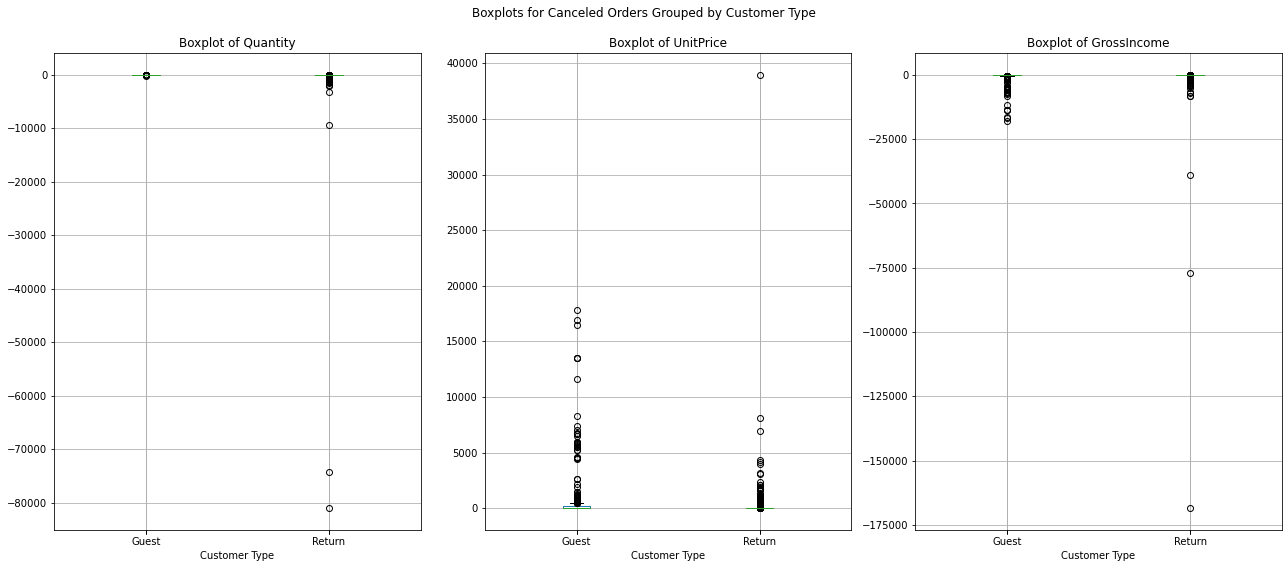

In [38]:
fig,ax = plt.subplots(figsize=(18,8),nrows=1,ncols=3,sharex=True,sharey=False)
ax.flatten()
for i,y in enumerate(labels):
    canceledOrders.boxplot(column=y,by='CustomerType',ax=ax[i])
    ax[i].set_title('Boxplot of '+y)
    ax[i].set_xlabel('Customer Type')
plt.tight_layout()
plt.suptitle('Boxplots for Canceled Orders Grouped by Customer Type')
fig.subplots_adjust(top=.9)
plt.show()

From first glance of the boxplots the two classes of Guest and Return CustomerTypes appear similar within their spread.  The exception is the quantity of extreme outliers for Return customers is greater than that of Guest, to see this more clearly let us look at the Violin Plots adaptation of the above Boxplots to get a sense of density within our data:

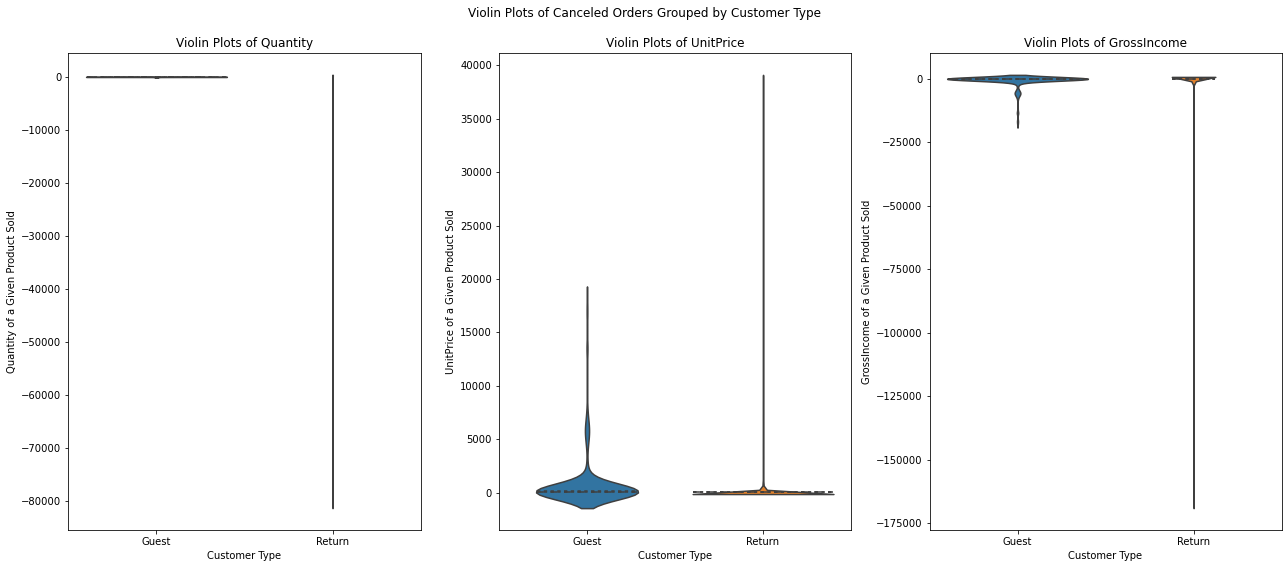

In [39]:
fig,ax = plt.subplots(figsize=(18,8),nrows=1,ncols=3,sharex=False,sharey=False)
ax.flatten()
for i,y in enumerate(labels):
    sns.violinplot(x='CustomerType',y=y,inner='quartile',ax=ax[i],data=canceledOrders,order=['Guest','Return'])
    ax[i].set_ylabel(y+' of a Given Product Sold')
    ax[i].set_title('Violin Plots of '+y)
    ax[i].set_xlabel('Customer Type')
plt.tight_layout()
plt.suptitle('Violin Plots of Canceled Orders Grouped by Customer Type')
fig.subplots_adjust(top=.9)
plt.show()

As we can from the Violin Plots there is a signficant amount of density around 0 for Quantity, UnitPrice, and GrossIncome for both Customer Types--the exception being Return customers within Quantity. 

This large amount of density around 0 comes from the scale we are viewing the distribution. Let us observe a trim of our data--this will be further generalized within the dataframe EC. (Reference **[Section 1.2.1: Functions for Section 3](#section1.2.1)** for the function IQR_Trim to see how this was done)


$\underline{\text{Note}}:$ The type of trim we will use is the Interquartile Range (IQR) Method.

In [40]:
canceledOrders_trim = IQR_Trim(canceledOrders,labels,k=3)
canceledOrders_trim

InvoiceNo StockCode                       Description  Quantity  \
154      C536383    35004C   SET OF 3 COLOURED  FLYING DUCKS        -1   
235      C536391     22556    PLASTERS IN TIN CIRCUS PARADE        -12   
239      C536391     21484       CHICK GREY HOT WATER BOTTLE       -12   
240      C536391     22557  PLASTERS IN TIN VINTAGE PAISLEY        -12   
939      C536506     22960          JAM MAKING SET WITH JARS        -6   
...          ...       ...                               ...       ...   
540448   C581490     22178   VICTORIAN GLASS HANGING T-LIGHT       -12   
540449   C581490     23144   ZINC T-LIGHT HOLDER STARS SMALL       -11   
541715   C581568     21258        VICTORIAN SEWING BOX LARGE        -5   
541716   C581569     84978  HANGING HEART JAR T-LIGHT HOLDER        -1   
541717   C581569     20979     36 PENCILS TUBE RED RETROSPOT        -5   

               InvoiceDate  UnitPrice CustomerID         Country  Month  \
154    2010-12-01 09:49:00       4.65      15311  United Kingdom     12   
235    2010-12-01 10:24:00       1.65      17548  United Kingdom     12   
239    2010-12-01 10:24:00       3.45      17548  United Kingdom     12   
240    2010-12-01 10:24:00       1.65      17548  United Kingdom     12   
939    2010-12-01 12:38:00       4.25      17897  United Kingdom     12   
...                    ...        ...        ...             ...    ...   
540448 2011-12-09 09:57:00       1.95      14397  United Kingdom     12   
540449 2011-12-09 09:57:00       0.83      14397  United Kingdom     12   
541715 2011-12-09 11:57:00      10.95      15311  United Kingdom     12   
541716 2011-12-09 11:58:00       1.25      17315  United Kingdom     12   
541717 2011-12-09 11:58:00       1.25      17315  United Kingdom     12   

              Date  GrossIncome CustomerType  
154     2010-12-01        -4.65       Return  
235     2010-12-01       -19.80       Return  
239     2010-12-01       -41.40       Return  
240     2010-12-01       -19.80       Return  
939     2010-12-01       -25.50       Return  
...            ...          ...          ...  
540448  2011-12-09       -23.40       Return  
540449  2011-12-09        -9.13       Return  
541715  2011-12-09       -54.75       Return  
541716  2011-12-09        -1.25       Return  
541717  2011-12-09        -6.25       Return  

[7839 rows x 12 columns]

When performing the trim for both Quantity and Unit Price we are left with $7839$ rows from our original $9254$ of canceled orders. This trim resulted in roughly $~15\%$ $(1415/9254)$ of the canceled orders being removed from the canceledOrders data frame. The results of this allows for a clearer picture of the remaining $~85\%$ of the data.

$\underline{\text{Note}}:$ The value of our scaler multiple $k$ is greater than the normal $1.5$ seen within text books. This is to allow for the prescence of extreme values to still occur.

Let us reexamine the remaining $~85\%$ of canceled orders as Boxplots and Violin plots once again:



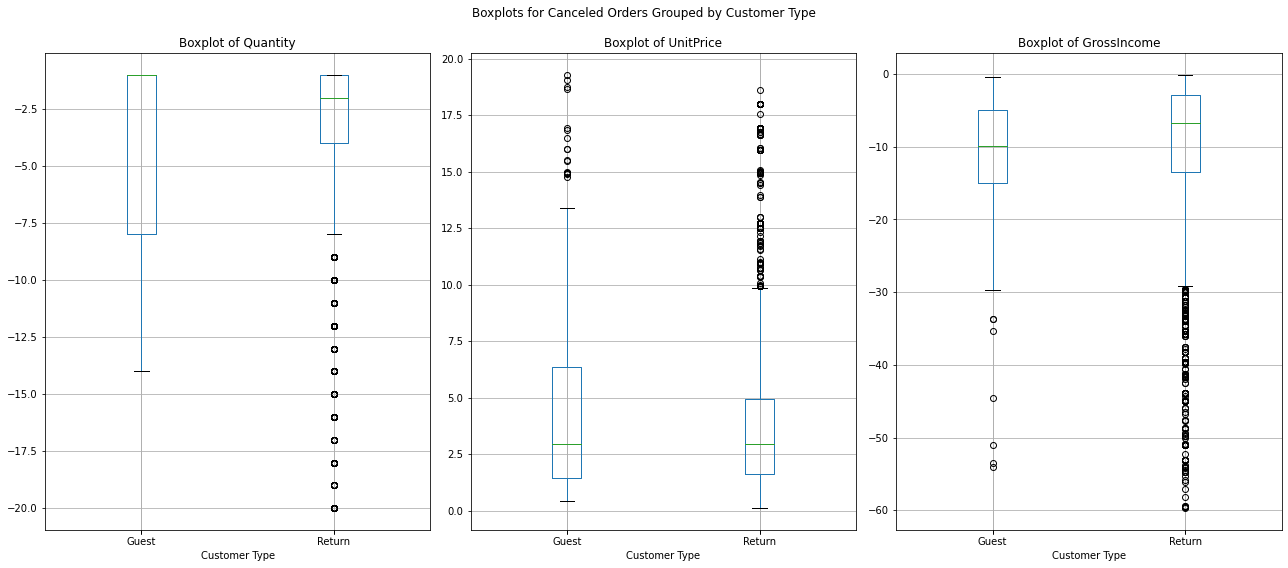

In [41]:
fig,ax = plt.subplots(figsize=(18,8),nrows=1,ncols=3,sharex=True,sharey=False)
ax.flatten()
for i,y in enumerate(labels):
    canceledOrders_trim.boxplot(column=y,by='CustomerType',ax=ax[i])
    ax[i].set_title('Boxplot of '+y)
    ax[i].set_xlabel('Customer Type')
plt.tight_layout()
plt.suptitle('Boxplots for Canceled Orders Grouped by Customer Type')
fig.subplots_adjust(top=.9)
plt.show()

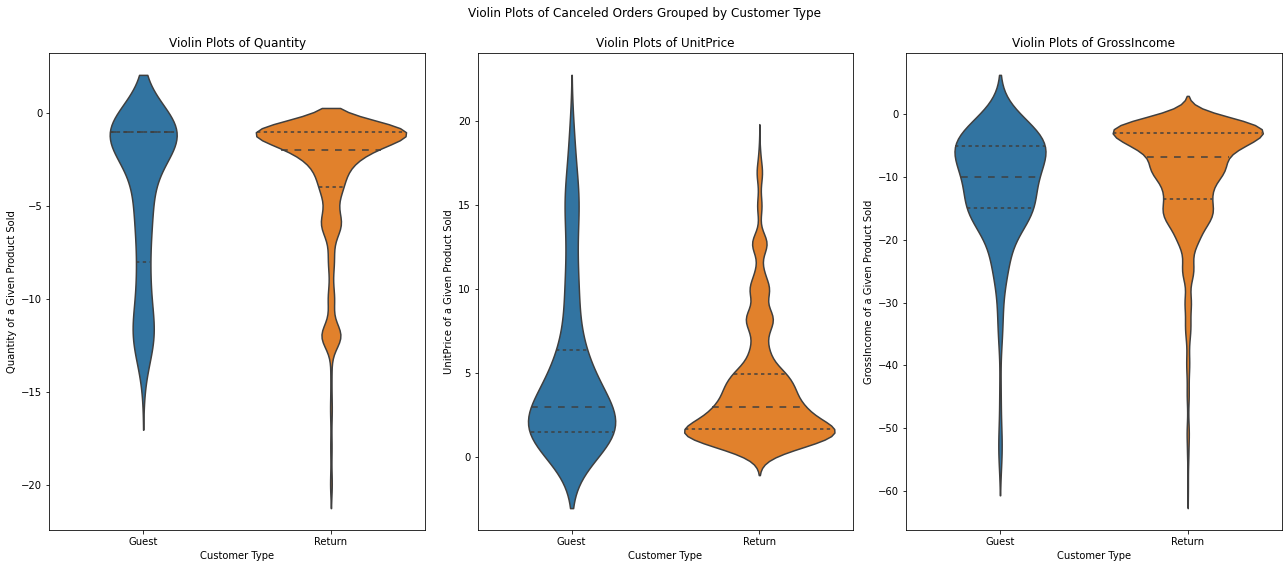

In [42]:
fig,ax = plt.subplots(figsize=(18,8),nrows=1,ncols=3,sharex=False,sharey=False)
ax.flatten()
for i,y in enumerate(labels):
    sns.violinplot(x='CustomerType',y=y,inner='quartile',ax=ax[i],data=canceledOrders_trim,
                   order=['Guest','Return'])
    ax[i].set_ylabel(y+' of a Given Product Sold')
    ax[i].set_title('Violin Plots of '+y)
    ax[i].set_xlabel('Customer Type')
plt.tight_layout()
plt.suptitle('Violin Plots of Canceled Orders Grouped by Customer Type')
fig.subplots_adjust(top=.9)
plt.show()

What was not apparent before has become clear. Guest and Return customers distributions vary for Quantity, UnitPrice, and GrossIncome for canceledOrders, but not drastically. Though, in comparison of means the two vary for Quantity, UnitPrice, and GrossIncome. We will analyze this suspicion more generally within **[Section 3.3: Quantity, Unit Price, and GrossIncome](#section3.3)**.

Before we move on let us view the pairwisescatterplots of the variables Quantity, UnitPrice, and GrossIncome:

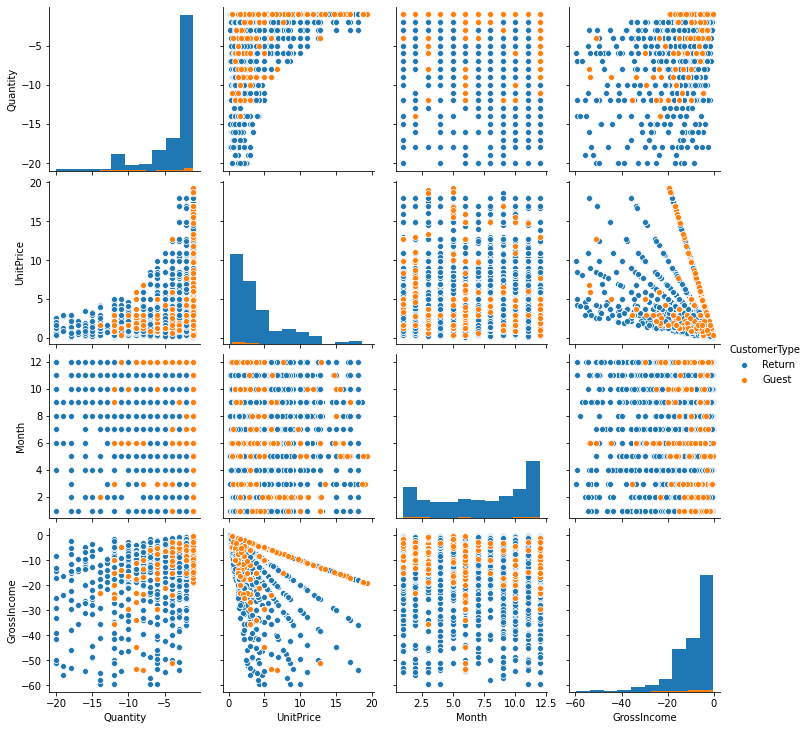

In [43]:
sns.pairplot(data=canceledOrders_trim,hue='CustomerType',diag_kind="hist")
plt.show()

From the seaborn pairplot we can observe some distinctions between Guest and Return Customers. As an example, UnitPrice purchases for 'Guest' customers is lower than that of Return, as well as the Quantity. This will be further explored in **[Section 3.3: Quantity, Unit Price, and GrossIncome](#section3.3)** and [**Section 4: Classification of Customer**](#section4).

### Section 3.2: Unique Stock Code<a name="section3.2"></a>
When working with the EC data frame we noticed the existence of only character StockCode, meaning there could potentially be multiple instances of this occuring. Let us determine what these unique StockCodes are:

In [44]:
""" 
   .*[a-zA-Z]+.*$
    
        ^        : Start of the line
        .*       : Matches any character (except for line terminators, such as \n)
        A-Z      : A single character in the range between A (index 65) and Z (index 90) (case sensitive)
        a-z      : A single character in the range between a (index 97) and z (index 122) (case sensitive)
        [a-zA-Z] : Match letters
        [a-zA-Z]+: Matches one or more consecutive letters character
        $        : Asserts position at the end of a line

"""
specialStockCodes = EC[EC.StockCode.str.contains('^[a-zA-Z]+$',regex=True)]
display(specialStockCodes)
unique_specialStockCode = specialStockCodes.StockCode.unique()
unique_specialStockCode

InvoiceNo StockCode     Description  Quantity         InvoiceDate  \
45        536370      POST         POSTAGE         3 2010-12-01 08:45:00   
141      C536379         D        Discount        -1 2010-12-01 09:41:00   
386       536403      POST         POSTAGE         1 2010-12-01 11:27:00   
1123      536527      POST         POSTAGE         1 2010-12-01 13:04:00   
1814      536544       DOT  DOTCOM POSTAGE         1 2010-12-01 14:32:00   
...          ...       ...             ...       ...                 ...   
541540    581498       DOT  DOTCOM POSTAGE         1 2011-12-09 10:26:00   
541541   C581499         M          Manual        -1 2011-12-09 10:28:00   
541730    581570      POST         POSTAGE         1 2011-12-09 11:59:00   
541767    581574      POST         POSTAGE         2 2011-12-09 12:09:00   
541768    581578      POST         POSTAGE         3 2011-12-09 12:16:00   

        UnitPrice CustomerID         Country  Month        Date  GrossIncome  \
45          18.00      12583          France     12  2010-12-01        54.00   
141         27.50      14527  United Kingdom     12  2010-12-01       -27.50   
386         15.00      12791     Netherlands     12  2010-12-01        15.00   
1123        18.00      12662         Germany     12  2010-12-01        18.00   
1814       569.77         1g  United Kingdom     12  2010-12-01       569.77   
...           ...        ...             ...    ...         ...          ...   
541540   1,714.17      2268g  United Kingdom     12  2011-12-09     1,714.17   
541541     224.69      15498  United Kingdom     12  2011-12-09      -224.69   
541730      18.00      12662         Germany     12  2011-12-09        18.00   
541767      18.00      12526         Germany     12  2011-12-09        36.00   
541768      18.00      12713         Germany     12  2011-12-09        54.00   

       CustomerType  
45           Return  
141          Return  
386          Return  
1123         Return  
1814          Guest  
...             ...  
541540        Guest  
541541       Return  
541730       Return  
541767       Return  
541768       Return  

[2748 rows x 12 columns]

array(['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY',
       'DCGSSGIRL', 'PADS', 'B', 'CRUK'], dtype=object)

Above we pulled the Unique Stock Codes into a list labeled unique_specialStockCode. Now we will display their corresponding descriptions to see what they represent:

In [45]:
for stockCode in unique_specialStockCode:
    print("{:<9} : {:<30}".format(stockCode, EC[EC.StockCode == stockCode].Description.unique()[0]))

POST      : POSTAGE                       
D         : Discount                      
DOT       : DOTCOM POSTAGE                
M         : Manual                        
S         : SAMPLES                       
AMAZONFEE : AMAZON FEE                    
m         : Manual                        
DCGSSBOY  : BOYS PARTY BAG                
DCGSSGIRL : GIRLS PARTY BAG               
PADS      : PADS TO MATCH ALL CUSHIONS    
B         : Adjust bad debt               
CRUK      : CRUK Commission               


Whether this information is relevant to representing EC entirely would be dependent on its percentage within the data frame.

Within the next cell we will provide the perentage by taking the total value counts of each unique_specialStockCode and dividing it by the length of EC.

In [46]:
display(specialStockCodes.StockCode.value_counts())
print('The percentile of Unique Stock Codes within EC: %.2f '%(specialStockCodes.StockCode.value_counts().sum()/len(EC)*100))

POST         1252
DOT           709
M             566
D              77
S              62
AMAZONFEE      34
CRUK           16
DCGSSGIRL      13
DCGSSBOY       11
PADS            4
B               3
m               1
Name: StockCode, dtype: int64

The percentile of Unique Stock Codes within EC: 0.51 


The frequency in which unique_specialStockCodes appear within our data frame is very small--making up roughly ~.51\% of EC. Rendering it to be irrelevant for our purpose. If the reader sees a potential for this small data set, you are free to further develope your  own exploration to this set.

### Section 3.3: Quantity, Unit Price, and GrossIncome<a name="section3.3"></a>
Let us now explore Quantity, UnitPrice, and GrossIncome for EC, similar to how we explored them within **[Section 3.1.2: Canceled Orders](#section3.1.2)**:

In [47]:
EC.describe()[labels]

Quantity  UnitPrice  GrossIncome
count 535,187.00 535,187.00   535,187.00
mean        9.67       4.65        18.17
std       219.06      97.36       381.17
min   -80,995.00 -11,062.06  -168,469.60
25%         1.00       1.25         3.75
50%         3.00       2.08         9.90
75%        10.00       4.13        17.40
max    80,995.00  38,970.00   168,469.60

As we saw within **[Section 3.1.2: Canceled Orders](#section3.1.2)**, there appears to be extreme values within the Quantity, UnitPrice, and GrossIncome. Once again, let us examine the data set as box plots and violin plots:

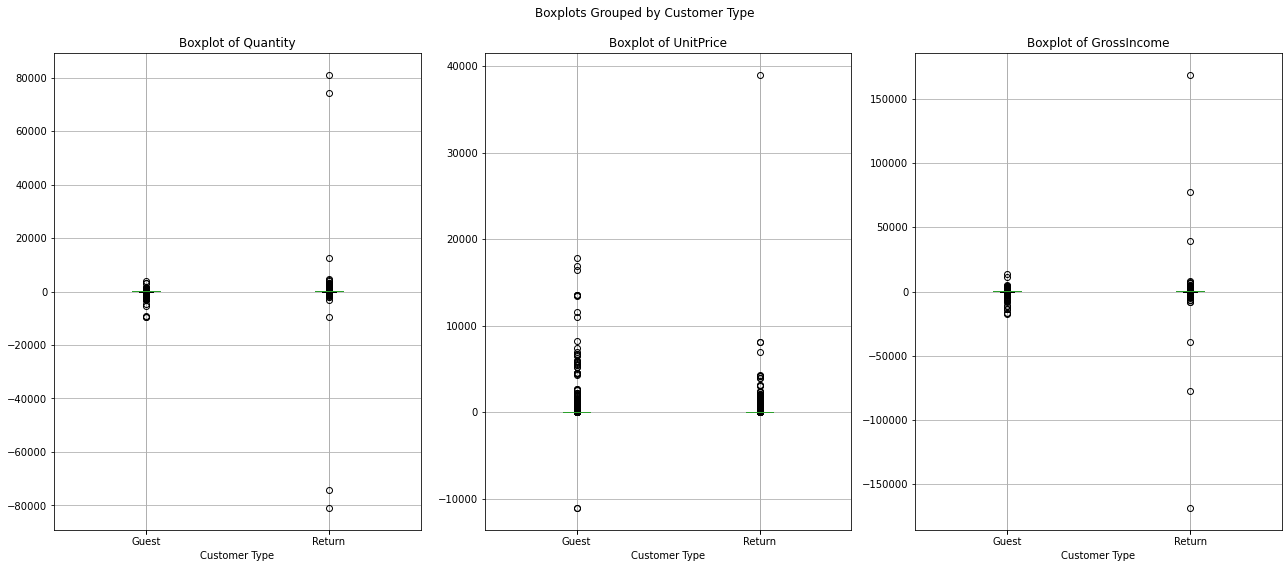

In [48]:
fig,ax = plt.subplots(figsize=(18,8),nrows=1,ncols=3,sharex=True,sharey=False)
ax.flatten()
for i,y in enumerate(labels):
    EC.boxplot(column=y,by='CustomerType',ax=ax[i])
    ax[i].set_title('Boxplot of '+y)
    ax[i].set_xlabel('Customer Type')
plt.tight_layout()
plt.suptitle('Boxplots Grouped by Customer Type')
fig.subplots_adjust(top=.9)
plt.show()

The boxplot showcases the existence of numerous outliers as it did for the original boxplot shown in **[Section 3.1.2: Canceled Orders](#section3.1.2)**. Before proceeding to any removal let us reimagine the above plots as violin plots:

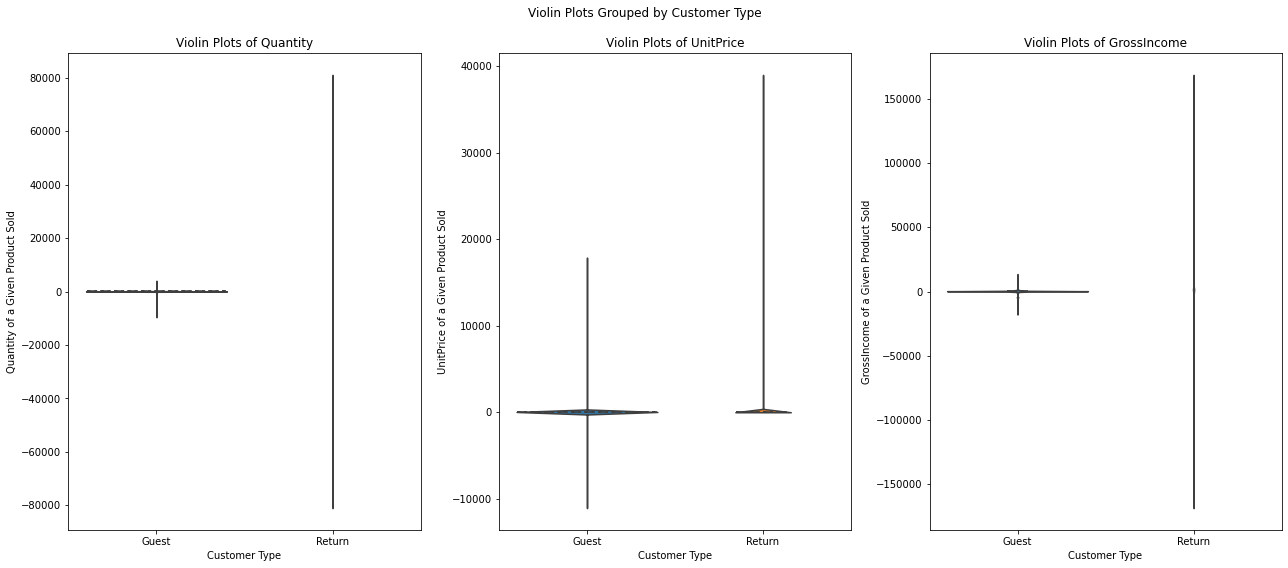

In [49]:
fig,ax = plt.subplots(figsize=(18,8),nrows=1,ncols=3,sharex=False,sharey=False)
ax.flatten()
for i,y in enumerate(labels):
    sns.violinplot(x='CustomerType',y=y,inner='quartile',ax=ax[i],data=EC,order=['Guest','Return'])
    ax[i].set_ylabel(y+' of a Given Product Sold')
    ax[i].set_title('Violin Plots of '+y)
    ax[i].set_xlabel('Customer Type')
plt.tight_layout()
plt.suptitle('Violin Plots Grouped by Customer Type')
fig.subplots_adjust(top=.9)
plt.show()

From these violin plots the vast majority of the data is center around 0, as it weas for **[Section 3.1.2: Canceled Orders](#section3.1.2)** plots, with the exception of Return Customers for Quantity and Gross Income. 

Similar to the method done in **[Section 3.1.2: Canceled Orders](#section3.1.2)** let us trim EC for to explore the distributions of Quantity, UnitPrice, and GrossIncome:

In [50]:
""" Trimming EC """
EC_trim = IQR_Trim(EC,labels)
print('The amount of rows left from the trim is:',len(EC_trim))
EC_trim.describe()[labels]

The amount of rows left from the trim is: 488947


Quantity  UnitPrice  GrossIncome
count 488,947.00 488,947.00   488,947.00
mean        5.89       2.93        10.80
std         6.80       2.54        10.05
min       -25.00       0.00       -35.80
25%         1.00       1.25         3.30
50%         3.00       2.08         8.29
75%        10.00       3.95        15.90
max        36.00      12.75        58.24

When performing the trim for Quantity, UnitPrice, and GrossIncome we are left with $488947$ rows from our original $535187$ of EC. This trim resulted in roughly $~9\%$ $(46240/535187)$ of the orders from EC being removed. The results of this allows for a clearer picture of the remaining $~91\%$ of the data.

Let us reexamine the remaining $~91\%$ of EC, labeled EC_trim, as boxplots and violin plots once again:

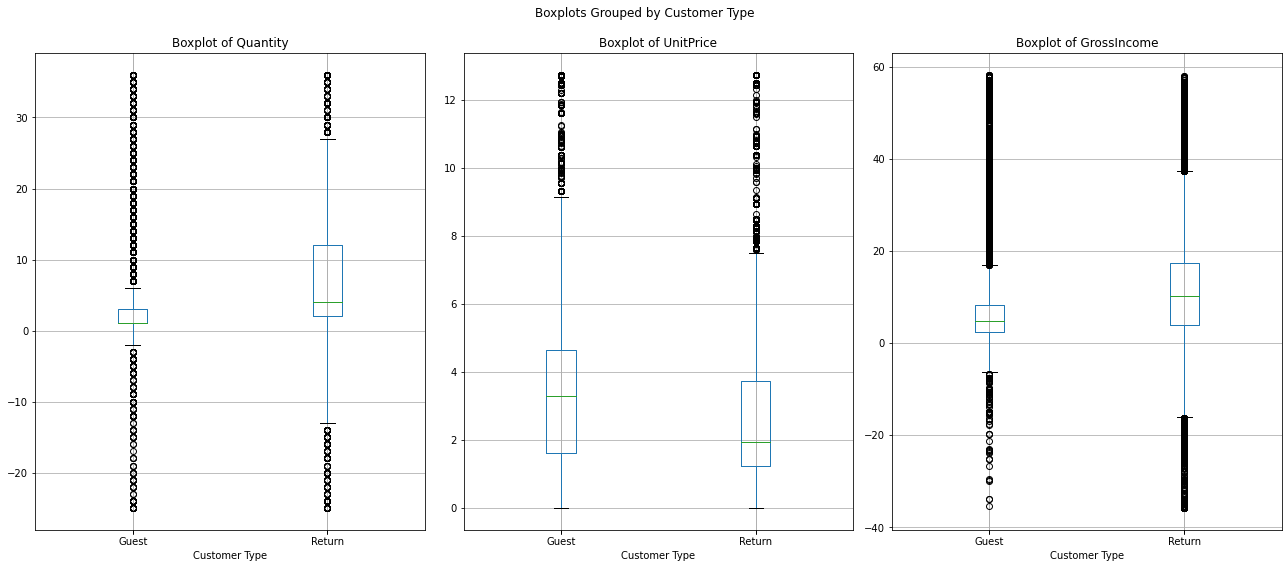

In [51]:
fig,ax = plt.subplots(figsize=(18,8),nrows=1,ncols=3,sharex=True,sharey=False)
ax.flatten()
for i,y in enumerate(labels):
    EC_trim.boxplot(column=y,by='CustomerType',ax=ax[i])
    ax[i].set_title('Boxplot of '+y)
    ax[i].set_xlabel('Customer Type')
plt.tight_layout()
plt.suptitle('Boxplots Grouped by Customer Type')
fig.subplots_adjust(top=.9)
plt.show()

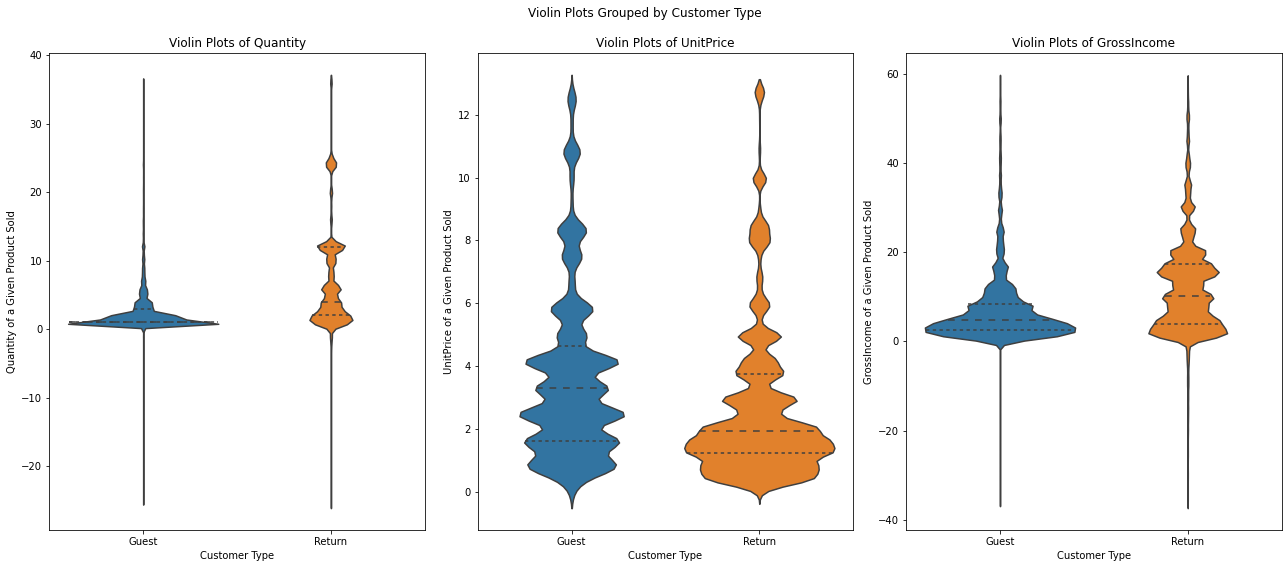

In [52]:
fig,ax = plt.subplots(figsize=(18,8),nrows=1,ncols=3,sharex=False,sharey=False)
ax.flatten()
for i,y in enumerate(labels):
    sns.violinplot(x='CustomerType',y=y,inner='quartile',ax=ax[i],data=EC_trim,order=['Guest','Return'])
    ax[i].set_ylabel(y+' of a Given Product Sold')
    ax[i].set_title('Violin Plots of '+y)
    ax[i].set_xlabel('Customer Type')
plt.tight_layout()
plt.suptitle('Violin Plots Grouped by Customer Type')
fig.subplots_adjust(top=.9)
plt.show()

From the above graphs we hypothesize:
* The mean of Quantity is less for Guest Customers to that of Return.
* The mean of Unit Price is larger for Guest Customers to that of Return.
* The mean of Gross Income is less than for Guest Customers to that of Return.

To show there is at least a difference between the means we will approximate a p-value for a 2 tailed t-test by utilizing the difference of means of a randomized permutation test upon each of these variables.

$\underline{\text{Note}}:$ To those who are unfamiliar with a permutation test reference, *Pratical Statistics for Data Scientists Vol 2 Using R and Python,* by Bruce and Bruce detailed in *Chapter 3: Statistical Experiments and Significance Testing.* 

First, we must take the means of 'Guest' and Return customers:

In [53]:
""" Splitting the databases into Guest and Return Customers """
EC_g = EC_trim[EC_trim.CustomerType=='Guest']
EC_r = EC_trim[EC_trim.CustomerType=='Return']

""" Evaluating the difference of means for our descriptive statistics """
mu_g = EC_g[labels].mean().values
mu_r = EC_r[labels].mean().values
obs_diff_mean = mu_g-mu_r
for cat_diff,y in zip(obs_diff_mean,labels):
    print('Observed Difference of Means of '+y+' for Guest from Return: ',cat_diff)

Observed Difference of Means of Quantity for Guest from Return:  -4.597872110879182
Observed Difference of Means of UnitPrice for Guest from Return:  0.9505324198651595
Observed Difference of Means of GrossIncome for Guest from Return:  -4.665713117773263


Next we perform a permutaiton of the datasets and check for the difference of means between the two classes. This permutation is then performed $1000$ times. 

To see how the permutation test is performed see the function perm_fun in **[Section 1.2.1: Functions for Section 3](#section1.2.1)**

In [54]:
""" Random Seed for Replication """
np.random.seed(1)
""" Performs our difference of means for our 1000 iterations of noise """
permutated_diff_mean = [[perm_fun(EC_r,EC_g,y) for _ in range(1000)] for y in labels]

Now that we have $1000$ difference of means of random noise we will see if our observed difference of means lies outside of the distributions of Quantity, UnitPrice, and GrossIncome:

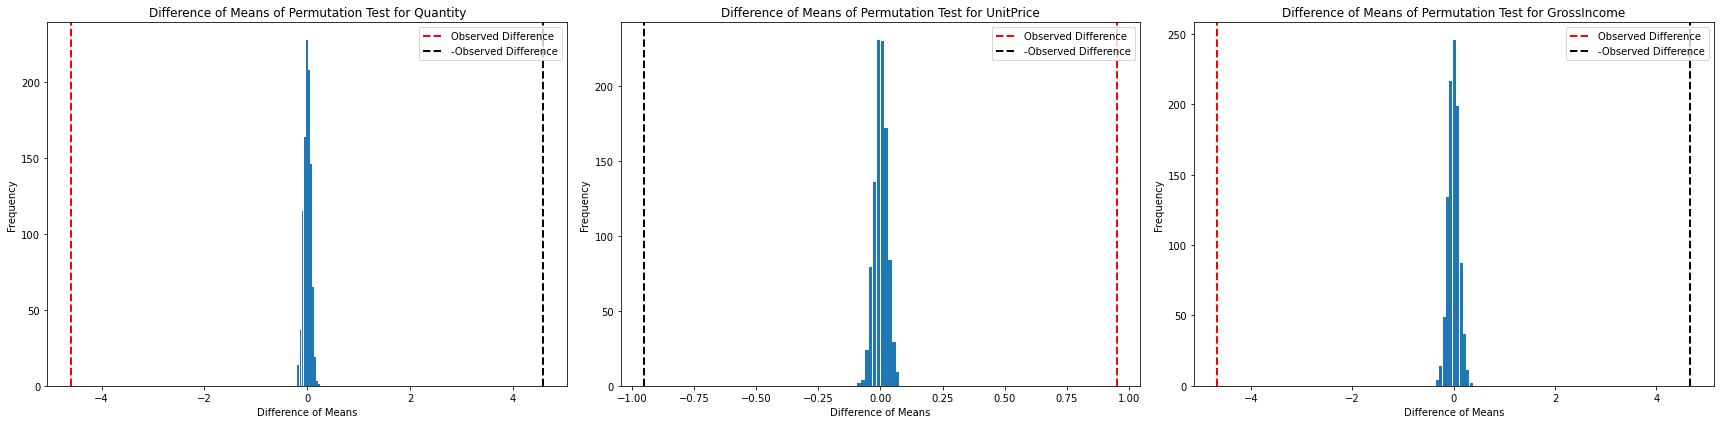

Approximated p-value of our permutation test for Quantity:  0.0
Approximated p-value of our permutation test for UnitPrice:  0.0
Approximated p-value of our permutation test for GrossIncome:  0.0


In [55]:
""" Plotting the Difference of Means for Permutation Tests """
fig,ax = plt.subplots(figsize=(24,6),nrows=1,ncols=3,sharex=False,sharey=False)
ax.flatten()
for i,y in enumerate(zip(obs_diff_mean,permutated_diff_mean,labels)):
    ax[i].hist(y[1],bins=11,rwidth=0.9)
    ax[i].axvline(x=y[0], color='red',linestyle='--',lw=2,label='Observed Difference')
    ax[i].axvline(x=-y[0], color='black',linestyle='--',lw=2,label='-Observed Difference')
    ax[i].set_title('Difference of Means of Permutation Test for '+str(y[2]))
    ax[i].set_xlabel('Difference of Means')
    ax[i].set_ylabel('Frequency')
    ax[i].legend()

plt.legend()
plt.tight_layout()
plt.show()
P = [sum([abs(obs_diff_mean[i])<abs(x) for x in diff])/len(diff) for i,diff in enumerate(permutated_diff_mean)]
for p,y in zip(P,labels):
    print('Approximated p-value of our permutation test for '+str(y)+': ',p)

From our permutation test we can conclude that the difference of means for Quantity, Unit Price, and Gross Income are different for CustomerType. 

As an added insurance we will also perform the same type of test using a t-test from scipy:

In [56]:
for y in labels:
    print(stats.ttest_ind(EC_g[y],EC_r[y],equal_var=False))

Ttest_indResult(statistic=-305.1483187749306, pvalue=0.0)
Ttest_indResult(statistic=109.70033230944655, pvalue=0.0)
Ttest_indResult(statistic=-162.23134107570033, pvalue=0.0)


These tests show that there is distinctions between CustomerTypes, meaning there is potential for a machine learning algorithm to classify whether the data is a guest or return customer. This will be explored within the **[Section 4: Classification of Customers](#section4)**.

Now that we have shown some differences between the two classes let us view the pairplots of Quantity, UnitPrice, Month, and Gross Income as we did in **[Section 3.1.2: Canceled Orders](#section3.1.2)**:

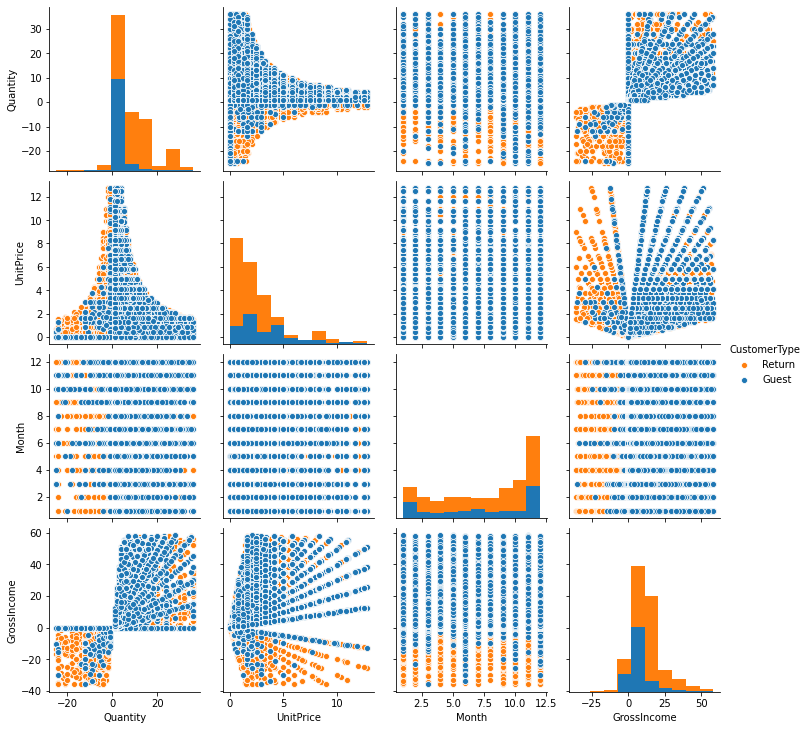

In [55]:
sns.pairplot(data=EC_trim,hue='CustomerType',diag_kind="hist",palette=['C1','C0'])
plt.show()

It's harder to see a distinction between the two, but there are cerain pockets where the classes are distinguishable.

## Section 4: Classification of Customer Types<a name="section4"></a>
The goal of this section is to build a successful classifier for the Customer Type. We will accomplish this by applying standardization (sc) and principal component analysis (PCA) to our data.

In [68]:
""" Predictors and Class """
X = EC_trim[['Quantity','UnitPrice','GrossIncome','Month']]
y = EC_trim['CustomerType']

""" Label Encoder for ML algorithm """
le = LabelEncoder()
y = le.fit_transform(y)

""" Standard Scaling """
sc = StandardScaler()
X_std = sc.fit(X).transform(X)

""" Principal Component Analysis """
pca = PCA()
X_pca = pca.fit_transform(X_std)
EC_pca = pd.DataFrame(X_pca)
EC_pca.columns = ['PC '+str(i) for i in range(4)]
EC_pca['CustomerType'] = le.inverse_transform(y)

""" Seperating Training and Testing Sets: Note variables are Standardized then put into their Principal Components """
X_train,X_test,y_train,y_test = train_test_split(X_pca,y,test_size=.6,random_state=0,stratify=y)
X_pca = np.vstack((X_train,X_test))
y_combined = np.hstack((y_train,y_test))
test_idx = range(X_pca.shape[0]-X_test.shape[0],X_pca.shape[0])

Now that we've standardized and applied PCA to EC let us observe the pairplot of EC_pca:

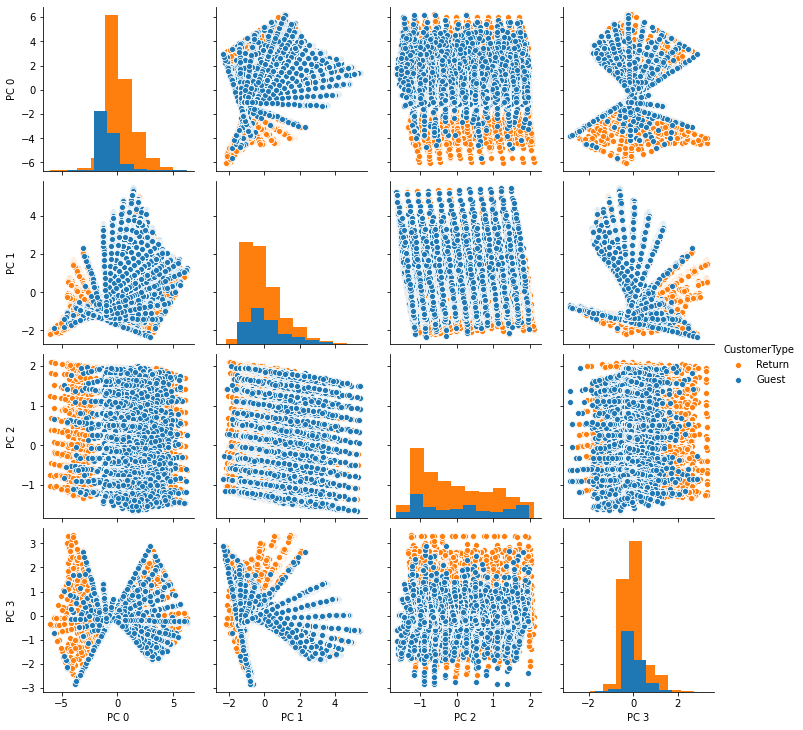

In [69]:
sns.pairplot(data=EC_pca,hue='CustomerType',diag_kind="hist",palette=['C1','C0'])
plt.show()

The largest seperation of class appears to come from the pairs of $(PC_0,PC_1)$, $(PC_0,PC_2)$, $(PC_0,PC_3)$, $(PC_1,PC_3)$, and $(PC_2,PC_3)$.

Ideally we would like to use only 2 coordinates for our classifiers, this is so that we can showcase the decision boundaries of our classifiers. Before selecting which pair let us examine the screeplot of our PCA.

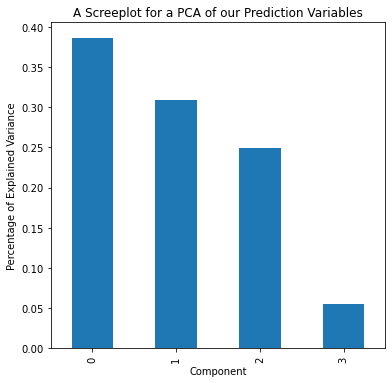

In [70]:
explained_variance_ratio = pd.DataFrame(pca.explained_variance_ratio_)

""" Plots the Percentage of Explained Variance for the our Principal Components  """
fig,ax = plt.subplots(figsize=(6,6))
ax = explained_variance_ratio.plot.bar(legend=False,ax=ax)
ax.set_xlabel('Component')
ax.set_ylabel('Percentage of Explained Variance')
ax.set_title('A Screeplot for a PCA of our Prediction Variables')
plt.show()

Since we observe that the first two components make up nearly 70\% of all explained variance, then we choose to go with these components as our prediction variables for our CustomerType Classification:

In [71]:
X_train = X_train[:,:2]
X_test = X_test[:,:2]
X_pca = X_pca[:,:2]

### Section 4.1: Base Classifiers<a name="section4.1"></a>
Within this seciton we will explore how simple classification algorithms, such as: Logistic Regression, K-Nearest Neighbors, and Decision Trees peform on our standardized then PCA'd dataset:

In [72]:
""" Classifiers Testing """
CLF = []
CLF.append(LogisticRegression(random_state=0).fit(X_train,y_train))
CLF.append(KNeighborsClassifier(n_neighbors=3, p=2, metric='minkowski').fit(X_train,y_train))
CLF.append(DecisionTreeClassifier(criterion='entropy', random_state=0).fit(X_train,y_train))

#### Section 4.1.1: Base Decision Regions<a name="section4.1.1"></a>
Here we display the decision regions of scikit learn classifiers. To understand how the function Decision_Regions works, reference **[Section 1.2.2: Functions for Section 4](#section1.2.2)**.

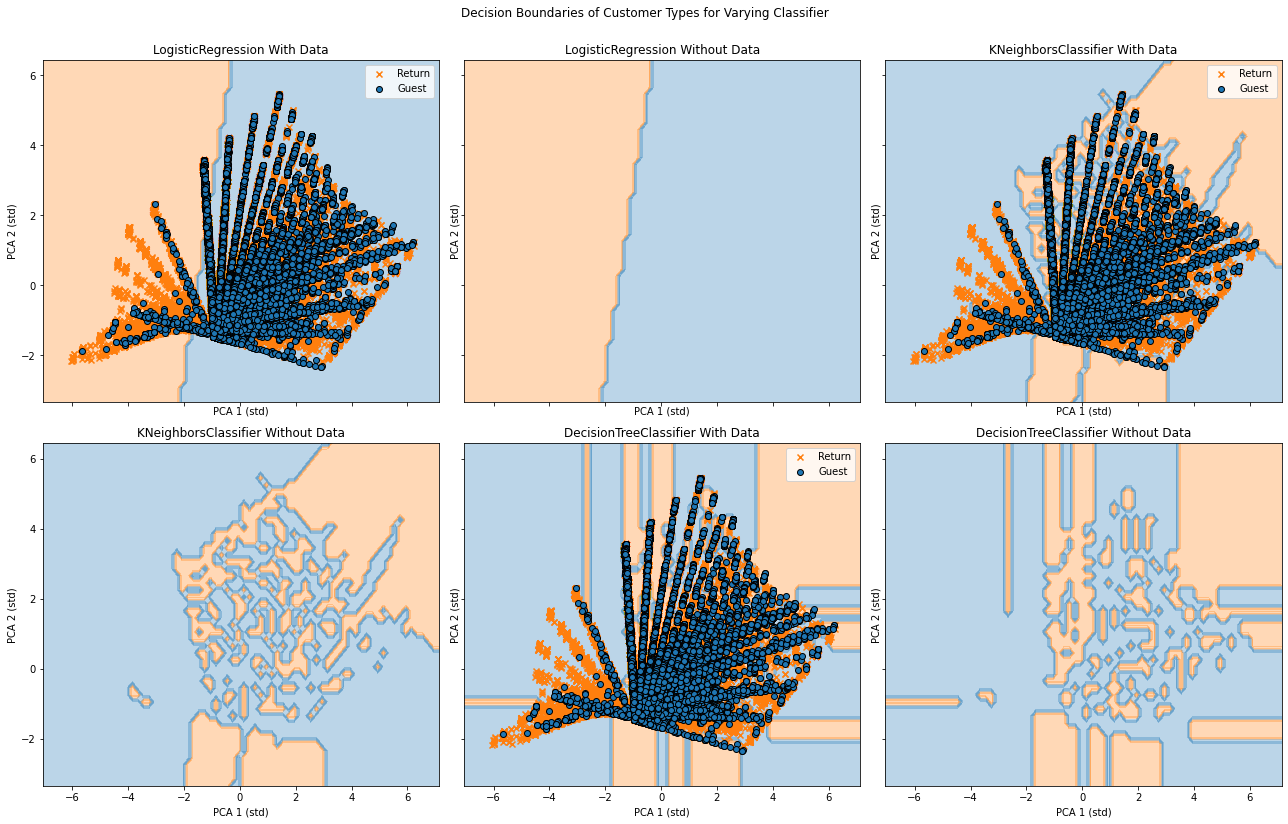

In [73]:
""" Plot Decision Regions of Classifiers """
Decision_Regions(X_pca,y_combined,Classifier=CLF,resolution=0.2)

From the decision boundaries made above we can see the linear classifier LogisticRegression fail in capturing the nature of our classes, not surprising when considering how close overlap with one another. Though, K-Nearest Neighbors and DecisionTrees do well in partitioning Guest from Return customers.

We will now constuct metrics that supports LogisticRegression does poorly and K-Nearest Neighbors and DecisionTrees do well in partitioning Guest from Return customers.

#### Section 4.1.2: Base Confusion Matrices<a name="section4.1.2"></a>
First we shall start with Confusion Matrices, where variables with hats are our predictions while those without are the true class labels.

Once again, we are using a funciton that was defined within **[Section 1.2.2: Functions for Section 4](#section1.2.2)**

In [81]:
conf_mat(X_test,y_test,CLF)

True Percentage of Class Within Given Data Set
Guest  : 25.14
Return : 74.86

Confusion Matrix on Test Data Set for the Classifier 
LogisticRegression(random_state=0):


$\hat Y $ = Guest       $\hat Y $ = Return    
$Y  $ = Guest                         1.09                   24.05
$Y  $ = Return                        2.23                   72.63

Confusion Matrix on Test Data Set for the Classifier 
KNeighborsClassifier(n_neighbors=3):


$\hat Y $ = Guest       $\hat Y $ = Return    
$Y  $ = Guest                        21.57                    3.57
$Y  $ = Return                        2.22                   72.63

Confusion Matrix on Test Data Set for the Classifier 
DecisionTreeClassifier(criterion='entropy', random_state=0):


$\hat Y $ = Guest       $\hat Y $ = Return    
$Y  $ = Guest                        22.24                    2.90
$Y  $ = Return                        1.99                   72.87

Confusion Matrix on Test Data Set for the Classifier 
VotingClassifier(estimators=[('KNeighborsClassifier',
                              KNeighborsClassifier(n_neighbors=3)),
                             ('DecisionTreeClassifier',
                              DecisionTreeClassifier(criterion='entropy',
                                                     random_state=0))],
                 voting='soft'):


$\hat Y $ = Guest       $\hat Y $ = Return    
$Y  $ = Guest                        22.08                    3.06
$Y  $ = Return                        1.94                   72.92

Confusion Matrix on Test Data Set for the Classifier 
RandomForestClassifier(max_depth=32, n_estimators=256, random_state=0):


$\hat Y $ = Guest       $\hat Y $ = Return    
$Y  $ = Guest                        22.13                    3.02
$Y  $ = Return                        1.83                   73.03

As we can see from the results above it is not suprising that our claim was confirmed. Clearly LogisticRegression tends to lean heavily within predicting the all values as returns, and once again this may be observed within the decision boundaries. While, K-Nearest Neighbors and Decision Tress tend to predict both classes fairly well.

#### Section 4.1.3: Base ROC Curves and AUC Scores<a name="section4.1.3"></a>
Within the following cell we will show the k-fold cross validated auc scores of our training set and plot the ROC and determine the AUC scores of our test set for our classifiers. Once again we are using a funciton that was defined within **[Section 1.2.2: Functions for Section 4](#section1.2.2)**

10-fold Cross Validation AUC Scores on Trained Data:

LogisticRegression(random_state=0):
ROC AUC: 0.747698 (+/- 0.004570) 

KNeighborsClassifier(n_neighbors=3):
ROC AUC: 0.943316 (+/- 0.002671) 

DecisionTreeClassifier(criterion='entropy', random_state=0):
ROC AUC: 0.961597 (+/- 0.001953) 



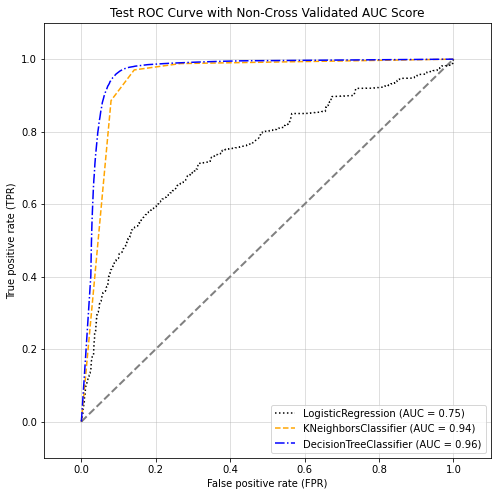

In [66]:
""" 
    10-Fold Cross Validation for Select Models 
    
    Using Area Underneath the Curve (AUC) of Receiver Operating Characteristics (ROC)
    
    The ROC curve plots recall (sensitivity) on the y-axis against specificity on the x-axis.
        Sensitivity: The percent (or proportion) of all 1s that are correctly classified as 1s.
        Specificity: The percent (or proportion) of all 0s that are correctly classified as 0s.
    
    Note: A perfect classifier would resemble a right triangle.
    
"""
k_fold_cv_and_roc(X_train=X_train,y_train=y_train,
                  X_test=X_test,y_test=y_test,
                  CLF=CLF,k=10,scoring='roc_auc')

It appears that Logistic Regression performs so poorly that at one point it gets outperformed by randon noise--this can be seen on the top right where Logistic Regression dips below the diagonal. Our best base classifiers as of now are K-Nearest Neighbors and Decision Trees. We will further improve these classifiers within **[Section 1.2.2: Functions for Section 4](#section1.2.2)**, for now let us turn our attention to accuracy 

#### Section 4.1.4: Base Accuracy<a name="section4.1.4"></a>
Lastly we will review the accuracies of our classifiers before we conclude this seciton.

In [67]:
accuracies(X=X_test,y=y_test,CLF=CLF)

Accuracies of Various Classifiers on Test Set:

LogisticRegression(random_state=0):
Accuracy: 73.72

KNeighborsClassifier(n_neighbors=3):
Accuracy: 94.21

DecisionTreeClassifier(criterion='entropy', random_state=0):
Accuracy: 95.11



Even though the accuracy score for Logistic Regression appears fair, we know from our observations shown in **[Section 4.1.1: Base Decision Regions](#section4.1.1)**, **[Section 4.1.2: Base Confusion Matrices](#section4.1.2)**, and **[Section 4.1.3: Base ROC Curves and AUC Scores](#section4.1.3)** that accuracy does not correlate to great model performance. The 73.72\% accuracy found for LogisticRegression comes from this classifier trying to classify most of the dataset as Return customers.

Not to discredit accuracy, since when determining the bettter of KNN and Decision Trees one could use accuracy as a deciding parameter.

#### Section 4.1.5: Base Classifier Conclusion<a name="section4.1.5"></a>
As we can observe from the Decision Regions, Confusion Matrices, ROC Curves, AUC Scores, and Accuracy Scores the best classifiers were the DecisionTree Classifier and K-Nearest Neighbors. These classifiers did really well within our test, but for the next section *Section 4.2: Ensemble Methods* we wish to improve the all metrics found within **[Section 4.1: Base Classifiers](#section4.1)**

### Section 4.2: Ensemble Methods<a name="section4.2"></a>
Within this section we will apply two ensemble techniques: Soft Majority Voting and Random Forrest. 

#### Section 4.2.1: Soft Majority Voting<a name="section4.2.1"></a>
For our Majority Vote we will utilize our K-Nearest Neighbors Decision Tree Algorithms from **[Section 4.1: Base Classifiers](#section4.1)**

In [75]:
estimators = []
for i,clf in enumerate(CLF):
    if i>0:
        estimators += [(clf.__class__.__name__,clf)]
CLF.append(VotingClassifier(estimators=estimators,voting='soft').fit(X_train,y_train))

##### Section 4.2.1.1: Soft Majority Decision Regions<a name="section4.2.1.1"></a>
We will produce the Decision Regions of Majority Vote partnered with the Classifiers it was built from:

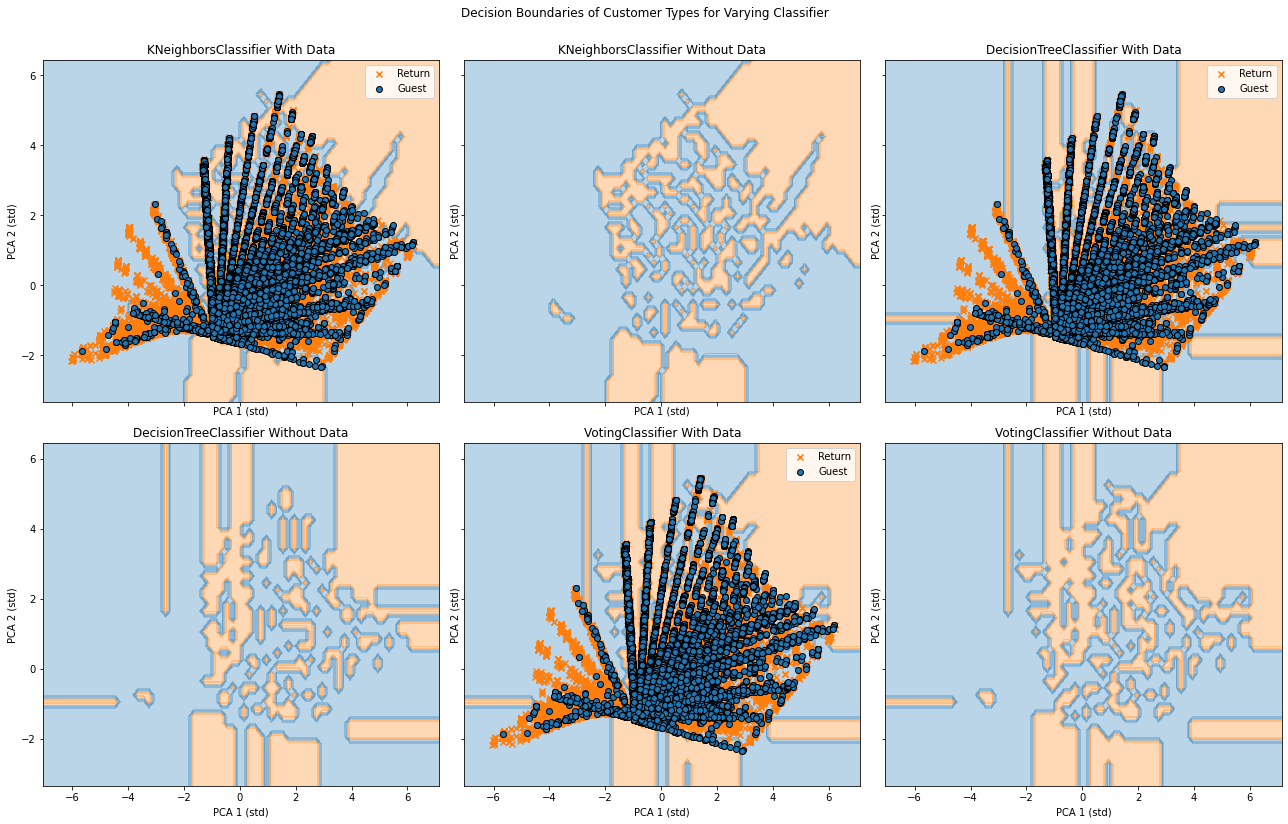

In [76]:
Decision_Regions(X_pca,y_combined,Classifier=CLF[1:],resolution=0.2)

##### Section 4.2.1.2: Soft Majority Confusion Matrix<a name="section4.2.1.2"></a>
Similarly, we will produce the Confusion Matrices of Majority Vote partnered with the Classifiers it was built from:

In [70]:
conf_mat(X_test,y_test,CLF[1:])

True Percentage of Class Within Given Data Set
Guest  : 25.14
Return : 74.86

Confusion Matrix on Test Data Set for the Classifier 
KNeighborsClassifier(n_neighbors=3):


$\hat Y $ = Guest       $\hat Y $ = Return    
$Y  $ = Guest                        21.57                    3.57
$Y  $ = Return                        2.22                   72.64

Confusion Matrix on Test Data Set for the Classifier 
DecisionTreeClassifier(criterion='entropy', random_state=0):


$\hat Y $ = Guest       $\hat Y $ = Return    
$Y  $ = Guest                        22.24                    2.90
$Y  $ = Return                        1.99                   72.87

Confusion Matrix on Test Data Set for the Classifier 
VotingClassifier(estimators=[('KNeighborsClassifier',
                              KNeighborsClassifier(n_neighbors=3)),
                             ('DecisionTreeClassifier',
                              DecisionTreeClassifier(criterion='entropy',
                                                     random_state=0))],
                 voting='soft'):


$\hat Y $ = Guest       $\hat Y $ = Return    
$Y  $ = Guest                        22.09                    3.06
$Y  $ = Return                        1.94                   72.92

The values within the confusion matrix of the Soft Majority Voting Method would suggest that ensemble of our two methods, KNN and Decision Trees, will not produce a better method for classification. We shall continue with our metrics as we did prior within **[Section 4.1: Base Classifiers](#section4.1)**, to see if the Soft Majority Voting wins out on certain aspects that Decision Treee lacks in.

##### Section 4.2.1.3: Soft Majority ROC Curves and AUC Scores<a name="section4.2.1.3"></a>
Now we will show the k-fold cross validated auc scores of our training set and plot the ROC and determine the AUC scores of our test set for our Soft Majority Voting partnered with it's parts:

10-fold Cross Validation AUC Scores on Trained Data:

KNeighborsClassifier(n_neighbors=3):
ROC AUC: 0.943316 (+/- 0.002671) 

DecisionTreeClassifier(criterion='entropy', random_state=0):
ROC AUC: 0.961597 (+/- 0.001953) 

VotingClassifier(estimators=[('KNeighborsClassifier',
                              KNeighborsClassifier(n_neighbors=3)),
                             ('DecisionTreeClassifier',
                              DecisionTreeClassifier(criterion='entropy',
                                                     random_state=0))],
                 voting='soft'):
ROC AUC: 0.964638 (+/- 0.001602) 



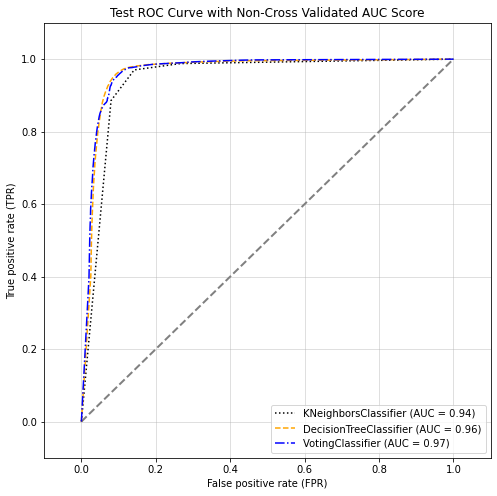

In [71]:
k_fold_cv_and_roc(X_train=X_train,y_train=y_train,
                        X_test=X_test,y_test=y_test,
                        CLF=CLF[1:],k=10,scoring='roc_auc')

##### Section 4.2.1.4: Soft Majority Accuracy<a name="section4.2.1.4"></a>
Lastly, for Soft Majority Voting we will determine it's effectiveness on our test set:

In [72]:
accuracies(X=X_test,y=y_test,CLF=CLF[1:])

Accuracies of Various Classifiers on Test Set:

KNeighborsClassifier(n_neighbors=3):
Accuracy: 94.21

DecisionTreeClassifier(criterion='entropy', random_state=0):
Accuracy: 95.11

VotingClassifier(estimators=[('KNeighborsClassifier',
                              KNeighborsClassifier(n_neighbors=3)),
                             ('DecisionTreeClassifier',
                              DecisionTreeClassifier(criterion='entropy',
                                                     random_state=0))],
                 voting='soft'):
Accuracy: 95.00



For accuracy Decision Trees, once again, outperforms our Soft Majority Voting.

##### Section 4.2.1.5: Soft Majority Conclusion<a name="section4.2.1.5"></a>
The trade off for a slighly higher Return prediction for a lower positive prediction rate of Guest customers does not yield a better accuracy. Though, it does result in a higher Voting Classifier. When considering the rare class problem of the Guest customer, where it is roughly 25\% of our data, then lowering prediction for this class hold more negative weight in our eyes than that of increasing predictions for Return customers.

#### Section 4.2.2: Random Forest<a name="section4.2.2"></a>
In search of a better model then our base classifiers we attempt to improve the DecisionTree Classifier by using an ensemble method that strictly uses various DecisionTrees, e.g. a Random Forest.

In [78]:
RF = RandomForestClassifier(max_depth=32,n_estimators=256, random_state=0).fit(X_train,y_train)
CLF += [RF]

##### Section 4.2.2.1: Random Forest Decision Regions<a name="section4.2.2.1"></a>
Now we will pair our Random Forest with our Decision Region Classifier:

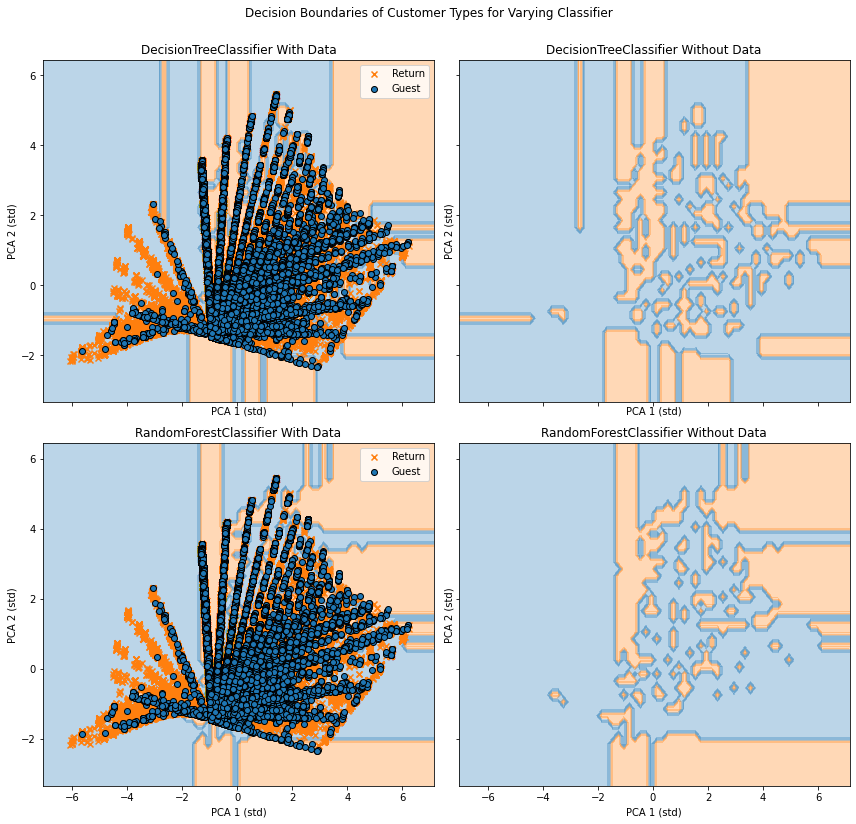

In [79]:
Decision_Regions(X_pca,y_combined,Classifier=[CLF[2]]+[CLF[4]],resolution=0.2)

The Random Forest appears slighlty more general towards return Customers while narrowing in on the location of the Guest Customers.
##### Section 4.2.2.2:  Random Forest Confusion Matrix<a name="section4.2.2.2"></a>
Here we decided to show the confusion matrices of Random Forest and Decision Trees for comparison reasons.

In [75]:
conf_mat(X_test,y_test,[CLF[2]]+[CLF[4]])

True Percentage of Class Within Given Data Set
Guest  : 25.14
Return : 74.86

Confusion Matrix on Test Data Set for the Classifier 
DecisionTreeClassifier(criterion='entropy', random_state=0):


$\hat Y $ = Guest       $\hat Y $ = Return    
$Y  $ = Guest                        22.24                    2.90
$Y  $ = Return                        1.99                   72.87

Confusion Matrix on Test Data Set for the Classifier 
RandomForestClassifier(max_depth=32, n_estimators=256, random_state=0):


$\hat Y $ = Guest       $\hat Y $ = Return    
$Y  $ = Guest                        22.13                    3.02
$Y  $ = Return                        1.83                   73.03

As suspected the Random Forest predicts Return customers well compared to that of the Decision Tree, but it loses when it comes to predicting Guest customers to Decision Trees. Though the trade off here yields a gain in accuracy, which we will explore more within **[Section 4.2.1.4: Soft Majority Accuracy](#section4.2.1.4)**

##### Section 4.2.2.3: Random Forest ROC Curves and AUC Scores<a name="section4.2.2.3"></a>
Here we decide to plot the Decision Tree's and Random Forest's ROC curves for test sets as well as their ROC AUC scores for training set:

10-fold Cross Validation AUC Scores on Trained Data:

DecisionTreeClassifier(criterion='entropy', random_state=0):
ROC AUC: 0.961597 (+/- 0.001953) 

RandomForestClassifier(max_depth=32, n_estimators=256, random_state=0):
ROC AUC: 0.971558 (+/- 0.001184) 



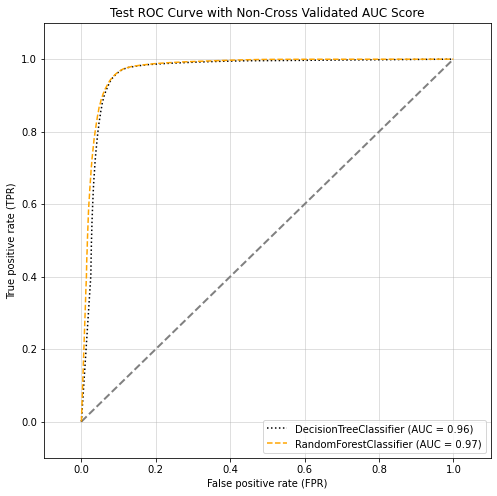

In [76]:
k_fold_cv_and_roc(X_train=X_train,y_train=y_train,
                        X_test=X_test,y_test=y_test,
                        CLF=[CLF[2]]+[CLF[4]],k=10,scoring='roc_auc')

Random Forest and Decsion Tree act very similar--not surprising since the Random Forest is the collection of multiple Decision Trees. Random Forest does win out on AUC win run against Decision Tree. We now need to determine our final metric of Accuracy to make a decision on the better of the two classifiers.

##### Section 4.2.2.4: Random Forest Accuracy<a name="section4.2.2.4"></a>
Once again, I decided to show the accuracies for all classifiers so far to see how they compare to one another.

In [77]:
accuracies(X=X_test,y=y_test,CLF=[CLF[2]]+[CLF[4]])

Accuracies of Various Classifiers on Test Set:

DecisionTreeClassifier(criterion='entropy', random_state=0):
Accuracy: 95.11

RandomForestClassifier(max_depth=32, n_estimators=256, random_state=0):
Accuracy: 95.16



The accuracy of our Random Forest did outperform a single decision tree. That being said, Random Forest will take substantially longer to compute than that of a single Decision Tree.

##### Section 4.2.2.5: Random Forest Conclusion<a name="section4.2.2.5"></a>
Random Forest is our best classifier when it comes to accuracy, AUC score, but not a TPR for Guest prediction. Perhaps we can alter this by hyperparamterization via gridsearch.

### Section 4.3: Hyperparamterization With GridSearch<a name="section4.3"></a>
As mentioned within the previous subsection we wish to obtain the best possible classifier using grid search. This section is dedicated to performing grid searches on the previous classifiers explored.

#### Section 4.3.1: The Grid Search<a name="section4.3.1"></a>
Within the following cell we define a parameter grid for our base classifiers using dictionary/hash data structures:

In [78]:
""" Logistic Regression Parameter Grid """
# 120 Fits: penalty*C*class_weight*kfolds=3*3*2*5=90
logistic_params = {'penalty':['none','l1','l2'],
                            'C':[0.01,.1,1.],
                            'class_weight':[None,'balanced']}

# 90 Fits: n_neighbors*weights*p*kfolds=4*2*4*5=160
""" K-Nearest Neighbors Parameter Grid """
knn_params = {'n_neighbors':[2,3,5,7],
                       'weights':['uniform','distance'],
                       'p':[1,2,3,4]}

# 80 Combinations: criterion*max_depth*class_weight*kfolds=2*5*2*5=100
""" Decision Tree Parameter Grid """
tree_params = {'criterion':['gini','entropy'],
                        'max_depth':[12,18,24,36,None],
                        'class_weight':[None,'balanced']}



# 3200 Fits: n_neighobrs*weights*p*criterion*max_depth*class_weight*kfolds=4*2*4*2*5*2*5=3200
""" Majority Voting Parameter Grid """
voting_params = {'knn__n_neighbors': [2,3,5,7],
                 'knn__weights':['uniform', 'distance'],
                 'knn__p': [1,2,3,4],
                 'tree__criterion':['gini','entropy'],
                 'tree__max_depth':[12,18,24,36,None],
                 'tree__class_weight':[None,'balanced']
                }
# 240 Fits: criterion*max_depth*n_estimators*class_weight*kfolds=2*5*2*3*4=240
""" Random Forest Parmeter Grid """
forest_params = {'criterion':['gini','entropy'],
                 'max_depth': [16,24,32,36,None],
                 'n_estimators': [128],
                 'class_weight':['balanced','balanced_subsample',None]
                }

# 3730 Total Fits
PARAM = [logistic_params,knn_params,tree_params,voting_params,forest_params]

We put all our parameter dictionaries into an array labeled PARAM. This is so that they may be used iteratively within the grid_search_storage function defined in **[Section 1.2.2: Functions for Section 4](#section1.2.2)**.

We shall now define the classifiers that correspond to the grids above. We will also put these classifiers into an array labeled TEST similar to how we did for the array labeled PARAM, where classifiers of TEST will correspond to grids in PARAM. Again, this is for the use of the function grid_search_storatge found in **[Section 1.2.2: Functions for Section 4](#section1.2.2)**:

In [79]:
lr = LogisticRegression(random_state=0)
knn = KNeighborsClassifier()
tree = DecisionTreeClassifier(random_state=0)
mv = VotingClassifier(estimators=[('knn', knn),
                                  ('tree', tree)],
                      voting='soft')
rf = RandomForestClassifier(random_state=0)
TEST = [lr,knn,tree,mv,rf]

Now that we've formulated PARAM and TEST we shall now perform grid searches using 'roc_auc' as our scoring, this is so that we may push the models to predict both Guest and Return customers well. The types of classifiers being grid searched on are similar to the ones found in **[Section 4.1: Base Classifiers](#section4.1)** and **[Section 4.2: Ensemble Methods](#section4.2)**.

<span style='color:red'>$\underline{\text{Caution}}:$</span>

If you wish to avoid running the below computation refer to **[Section 1.3.1: Processed Data and Models from Section 4](#section1.3.1)** for loading in the best models from disk.

In [80]:
best_CLF = grid_search_storage(X=X_train,y=y_train,TEST=TEST,PARAM=PARAM,
                    scoring='roc_auc',n_jobs=-1,cv=5,verbose=3)
best_CLF

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  75 out of  90 | elapsed:    1.6s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    2.0s finished



Time taken: 0 hours 0 minutes and 2.39 seconds.

Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:   16.9s finished



Time taken: 0 hours 0 minutes and 17.3 seconds.

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    6.9s finished



Time taken: 0 hours 0 minutes and 7.34 seconds.

Fitting 5 folds for each of 640 candidates, totalling 3200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   19.2s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:   41.7s
[Parallel(n_jobs=-1)]: Done 496 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 1136 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 1552 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 2032 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 2576 tasks      | elapsed:  6.9min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:  8.7min
[Parallel(n_jobs=-1)]: Done 3200 out of 3200 | elapsed:  8.7min finished



Time taken: 0 hours 8 minutes and 44.79 seconds.

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  8.4min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed: 10.9min finished



Time taken: 0 hours 11 minutes and 13.03 seconds.



[LogisticRegression(C=0.1, random_state=0),
 KNeighborsClassifier(n_neighbors=7, p=3, weights='distance'),
 DecisionTreeClassifier(max_depth=36, random_state=0),
 VotingClassifier(estimators=[('knn', KNeighborsClassifier(n_neighbors=7)),
                              ('tree',
                               DecisionTreeClassifier(class_weight='balanced',
                                                      random_state=0))],
                  voting='soft'),
 RandomForestClassifier(max_depth=32, n_estimators=128, random_state=0)]

When hyperparameterizing the variables for our classifiers we stored the best classifiers into our local disk. This is so that we do not have to keep calling the function above anytime we wish get the best models.

#### Section 4.3.2: Hyperparamterizated Classifiers Decision Regions<a name="section4.3.2"></a>
It is only natural that we run the same metrics done in **[Section 4.1: Base Classifiers](#section4.1)** and **[Section 4.2: Ensemble Methods](#section4.2)** to see the results of the gridsearch. Firstly, as we did prior, we shall start with the Decision Regions:

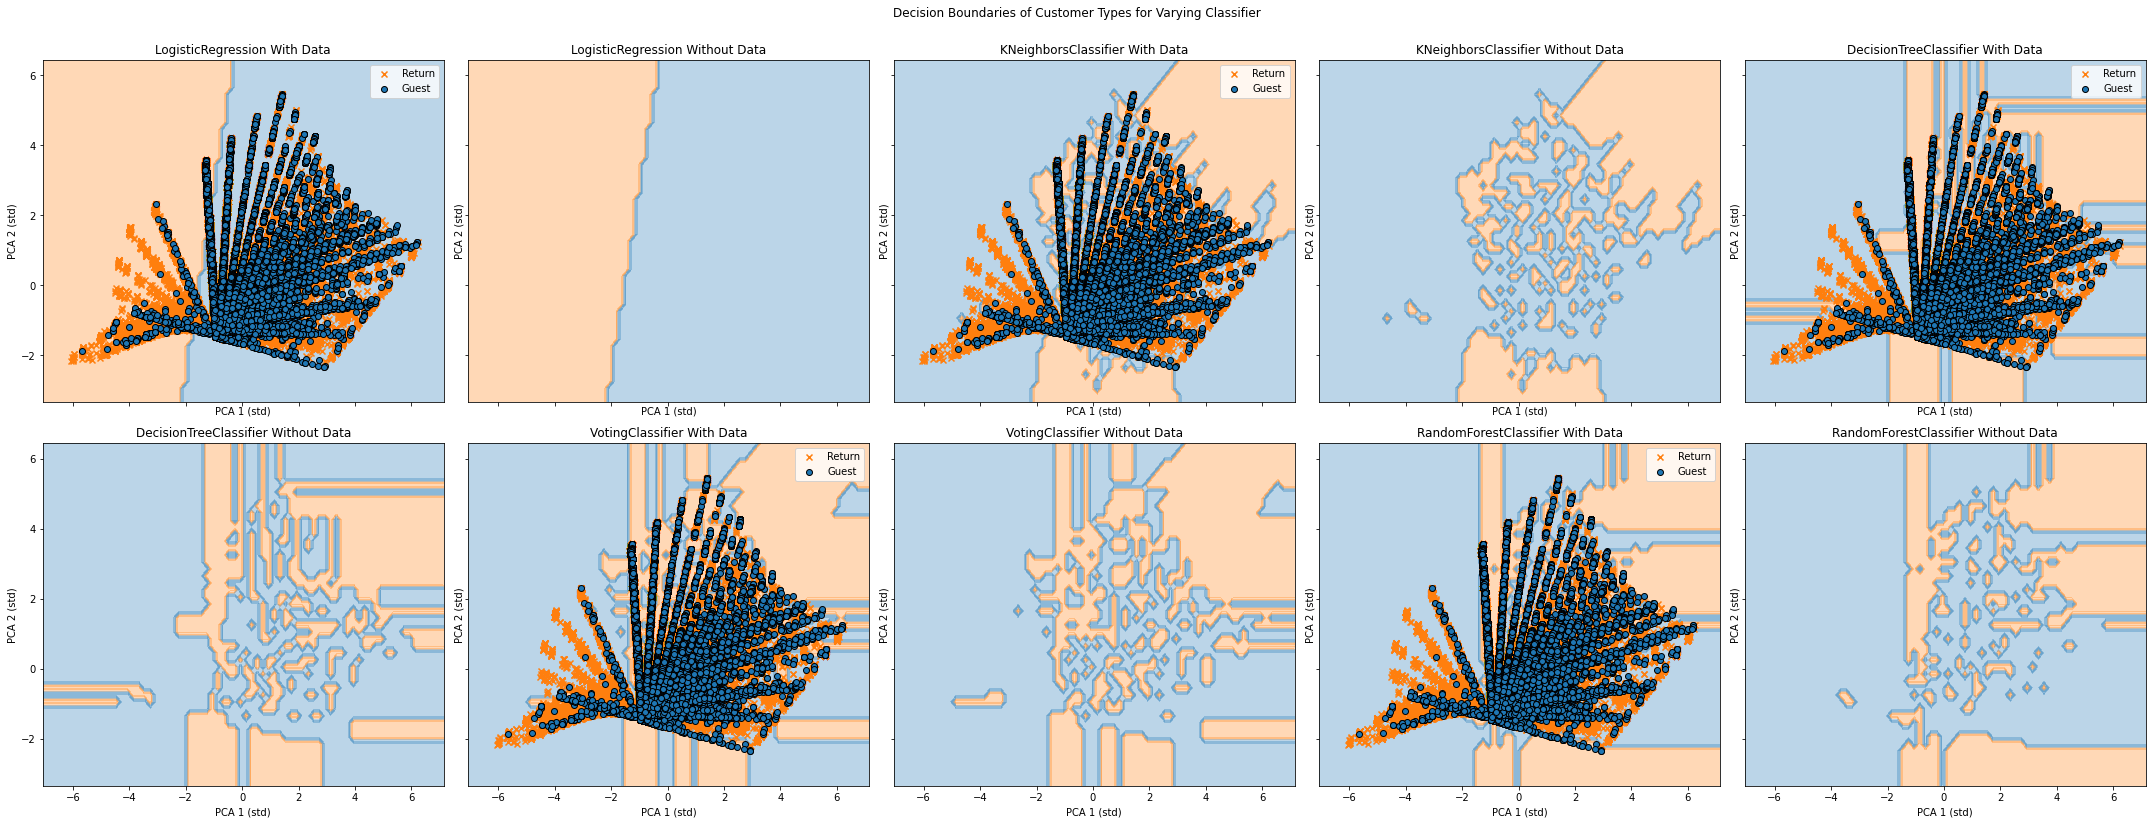

In [80]:
Decision_Regions(X_pca,y_combined,Classifier=best_CLF,resolution=0.2)

Overall the decision regions look less like swiss cheese, but they still exhibit some localization of Return and Guest Customers in their regions.

#### Section 4.3.3: Hyperparamterizated Classifiers Confusion Matrices<a name="section4.3.3"></a>
Now that we've seen the boundaries let us view the confusion matrices:

In [82]:
conf_mat(X_test,y_test,best_CLF)

True Percentage of Class Within Given Data Set
Guest  : 25.14
Return : 74.86

Confusion Matrix on Test Data Set for the Classifier 
LogisticRegression(C=0.1, random_state=0):


$\hat Y $ = Guest       $\hat Y $ = Return    
$Y  $ = Guest                         1.09                   24.05
$Y  $ = Return                        2.23                   72.63

Confusion Matrix on Test Data Set for the Classifier 
KNeighborsClassifier(n_neighbors=7, p=3, weights='distance'):


$\hat Y $ = Guest       $\hat Y $ = Return    
$Y  $ = Guest                        22.01                    3.13
$Y  $ = Return                        2.00                   72.86

Confusion Matrix on Test Data Set for the Classifier 
DecisionTreeClassifier(max_depth=36, random_state=0):


$\hat Y $ = Guest       $\hat Y $ = Return    
$Y  $ = Guest                        22.25                    2.89
$Y  $ = Return                        1.98                   72.88

Confusion Matrix on Test Data Set for the Classifier 
VotingClassifier(estimators=[('knn', KNeighborsClassifier(n_neighbors=7)),
                             ('tree',
                              DecisionTreeClassifier(class_weight='balanced',
                                                     random_state=0))],
                 voting='soft'):


$\hat Y $ = Guest       $\hat Y $ = Return    
$Y  $ = Guest                        22.41                    2.73
$Y  $ = Return                        2.34                   72.51

Confusion Matrix on Test Data Set for the Classifier 
RandomForestClassifier(max_depth=32, n_estimators=128, random_state=0):


$\hat Y $ = Guest       $\hat Y $ = Return    
$Y  $ = Guest                        22.14                    3.01
$Y  $ = Return                        1.83                   73.02

Not much changed for our Logistic Regression, Decision Tree, and Random Forest. KNN on the other hand saw an increase in correct Guest predictions and Return predictions, while Soft Majority Voting saw an increase on correct predictions for Guest Customers, but a drop off in correct predictions in Return Customers.

As it stands now, Random Forest is still our best classifier with Decision Trees nearing the same success. To determine which is ultimately the best classifier let us continue on to the rest of our testing metrics

#### Section 4.3.4: Hyperparamterizated Classifiers ROC Curves and AUC Scores<a name="section4.3.4"></a>
Continuing in the same fashion as done within **[Section 4.1: Base Classifiers](#section4.1)** and **[Section 4.2: Ensemble Methods](#section4.2)** for testing metrics let us observe the ROC Curves and AUC Scores:

10-fold Cross Validation AUC Scores on Trained Data:

LogisticRegression(C=0.1, random_state=0):
ROC AUC: 0.747698 (+/- 0.004565) 

KNeighborsClassifier(n_neighbors=7, p=3, weights='distance'):
ROC AUC: 0.956070 (+/- 0.002461) 

DecisionTreeClassifier(max_depth=36, random_state=0):
ROC AUC: 0.961670 (+/- 0.002065) 

VotingClassifier(estimators=[('knn', KNeighborsClassifier(n_neighbors=7)),
                             ('tree',
                              DecisionTreeClassifier(class_weight='balanced',
                                                     random_state=0))],
                 voting='soft'):
ROC AUC: 0.966860 (+/- 0.001496) 

RandomForestClassifier(max_depth=32, n_estimators=128, random_state=0):
ROC AUC: 0.971424 (+/- 0.001209) 



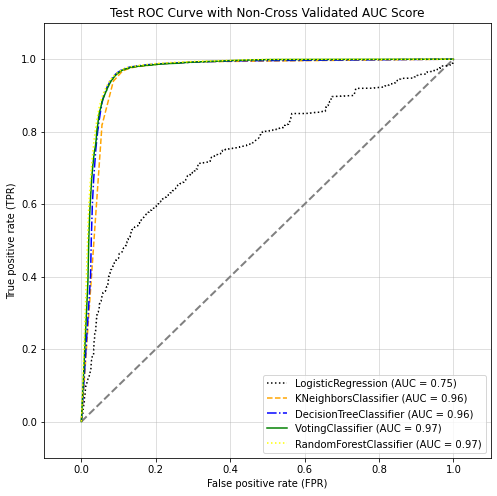

In [83]:
k_fold_cv_and_roc(X_train=X_train,y_train=y_train,
                        X_test=X_test,y_test=y_test,
                        CLF=best_CLF,k=10,scoring='roc_auc')

ROC AUC scores went up uniformly for all classifiers--as to be expected from our grid search. The Soft Majority Vote Classifier is close to the AUC of Random Forest, but by .5\%, while Decision Trees is nearly a whole percent behind on the training set. We're splitting hairs trying to determine the runner ups of AUC score for our classifiers when it is apparent that Random Forest is the winner. 

#### Section 4.3.5: Hyperparamterizated Classifiers Accuracy<a name="section4.3.5"></a>
For completion sake we will look at the accuracies of our classifiers and crown our best classifier:

In [84]:
accuracies(X=X_test,y=y_test,CLF=best_CLF)

Accuracies of Various Classifiers on Test Set:

LogisticRegression(C=0.1, random_state=0):
Accuracy: 73.72

KNeighborsClassifier(n_neighbors=7, p=3, weights='distance'):
Accuracy: 94.87

DecisionTreeClassifier(max_depth=36, random_state=0):
Accuracy: 95.13

VotingClassifier(estimators=[('knn', KNeighborsClassifier(n_neighbors=7)),
                             ('tree',
                              DecisionTreeClassifier(class_weight='balanced',
                                                     random_state=0))],
                 voting='soft'):
Accuracy: 94.92

RandomForestClassifier(max_depth=32, n_estimators=128, random_state=0):
Accuracy: 95.16



Here we see that KNN, Decision Trees, Soft Majority Voting, and Random Forest are within .5\% of one another in terms of accuracy. One could say that the difference between these machines are negligible. 

Accuracy went down for Decision Trees, and Majority Voting while going up for KNN only. Logistic Regression and Random Forest remained relatively the same.

#### Section 4.3.6: Hyperparamterizated Classifiers Conclusion<a name="section4.3.6"></a>
After all that time the hierarchy of classifiers remained the same. The benefits of hyperparameterizing did not yield far greater scores throughout our metrics, but this was a necessary step to ensure that we have the best classifier--where we technically did see some increases of our metrics for our lower tiered classifiers

In short, this may prove useful when considering a less computationally heavy classifier such as KNN or Decision Trees opposed to Random Forest.

Now that we've created our classifier we shall go to the clustering problem of our sold items by their descriptions.
## Section 5: Clustering to Determine Topics of Descriptions<a name="section5"></a>
Within EC, each item contains a description. Each description shares similarities with other descriptions, meaning certain items could be grouped up into a topic. The goal of this section is to cluster data base EC_trim on these similarities. Before we can get to there we must preprocessing EC_trim's Description column to get ready for some natural language processing (nlp).

### Section 5.1: Description Preprocessing<a name="section5.1"></a>
In this section, we will show the process necessary to prep our Description column of EC_trim to be used within the clustering algorithm Latent Dirichlet Allocation (LDA):

Within the next cell we remove special characters and punctuation from our Item Descriptions:

In [85]:
start_time = timer(None) # timing starts from this point for "start_time" variable
data_words = list(sent_to_words(EC_trim.Description))
timer(start_time) # timing ends here for "start_time" variable


Time taken: 0 hours 0 minutes and 6.11 seconds.



Here we lemmatize the data--reducing the descriptions to parts of speech (POS) by keeping Nouns, Adjectives, Verbs, and Adverbs:

In [86]:
# Do lemmatization keeping only Nouns, Proper Nouns, Adjectives, Verbs, Adverbs
start_time = timer(None) # timing starts from this point for "start_time" variable
data_lemmatized = lemmatization(data_words, allowed_postags=['NOUN', 'PROPN', 'ADJ', 'VERB', 'ADV'])
timer(start_time) # timing ends here for "start_time" variable


Time taken: 0 hours 11 minutes and 5.66 seconds.



Next we vectorize our lemmatized data so that it may be used within our LDA:

In [87]:
vectorizer = CountVectorizer(min_df=10,                        # minimum required occurences of a word 
                             stop_words='english',             # remove stop words
                             lowercase=True,                   # convert all words to lowercase
                             token_pattern='[a-zA-Z0-9]{3,}'   # Regex for num chars must be greater than 3
                             # max_features=50000,             # max number of uniq words
                            )

data_vectorized = vectorizer.fit_transform(data_lemmatized)
pickle.dump(vectorizer, open('vectorizer.pickle', 'wb'))
sci.sparse.save_npz('G:/Programs/Machine Learning/Data Science Projects/E Commerce/data_vectorized.npz', data_vectorized)

Before building the model let us see how sparce our vectorized data:

In [88]:
vectorizer = pickle.load(open('vectorizer.pickle', 'rb'))
data_vectorized = sci.sparse.load_npz('G:/Programs/Machine Learning/Data Science Projects/E Commerce/data_vectorized.npz')

""" This converts the vectorized data into a numpy array """
data_dense = data_vectorized.todense()

""" Compute Sparsicity = Percentage of Non-Zero cells """
print("Sparsicity: ", ((data_dense > 0).sum()/data_dense.size)*100, "%")

Sparsicity:  0.24701105130003867 %


### Section 5.2: Latent Dirichlet Allocation (LDA) of Description <a name="section5.2"></a>
Here we build a simple LDA with no hyperparamterization involved:

In [89]:
# Build LDA Model
lda_model = LatentDirichletAllocation(n_components=6,            # Number of topics
                                      learning_method='batch',   # Options: batch or online
                                      random_state=0,            # Random state
                                      batch_size=128,            # n docs in each learning iter
                                      evaluate_every = -1,       # compute perplexity every n iters, default: Don't
                                      n_jobs = -1,               # Use all available CPUs
                                     )

start_time = timer(None) # timing starts from this point for "start_time" variable
lda_output = lda_model.fit_transform(data_vectorized)
timer(start_time) # timing ends here for "start_time" variable

print(lda_model)  # Model attributes


Time taken: 0 hours 3 minutes and 18.97 seconds.

LatentDirichletAllocation(n_components=6, n_jobs=-1, random_state=0)


Next we look at the Log Likelihood from our LDA:

In [90]:
# Log Likelyhood: Higher the better
print("Log Likelihood: ", lda_model.score(data_vectorized))

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda_model.perplexity(data_vectorized))

# See model parameters
pprint(lda_model.get_params())

Log Likelihood:  -11048156.294668715
Perplexity:  299.78690655749733
{'batch_size': 128,
 'doc_topic_prior': None,
 'evaluate_every': -1,
 'learning_decay': 0.7,
 'learning_method': 'batch',
 'learning_offset': 10.0,
 'max_doc_update_iter': 100,
 'max_iter': 10,
 'mean_change_tol': 0.001,
 'n_components': 6,
 'n_jobs': -1,
 'perp_tol': 0.1,
 'random_state': 0,
 'topic_word_prior': None,
 'total_samples': 1000000.0,
 'verbose': 0}


### Section 5.3: Hyperparamterization of LDA by GridSearch<a name="section5.3"></a>
The Log Likelihood from our simple LDA model was shown to have 8 digits. This is a rather large log likelihood, let us see if we can improve this by a Grid Search.

<span style='color:red'>$\underline{\text{Caution}}:$</span>

If you wish to avoid running the below computation refer to **[Section 1.3.2: Processed Data and Models from Section 5](#section1.3.2)** for loading in the best lda model from disk.

In [91]:
# Define Search Param
n_topics = [10,12,15]
lda_params = {'n_components': n_topics, 'learning_decay': [.5, .7, .9]}

# Init the Model
lda = LatentDirichletAllocation(random_state=0)

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=lda_params,n_jobs=-1,verbose=3)

# Do the Grid Search
start_time = timer(None) # timing starts from this point for "start_time" variable
model.fit(data_vectorized)
timer(start_time) # timing ends here for "start_time" variable
""" Saves Best Clustering from GridSearch to Disk """
filename = 'best_'+model.best_estimator_.__class__.__name__+'.sav'
pickle.dump(model.best_estimator_, open(filename, 'wb'))

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed: 21.2min
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed: 59.6min finished



Time taken: 1 hours 6 minutes and 52.93 seconds.



Now let us observe the best models Log Likelihood:

In [92]:
lbl = 'LatentDirichletAllocation'
best_lda = pickle.load(open('best_'+lbl+'.sav', 'rb'))

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda.perplexity(data_vectorized))

Best Model's Params:  {'learning_decay': 0.5, 'n_components': 15}
Best Log Likelihood Score:  -2162374.7102948697
Model Perplexity:  236.12436250348372


We were able to reduce the likehood of our based model to approximately ~19\% of its original size.

Let us now observe the the gridsearch score averages per topic and learning rate:

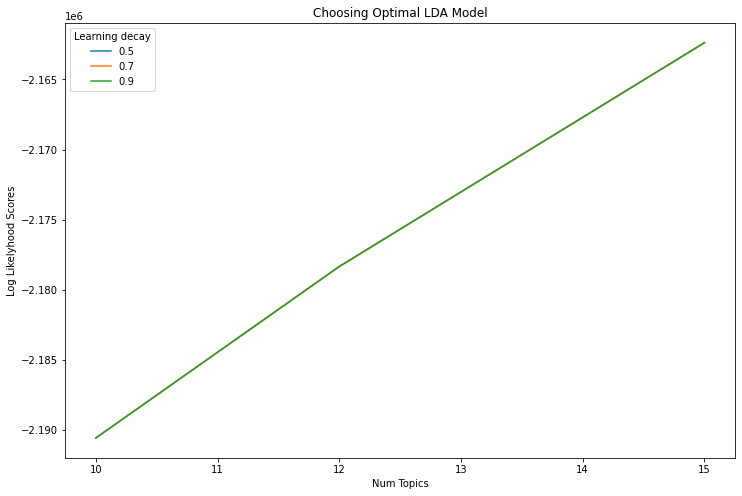

In [93]:
# Get Log Likelyhoods from Grid Search Output
log_likelyhoods_5 = [round(gscore) for i,gscore in enumerate(model.cv_results_['mean_test_score']) 
                     if model.cv_results_['params'][i]['learning_decay']==0.5]
log_likelyhoods_7 = [round(gscore) for i,gscore in enumerate(model.cv_results_['mean_test_score']) 
                     if model.cv_results_['params'][i]['learning_decay']==0.7]
log_likelyhoods_9 = [round(gscore) for i,gscore in enumerate(model.cv_results_['mean_test_score']) 
                     if model.cv_results_['params'][i]['learning_decay']==0.9]

# Show graph
plt.figure(figsize=(12, 8))
plt.plot(n_topics, log_likelyhoods_5, label='0.5')
plt.plot(n_topics, log_likelyhoods_7, label='0.7')
plt.plot(n_topics, log_likelyhoods_9, label='0.9')
plt.title("Choosing Optimal LDA Model")
plt.xlabel("Num Topics")
plt.ylabel("Log Likelyhood Scores")
plt.legend(title='Learning decay', loc='best')
plt.show()

The graph here can be misleading, but there is indeed 3 Learning Decays being comapred. The margin in which they are measured is so small that it's hard to distinguish using normal graphing means. That being said we do have a distinct winner as observed 2 cells prior.

### Section 5.4: Results<a name="section5.4"></a>
Next let us observe the probabilities of each product in which cluster they belong to, and view there dominant topic:

In [94]:
lbl = 'LatentDirichletAllocation'
best_lda = pickle.load(open('best_'+lbl+'.sav', 'rb'))
vectorizer = pickle.load(open('vectorizer.pickle', 'rb'))

# Create Document - Topic Matrix
lda_output = best_lda.transform(data_vectorized)

# column names
topicnames = ["Topic" + str(i) for i in range(best_lda.n_components)]

# index names
docnames = ["Product" + str(i) for i in range(len(EC_trim))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(lda_output*100, columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

# Apply Style
df_document_topics = df_document_topic.head(10).style.applymap(color_green).applymap(make_bold)
df_document_topics

Let us see the type of distribution we can observe from our topics:

In [95]:
df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic Num', 'Num Documents']
df_topic_distribution

Topic Num  Num Documents
0           1          51688
1           9          47776
2           6          39239
3           4          38528
4           2          33405
5          13          32231
6          10          31179
7           8          30035
8           5          29195
9           3          28796
10         14          27708
11         12          25736
12          7          25425
13          0          25108
14         11          22898

The number of documents spread throughout the topic number is relatively the same. There are some highs with Topic Number 1, 9, and 6.

Let us view the top 10 words of each topic. To see how this is constructed reference the function show_topics in **[Section 1.2.3: Functions for Section 5](#section1.2.3)**.

In [96]:
topic_keywords = show_topics(vectorizer=vectorizer, lda_model=best_lda, n_words=10)        

# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

Word 0     Word 1     Word 2       Word 3     Word 4    Word 5  \
Topic 0          box    trinket        tin      ceramic       gift     lunch   
Topic 1        metal       sign      light        heart     holder      hang   
Topic 2   decoration     wooden      union        heart  christmas      jack   
Topic 3       ribbon      green    regency         wall       reel    saucer   
Topic 4         card      paper    bunting     birthday        kit    drawer   
Topic 5         cake       pack       case        fairy    vintage    tissue   
Topic 6          bag     design      lunch     spaceboy      dolly      girl   
Topic 7        white       wrap      frame        clock      alarm  bakelike   
Topic 8          set       home    cushion         wood      sweet   vintage   
Topic 9          bag        red  retrospot        jumbo       pink  polkadot   
Topic 10         set       pink       rose        light    english     heart   
Topic 11         set      doily      skull  traditional     cookie    cutter   
Topic 12         mug  retrospot        red          tea        box    coffee   
Topic 13         set      heart     candle          red      party      bird   
Topic 14         tin      heart      large       wicker        box    pantry   

             Word 6     Word 7      Word 8     Word 9  
Topic 0      circus     parade  strawberry    biscuit  
Topic 1      bottle        hot       glass      water  
Topic 2      garden       tree        blue    vintage  
Topic 3         set  christmas      teacup        art  
Topic 4   christmas       knob      travel    vintage  
Topic 5      design       leaf       stand        set  
Topic 6       jumbo  feltcraft        suki      slate  
Topic 7       black     london       photo    vintage  
Topic 8         egg      paper       white     napkin  
Topic 9     vintage    paisley      pencil       tube  
Topic 10      plate    regency      garden       rise  
Topic 11      heart  butterfly       paper     wooden  
Topic 12        set    doormat      candle     design  
Topic 13       love    gingham        pink  christmas  
Topic 14        set     design       small    plaster

Within the topics there are some redundancy, but outside the redundancy there is word association generated. Perhaps it would be better to limit the quantity of topics opposed to running through a hyperparamterized LDA if words are desired to be unique to a topic. Though, this only an observation. We will proceed forward with these topics given to us by LDA.

We will now create a new column labeled Topic within EC_trim by choosing the dominant topic from LDA of each item sold.

In [97]:
EC_trim.InvoiceDate = EC_trim.InvoiceDate.astype('datetime64')
EC_trim['Topic'] = df_document_topic.dominant_topic.apply(lambda x: 'Topic '+str(x)).values
EC_trim

InvoiceNo StockCode                          Description  Quantity  \
0         536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1         536365     71053                  WHITE METAL LANTERN         6   
2         536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3         536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4         536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   
...          ...       ...                                  ...       ...   
541904    581587     22613          PACK OF 20 SPACEBOY NAPKINS        12   
541905    581587     22899         CHILDREN'S APRON DOLLY GIRL          6   
541906    581587     23254        CHILDRENS CUTLERY DOLLY GIRL          4   
541907    581587     23255      CHILDRENS CUTLERY CIRCUS PARADE         4   
541908    581587     22138        BAKING SET 9 PIECE RETROSPOT          3   

               InvoiceDate  UnitPrice CustomerID         Country  Month  \
0      2010-12-01 08:26:00       2.55      17850  United Kingdom     12   
1      2010-12-01 08:26:00       3.39      17850  United Kingdom     12   
2      2010-12-01 08:26:00       2.75      17850  United Kingdom     12   
3      2010-12-01 08:26:00       3.39      17850  United Kingdom     12   
4      2010-12-01 08:26:00       3.39      17850  United Kingdom     12   
...                    ...        ...        ...             ...    ...   
541904 2011-12-09 12:50:00       0.85      12680          France     12   
541905 2011-12-09 12:50:00       2.10      12680          France     12   
541906 2011-12-09 12:50:00       4.15      12680          France     12   
541907 2011-12-09 12:50:00       4.15      12680          France     12   
541908 2011-12-09 12:50:00       4.95      12680          France     12   

              Date  GrossIncome CustomerType     Topic  
0       2010-12-01        15.30       Return   Topic 1  
1       2010-12-01        20.34       Return   Topic 1  
2       2010-12-01        22.00       Return   Topic 4  
3       2010-12-01        20.34       Return   Topic 1  
4       2010-12-01        20.34       Return  Topic 13  
...            ...          ...          ...       ...  
541904  2011-12-09        10.20       Return   Topic 5  
541905  2011-12-09        12.60       Return   Topic 6  
541906  2011-12-09        16.60       Return   Topic 6  
541907  2011-12-09        16.60       Return   Topic 0  
541908  2011-12-09        14.85       Return   Topic 8  

[488947 rows x 13 columns]

### Section 5.5: Visualizing LDA<a name="section5.5"></a>
Outside of the view of words we can visualize the LDA output of our vectorized dataset. This can be done by utilizing a Principal Component Analysis, as well as seaborn's pairplot.

Here we apply PCA to our LDA output:

In [99]:
PCA_model = PCA().fit(lda_output)
lda_output_PCA = PCA_model.transform(lda_output)

Next we evaluate the screeplots/explained variance of our components:

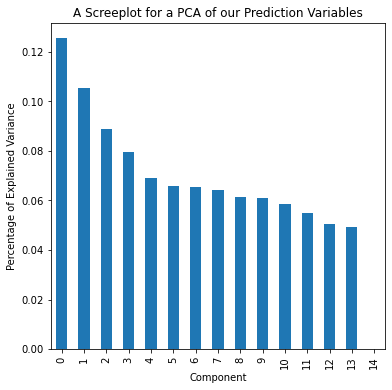

In [100]:
explained_variance_ratio = pd.DataFrame(PCA_model.explained_variance_ratio_)

""" Plots the Percentage of Explained Variance for the our Principal Components  """
fig,ax = plt.subplots(figsize=(6,6))
ax = explained_variance_ratio.plot.bar(legend=False,ax=ax)
ax.set_xlabel('Component')
ax.set_ylabel('Percentage of Explained Variance')
ax.set_title('A Screeplot for a PCA of our Prediction Variables')
plt.show()

Though the last component appears insignficant we will still supply a visual in our pairplot.

For now we will define a data frame from Principal Components of our LDA output. This is so that we may use seaborn's pairplot.

In [101]:
X = lda_output_PCA
df = pd.DataFrame(X)
cols = ['Component '+str(i) for i in range(best_lda.n_components)]
df.columns = cols
df['Topic'] = EC_trim.Topic.values
df

Cluster 0  Cluster 1  Cluster 2  Cluster 3  Cluster 4  Cluster 5  \
0            0.75       0.17       0.07       0.05       0.01       0.01   
1            0.67       0.15       0.06       0.04       0.01       0.01   
2           -0.07      -0.18      -0.41       0.65       0.03       0.05   
3            0.50       0.09       0.03       0.01       0.00      -0.03   
4           -0.05      -0.08      -0.08      -0.16      -0.22      -0.42   
...           ...        ...        ...        ...        ...        ...   
488942      -0.07      -0.07      -0.04      -0.16      -0.07       0.11   
488943      -0.12      -0.29       0.66       0.22       0.03       0.01   
488944      -0.12      -0.29       0.66       0.22       0.03       0.01   
488945      -0.05      -0.07      -0.03      -0.06      -0.04      -0.02   
488946      -0.06      -0.08      -0.09      -0.21       0.72       0.03   

        Cluster 6  Cluster 7  Cluster 8  Cluster 9  Cluster 10  Cluster 11  \
0            0.01      -0.00      -0.01      -0.01       -0.00       -0.01   
1            0.01      -0.00      -0.01      -0.01       -0.00       -0.00   
2           -0.02      -0.03      -0.06      -0.04       -0.03       -0.02   
3            0.06       0.03       0.13       0.20       -0.07       -0.04   
4           -0.45      -0.33      -0.24       0.10       -0.09       -0.04   
...           ...        ...        ...        ...         ...         ...   
488942       0.48      -0.45      -0.09      -0.13       -0.13       -0.07   
488943      -0.03       0.00      -0.02      -0.02       -0.03       -0.01   
488944      -0.03       0.00      -0.02      -0.02       -0.03       -0.01   
488945       0.04       0.02       0.03       0.02        0.06        0.26   
488946      -0.13      -0.02      -0.07      -0.03       -0.06       -0.04   

        Cluster 12  Cluster 13  Cluster 14     Topic  
0            -0.01       -0.01       -0.00   Topic 1  
1            -0.01       -0.01       -0.00   Topic 1  
2            -0.02       -0.02       -0.00   Topic 4  
3            -0.04       -0.03       -0.00   Topic 1  
4            -0.04       -0.03       -0.00  Topic 13  
...            ...         ...         ...       ...  
488942       -0.04       -0.02        0.00   Topic 5  
488943       -0.03       -0.01       -0.00   Topic 6  
488944       -0.03       -0.01       -0.00   Topic 6  
488945        0.68       -0.26        0.00   Topic 0  
488946       -0.01       -0.03       -0.00   Topic 8  

[488947 rows x 16 columns]

In addition to the Principal Components we tact on the dominant topic, so that it may be present in the following pairplot:

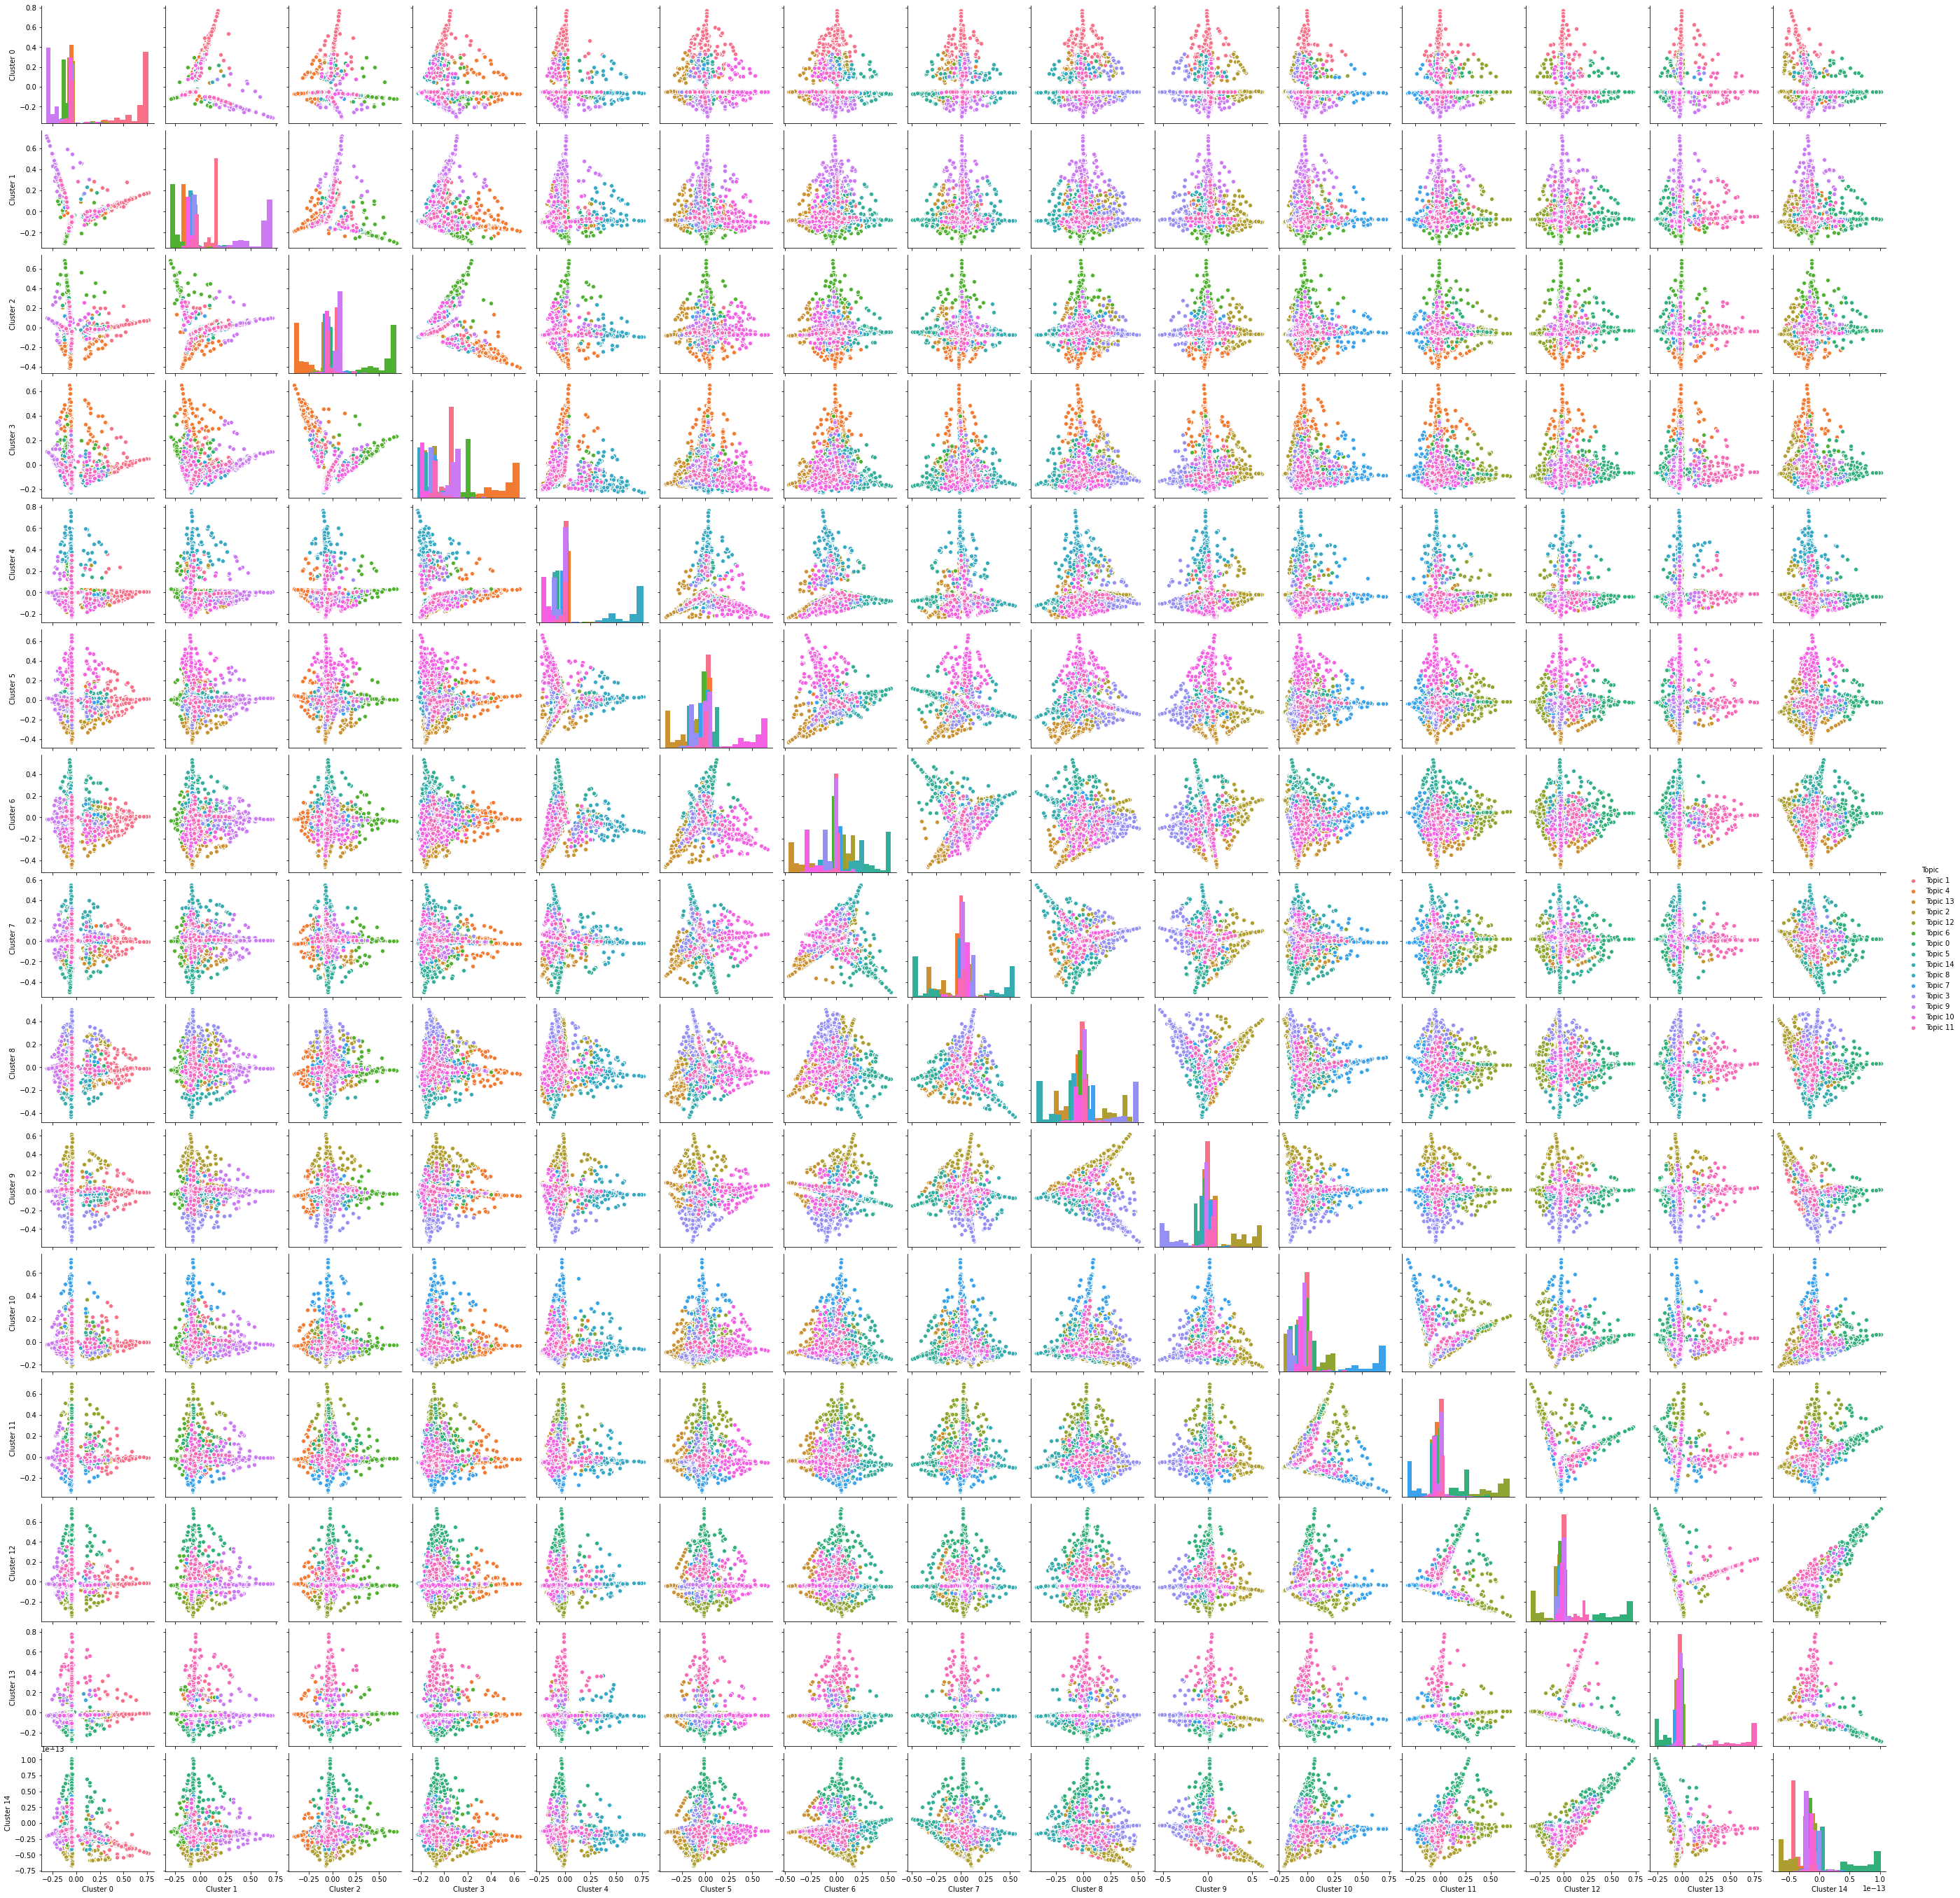

In [102]:
sns.pairplot(data=df,hue='Topic',diag_kind="hist")
plt.show()

From above if a topic is desired to be isolated there surely will be one or more combinations of the above pairs of our principal components that would distinguish our topic in a classifier.

## Section 6: Multiple Linear Regression of Daily Income From Sales<a name="section6"></a>
Now that we've found the optimal number of topics to allow for differentiation between items sold (e.g. topics), we wish to project how much money the company will make by sales. Of course it is simple to do this by simply aggregating the sum of GrossIncome by date. Though the goal of this is to have a fair estimate of Income by sales so that the company may better asses the ordering of future inventory. This of course leads us to the problem of regression.

### Section 6.1: Aggregating the Sales by Date<a name="section6.1"></a>
We attend to add the sum of sales by **CustomerType** (Return and Guest), **Topic** (Topic $i$ for $i=1,\dots,\text{best_lda.n_components}$) and Gross Income. This is of course grouped by the Date. We shall refer to this as a new dataset known as Sale_Aggregated.

We also plan to introduce a new feature to Sale_Aggregated called Quarter--which indicates the quarters of the year in which the entry date falls in.

In [103]:
Sale_Aggregated = EC_trim[['Date','Topic','Quantity','GrossIncome']].groupby(['Date','Topic']).agg({'Quantity':'sum','GrossIncome':'sum'}).unstack(level=1).fillna(0)
Sale_Aggregated = Sale_Aggregated['Quantity']
Sale_Aggregated1 = EC_trim[['Date','CustomerType','Quantity','GrossIncome']].groupby(['Date','CustomerType']).agg({'Quantity':'sum','GrossIncome':'sum'}).unstack(level=1).fillna(0)
Sale_Aggregated1 = Sale_Aggregated1['Quantity']
Sale_Aggregated['Guest'] = Sale_Aggregated1.Guest
Sale_Aggregated['Return'] = Sale_Aggregated1.Return
Sale_Aggregated['DailyIncome'] = EC_trim[['Date','GrossIncome']].groupby('Date').agg({'GrossIncome':'sum'})
Sale_Aggregated['Quarter'] = ['Quarter '+str(x) for x in pd.to_datetime(pd.Series(Sale_Aggregated.index)).dt.quarter]
Sale_Aggregated = pd.get_dummies(Sale_Aggregated)
Sale_Aggregated

Topic 0  Topic 1  Topic 10  Topic 11  Topic 12  Topic 13  \
Date                                                                   
2010-12-01      836     1561       646       505       597      1169   
2010-12-02      450     1578       542       452       658      1250   
2010-12-03      422      976       642       356       504       772   
2010-12-05      530     1197       604       550       718      1072   
2010-12-06      521     1583       872       692       651      1283   
...             ...      ...       ...       ...       ...       ...   
2011-12-05     1043     2678      1902      1134      1217      2425   
2011-12-06      689     1947      1469       662      1009      1747   
2011-12-07      658     1507      1099       783       902      1240   
2011-12-08      667     1945      1759       843      1208      1518   
2011-12-09      407      852       672       266       548       534   

            Topic 14  Topic 2  Topic 3  Topic 4  ...  Topic 7  Topic 8  \
Date                                             ...                     
2010-12-01       530     1056      573      970  ...      851      772   
2010-12-02       377     1016      696     1426  ...      984      856   
2010-12-03       426      619      472      763  ...      385      547   
2010-12-05       590     1187      527      842  ...      622      465   
2010-12-06       660     1510      720     1040  ...     1036      829   
...              ...      ...      ...      ...  ...      ...      ...   
2011-12-05      1106     2075     1384     1705  ...     1389     1941   
2011-12-06       791     1414      667     1241  ...     1088      779   
2011-12-07       850      957      799     1248  ...     1057     1172   
2011-12-08       917     1740     1151     1655  ...     1038     1223   
2011-12-09       321      614      463      507  ...      630      363   

            Topic 9    Guest    Return  DailyIncome  Quarter_Quarter 1  \
Date                                                                     
2010-12-01      985 2,376.00 11,083.00    29,226.43                  0   
2010-12-02     1171   185.00 13,087.00    24,692.53                  0   
2010-12-03      764 2,546.00  6,370.00    20,879.53                  0   
2010-12-05      626     1.00 11,234.00    21,514.90                  0   
2010-12-06     1072 4,540.00  9,918.00    33,680.55                  0   
...             ...      ...       ...          ...                ...   
2011-12-05     2259 4,612.00 20,785.00    49,519.98                  0   
2011-12-06     1797 1,742.00 15,814.00    28,029.06                  0   
2011-12-07     1746   501.00 16,018.00    25,724.45                  0   
2011-12-08     1728 5,741.00 14,943.00    41,093.25                  0   
2011-12-09      746 2,553.00  5,304.00    16,903.29                  0   

            Quarter_Quarter 2  Quarter_Quarter 3  Quarter_Quarter 4  
Date                                                                 
2010-12-01                  0                  0                  1  
2010-12-02                  0                  0                  1  
2010-12-03                  0                  0                  1  
2010-12-05                  0                  0                  1  
2010-12-06                  0                  0                  1  
...                       ...                ...                ...  
2011-12-05                  0                  0                  1  
2011-12-06                  0                  0                  1  
2011-12-07                  0                  0                  1  
2011-12-08                  0                  0                  1  
2011-12-09                  0                  0                  1  

[305 rows x 22 columns]

### Section 6.2: Scatter Plots of Income Over Various Sales<a name="section6.2"></a>
To confirm the obvious correlation, let us examine the scatter plots of our DailyIncome over our sales:

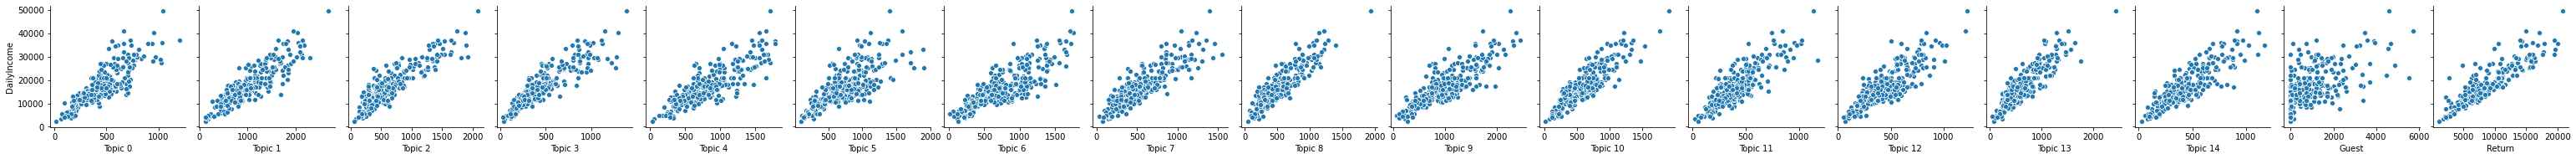

In [104]:
sns.pairplot(data=Sale_Aggregated,y_vars=['DailyIncome'],x_vars=['Topic '+str(i) for i in range(15)]+['Guest','Return'])
plt.show()

The only irregularity seen is for Guest Customers within the lower sale values.

### Section 6.3: Multiple Linear Regression<a name="section6.3"></a>
Now that we've observe the correlation betwen our variables and income we will now try to fit a multiple linear regression to our DailyIncome using our sales.

#### Section 6.3.1: Predictors and Outcome<a name="section6.3.1"></a>
We first establish a base model labeled LinReg that uses all features presented in Sale_Aggregated. To do this properly we will split our data into training and test data:

In [105]:
outcome = 'DailyIncome'
predictors = [x for x in Sale_Aggregated.columns if outcome not in x]
predictors
X = Sale_Aggregated[predictors]
y = Sale_Aggregated[outcome]
""" Seperating Training and Testing Sets: Note variables are Standardized """
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.6,random_state=0)

#### Section 6.3.2: Ordinary Multiple Linear Regression Model and Step Wise Selected Model<a name="section6.3.2"></a>
Now that we've split the data we will now perform the regression and observe the weights of each feature:

In [107]:
LinReg = LinearRegression().fit(X_train,y_train.values)
print('{:<13} : {:<30.3f}\n'.format('Intercept',LinReg.intercept_))
print('{:<13}'.format('Coefficients'))
for name,coef in zip(X.columns,LinReg.coef_):
    print('{:<13} : {:<30.3f}'.format(name,coef))

Intercept     : 785.814                       

Coefficients 
Topic 0       : 0.861                         
Topic 1       : 1.707                         
Topic 10      : -1.660                        
Topic 11      : 0.898                         
Topic 12      : -0.121                        
Topic 13      : -0.635                        
Topic 14      : 1.132                         
Topic 2       : -2.057                        
Topic 3       : 3.286                         
Topic 4       : 1.868                         
Topic 5       : -0.807                        
Topic 6       : 1.781                         
Topic 7       : -0.641                        
Topic 8       : -1.183                        
Topic 9       : -0.581                        
Guest         : 2.486                         
Return        : 1.362                         
Quarter_Quarter 1 : -65.135                       
Quarter_Quarter 2 : -251.887                      
Quarter_Quarter 3 : -831.785         

Each feature within the topic listing represents a sale of an item that belongs to said Topic. Meaning within this interpretation we see that certain Topics have a negative weight which would indicate that items sold from these topic represent a loss for the company. This can't be true since to the human eye a sale represents a profit. This is akin to the 'bedroom' phenomenon found within real estate data, where for multiple linear regression models an increase in bedrooms would suggest a decrease in market price for the house itself.

In hopes of reducing the complexity of the model and potentially removing some of these negative qualities we look to the regression model OLS (oridinary least squares) in the statsmodel library to shed some light on the importance of each feature by the p-values given:

In [108]:
model = sm.OLS(y_train,X_train[predictors].assign(const=1))
result_original = model.fit()
result_original.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            DailyIncome   R-squared:                       0.981
Model:                            OLS   Adj. R-squared:                  0.977
Method:                 Least Squares   F-statistic:                     273.1
Date:                Sun, 24 Jan 2021   Prob (F-statistic):           1.70e-78
Time:                        21:29:53   Log-Likelihood:                -1022.4
No. Observations:                 122   AIC:                             2085.
Df Residuals:                     102   BIC:                             2141.
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Topic 0               0.8610      1.096      0.786      0.434      -1.312       3.034
Topic 1               1.7070      0.523      3.266      0.001       0.670       2.744
Topic 10             -1.6595      0.825     -2.011      0.047      -3.296      -0.023
Topic 11              0.8983      1.256      0.715      0.476      -1.592       3.389
Topic 12             -0.1210      0.983     -0.123      0.902      -2.071       1.829
Topic 13             -0.6345      0.816     -0.777      0.439      -2.254       0.985
Topic 14              1.1325      1.058      1.071      0.287      -0.966       3.231
Topic 2              -2.0570      0.846     -2.430      0.017      -3.736      -0.378
Topic 3               3.2861      1.019      3.225      0.002       1.265       5.307
Topic 4               1.8677      0.748      2.495      0.014       0.383       3.352
Topic 5              -0.8075      0.587     -1.377      0.172      -1.971       0.356
Topic 6               1.7806      0.703      2.533      0.013       0.386       3.175
Topic 7              -0.6414      0.932     -0.688      0.493      -2.490       1.207
Topic 8              -1.1834      1.237     -0.957      0.341      -3.637       1.271
Topic 9              -0.5813      0.601     -0.967      0.336      -1.773       0.611
Guest                 2.4861      0.132     18.763      0.000       2.223       2.749
Return                1.3615      0.067     20.367      0.000       1.229       1.494
Quarter_Quarter 1    92.0275    235.567      0.391      0.697    -375.218     559.273
Quarter_Quarter 2   -94.7243    248.379     -0.381      0.704    -587.382     397.933
Quarter_Quarter 3  -674.6226    242.064     -2.787      0.006   -1154.755    -194.490
Quarter_Quarter 4  1305.9705    349.418      3.738      0.000     612.902    1999.039
const               628.6511    289.196      2.174      0.032      55.033    1202.269
==============================================================================
Omnibus:                        0.239   Durbin-Watson:                   1.843
Prob(Omnibus):                  0.888   Jarque-Bera (JB):                0.232
Skew:                          -0.100   Prob(JB):                        0.890
Kurtosis:                       2.926   Cond. No.                     9.29e+19
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.44e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

From the above, if we were to consider p-values less than 0.05 as a signficant feature then we would yield the following features to use within our regression: Topic 1, Topic 2, Topic 3, Topic 4, Topic 6, Topic 10, Guest, Return, Quarter_Quarter 3, Quarter_Quarter 4.

We will automate this process using a step wise selection from the dmba python package. It should be noted that we are using the functions train_model, score_model found in **[Section 1.2.4: Functions for Section 6](#section1.2.4)**

In [109]:
LinReg_stepwise, best_variables = stepwise_selection(predictors,train_model,score_model,verbose=True)

print('\n{:<26} : {:<30.3f}\n'.format('Intercept',LinReg_stepwise.intercept_))
print('{:<26}'.format('Coefficients'))
for name,coef in zip(best_variables,LinReg_stepwise.coef_):
    print('{:<26} : {:<30.3f}'.format(name,coef))

Variables: Topic 0, Topic 1, Topic 10, Topic 11, Topic 12, Topic 13, Topic 14, Topic 2, Topic 3, Topic 4, Topic 5, Topic 6, Topic 7, Topic 8, Topic 9, Guest, Return, Quarter_Quarter 1, Quarter_Quarter 2, Quarter_Quarter 3, Quarter_Quarter 4
Start: score=2530.50, constant
Step: score=2301.69, add Topic 8
Step: score=2239.95, add Topic 6
Step: score=2208.15, add Topic 1
Step: score=2175.56, add Guest
Step: score=2111.83, add Return
Step: score=2098.43, add Quarter_Quarter 4
Step: score=2091.15, add Topic 3
Step: score=2085.43, add Quarter_Quarter 3
Step: score=2081.36, add Topic 4
Step: score=2077.58, add Topic 2
Step: score=2075.59, remove Topic 8
Step: score=2075.31, add Topic 10
Step: score=2075.31, unchanged None

Intercept                  : 799.415                       

Coefficients              
Topic 6                    : 1.822                         
Topic 1                    : 1.861                         
Guest                      : 2.239                         
Return

As detailed earlier the removal of features led to a less complex model, but it did not alter sign of our negative weights. To be fair, sales within the third quarter should be naturally lower then that of the 4th quarter (holiday season), but our primary goal was to remove negative weights of the sales of Topic 2 and Topic 10. Let us once again utilizes statsmodels's OLS to see if the features from stepwise selection are all meaninful:

In [110]:
model = sm.OLS(y_train,X_train[best_variables].assign(const=1))
result_stepwise = model.fit()
result_stepwise.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            DailyIncome   R-squared:                       0.980
Model:                            OLS   Adj. R-squared:                  0.978
Method:                 Least Squares   F-statistic:                     534.5
Date:                Sun, 24 Jan 2021   Prob (F-statistic):           5.70e-89
Time:                        21:29:54   Log-Likelihood:                -1025.7
No. Observations:                 122   AIC:                             2073.
Df Residuals:                     111   BIC:                             2104.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Topic 6               1.8216      0.623      2.922      0.004       0.586       3.057
Topic 1               1.8608      0.515      3.611      0.000       0.840       2.882
Guest                 2.2385      0.178     12.595      0.000       1.886       2.591
Return                1.1308      0.139      8.114      0.000       0.855       1.407
Quarter_Quarter 4  1221.5640    403.414      3.028      0.003     422.172    2020.956
Topic 3               3.4577      0.980      3.528      0.001       1.516       5.400
Quarter_Quarter 3  -772.3341    277.347     -2.785      0.006   -1321.915    -222.753
Topic 4               1.9463      0.710      2.743      0.007       0.540       3.353
Topic 2              -1.9247      0.750     -2.567      0.012      -3.410      -0.439
Topic 10             -1.1550      0.799     -1.445      0.151      -2.738       0.428
const               799.4147    295.296      2.707      0.008     214.265    1384.564
==============================================================================
Omnibus:                        0.308   Durbin-Watson:                   1.773
Prob(Omnibus):                  0.857   Jarque-Bera (JB):                0.107
Skew:                          -0.062   Prob(JB):                        0.948
Kurtosis:                       3.074   Cond. No.                     4.11e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.11e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Surprisingly Topic 10 has shown to have loss signficance, and was shown in our prevous model to hold signficance by p-value virtue. Rather than removing it we'd like to leave it intact for now.

Let us now move on to the comparison of the original model to our step wise selected model.

#### Section 6.3.3: Comparing Original vs Step Wise<a name="section6.3.3"></a>
Here we compare the graphs of our predictions of Daily Income superimposed on the actual Daily Income of our two models, as well as the residuals. Followed by observation of the metrics of $R^2$ and **RMSE.**

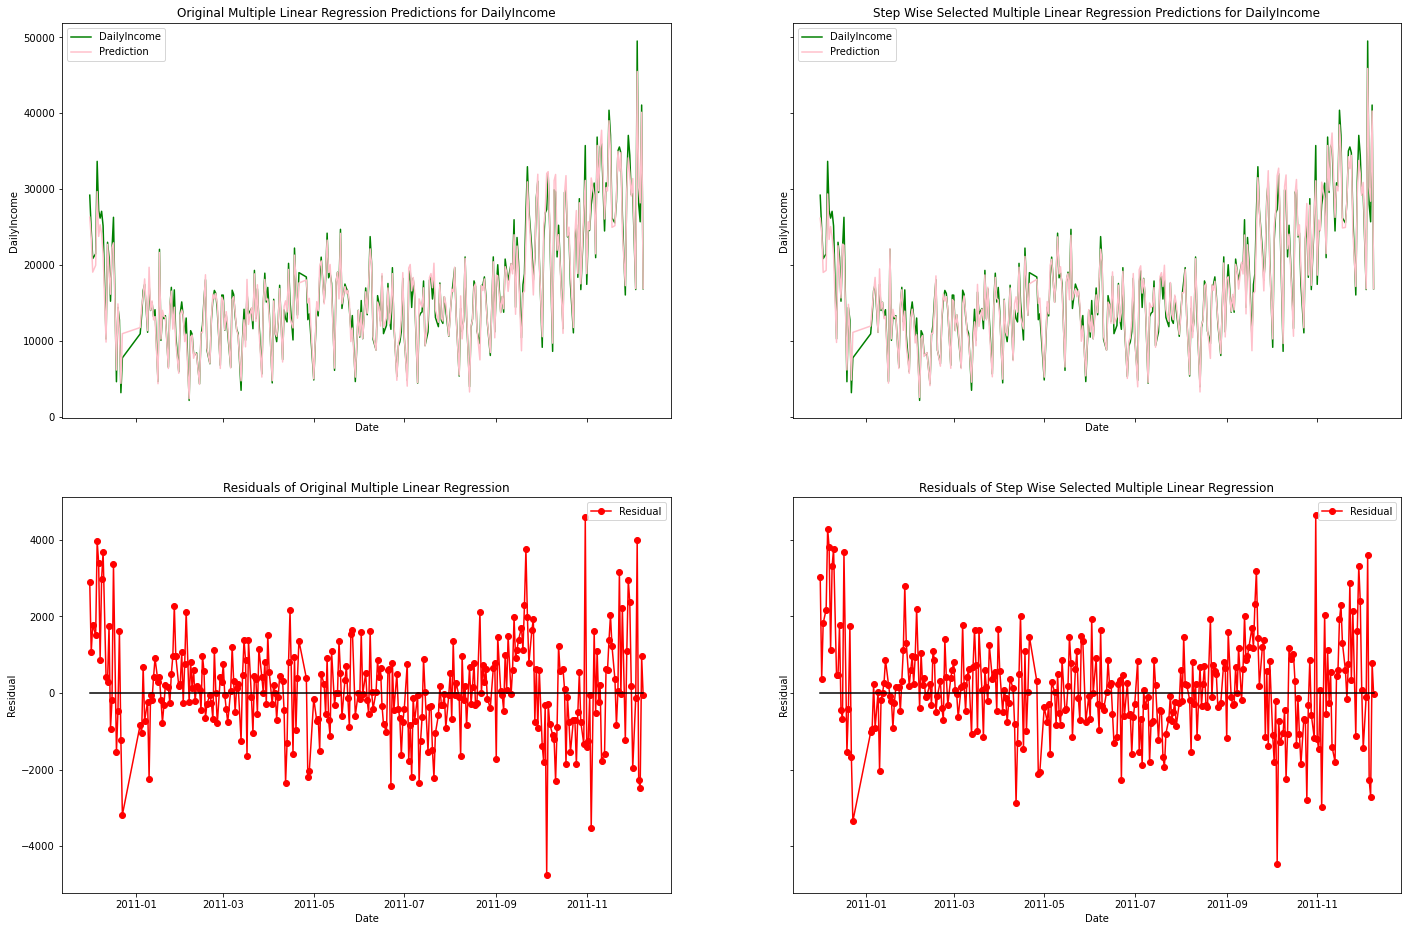

In [111]:
l,r = 0,len(Sale_Aggregated)
fig,ax = plt.subplots(figsize=(24,16),nrows=2,ncols=2,sharey='row',sharex=True)
ax = ax.flatten()
regs = [LinReg,LinReg_stepwise]
preds = [X.columns,best_variables]
lbls = ['Original', 'Step Wise Selected']

for i in range(2):
    ax[i].plot(Sale_Aggregated.index[l:r],Sale_Aggregated[outcome][l:r],'-g',label='DailyIncome')
    ax[i].plot(Sale_Aggregated.index[l:r],regs[i].predict(X[preds[i]])[l:r],'pink',label='Prediction')
    ax[i].set_title(lbls[i]+' Multiple Linear Regression Predictions for DailyIncome')
    ax[i].set_xlabel('Date')
    ax[i].set_ylabel('DailyIncome')
    ax[i].legend()

    ax[i+2].plot(Sale_Aggregated.index[l:r],Sale_Aggregated[outcome][l:r]-regs[i].predict(X[preds[i]])[l:r],'-or',label='Residual')
    ax[i+2].plot(Sale_Aggregated.index[l:r],np.zeros(r-l),'-k')
    ax[i+2].set_title('Residuals of '+lbls[i]+' Multiple Linear Regression')
    ax[i+2].set_xlabel('Date')
    ax[i+2].set_ylabel('Residual')
    ax[i+2].legend()
plt.show()

The two graphs seem nearly identical with small variation between residuals as highlighted within the tails of the regression. Let us plot Residuals over predictions to see where the regression fails at:

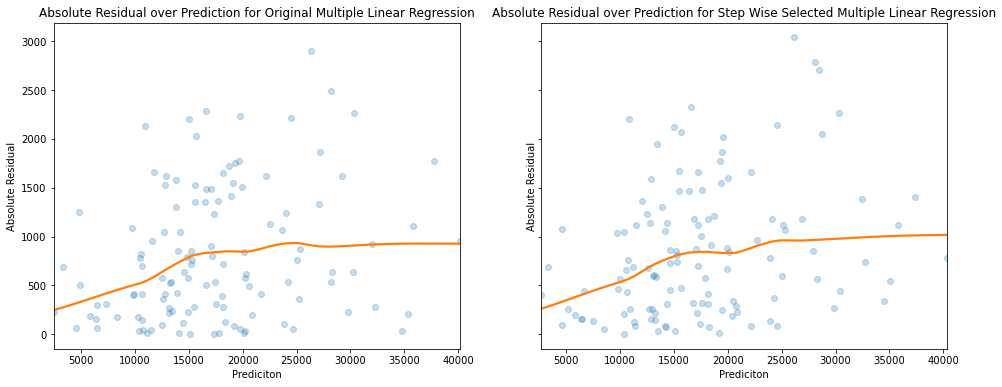

In [117]:
fig,ax = plt.subplots(figsize=(16,6),ncols=2,sharey=True)
regs_OLS = [result_original,result_stepwise]
for i in range(2):
    sns.regplot(regs_OLS[i].fittedvalues,np.abs(regs_OLS[i].resid),
            scatter_kws={'alpha':0.25},line_kws={'color':'C1'},
            lowess=True,ax=ax[i])
    ax[i].set_title('Absolute Residual over Prediction for '+lbls[i]+' Multiple Linear Regression')
    ax[i].set_xlabel('Prediciton')
    ax[i].set_ylabel('Absolute Residual')

The variance for the residual appears appears higher within larger predictions, this seems natural for the lack of information we have for larger income days. The two models behave nearly identical which is good if are consider the less complex model on the right. 

To get another view of the difference let us examine the histograms of the standardized residualsof the two models:

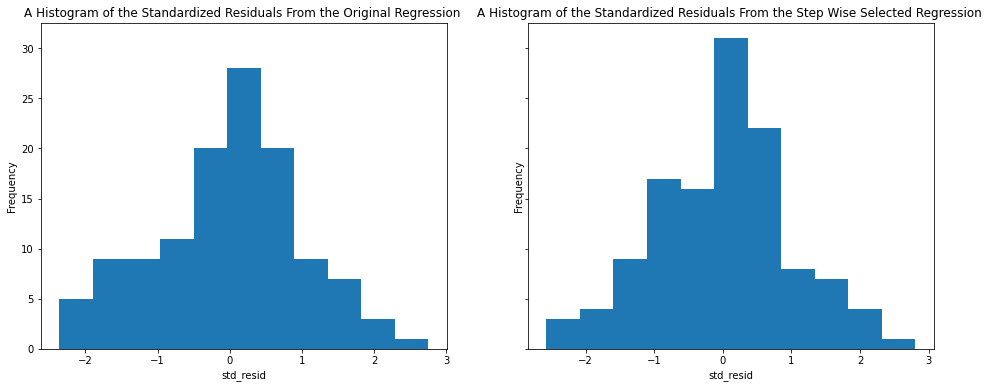

In [118]:
fig,ax = plt.subplots(figsize=(16,6),ncols=2,sharey=True)
for i in range(2):
    resid = regs_OLS[i].resid.values
    resid_std = (resid-resid.mean())/resid.std()
    ax[i].hist(resid_std,bins=11)
    ax[i].set_ylabel('Frequency')
    ax[i].set_xlabel('std_resid')
    ax[i].set_title('A Histogram of the Standardized Residuals From the '+lbls[i]+' Regression ')#of the Training Sales Aggregated Data Set ')
plt.show()

Both appear moderately normal with some mild skewness to the right, specifically for the Original Regression.

Let us now examine metrics of our test set to compare the two models once more:

In [119]:
for lbl,reg,pred in zip(lbls,regs,preds):
    print(lbl)
    y_pred = reg.predict(X_test[pred])
    error = y_test-y_pred
    RMSE = np.sqrt(mean_squared_error(y_test,y_pred))
    r2 = r2_score(y_test,y_pred)
    mae = mean_absolute_error(y_test,y_pred)
    max_error,min_error = error.max(),error.min()
    print('{:<9} : {:<15.3f}'.format('RMSE',RMSE))
    print('{:<9} : {:<15.3f}'.format('MAE',mae))
    print('{:<9} : {:<15.3f}'.format('R^2',r2))
    print('{:<9} : {:<15.3f}'.format('Max Error',max_error))
    print('{:<9} : {:<15.3f}\n'.format('Min Error',min_error))

Original
RMSE      : 1383.311       
MAE       : 1004.912       
R^2       : 0.969          
Max Error : 4593.826       
Min Error : -4747.743      

Step Wise Selected
RMSE      : 1391.674       
MAE       : 1014.425       
R^2       : 0.968          
Max Error : 4639.912       
Min Error : -4456.137      



The two have nearly identical scores, and we would conclude that using the less complex model to be advantagous when looking at larger datasets of the same features, but by then a newer model may be created from newly found data.

<span style='color:blue'>$\underline{\text{Note}}:$ Negative errors represents an overestimation of our Daily Income. Having an understimation of income is less detrimental to a business then that of an over estimation.</span>
### Section 6.4: ElasticNet<a name="section6.4"></a>
What we used within the prior Sections of 6 are simple Multiple Linear Regression Models. We would like to use something that allows for regularization, such as l1 and l2. We're fortunate enough to be able to use Scikit-learn's ElasticNet for such an occasion. Sticking to what we've discovered within **[Section 6.3.1: Predictors and Outcome](#section6.3.1)**, we will use the variables discussed from the step wise selection method as our predictors.

#### Section 6.4.1: Hyperparameterizaing ElasticNet<a name="section6.4.1"></a>
Here we will fit an ElasticNet model, though instead of observing a base model and then performing a grid search we will head straight into hyperparametrization. This will be done using the mean squared error as our scorer. The goal of this hyperparameterization is to increase the minimum error observed in the previous regressions. Recall that negative errors represents an overestimation of our Daily Income, so the higher our minimum error the less volatile our model should be.

In [120]:
from sklearn.linear_model import ElasticNet
""" define search space """
LinReg_params = dict()
LinReg_params['alpha'] = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100]
LinReg_params['l1_ratio'] = [0,1e-4, 1e-3, 1e-2, 1e-1, 1]
LinReg_params['fit_intercept'] = [True, False]
LinReg_params['normalize'] = [True, False]
grid = GridSearchCV(ElasticNet(),LinReg_params,scoring='neg_mean_squared_error',n_jobs=-1,cv=10)
result = grid.fit(X_train[best_variables],y_train)
best_ElasticNet = result.best_estimator_
best_ElasticNet

ElasticNet(alpha=1, l1_ratio=1, normalize=True)

#### Section 6.4.2: Comparison to Previous Regressions<a name="section6.4.2"></a>
Now that our ElasticNet has been fitted let us compare it to the previous models:

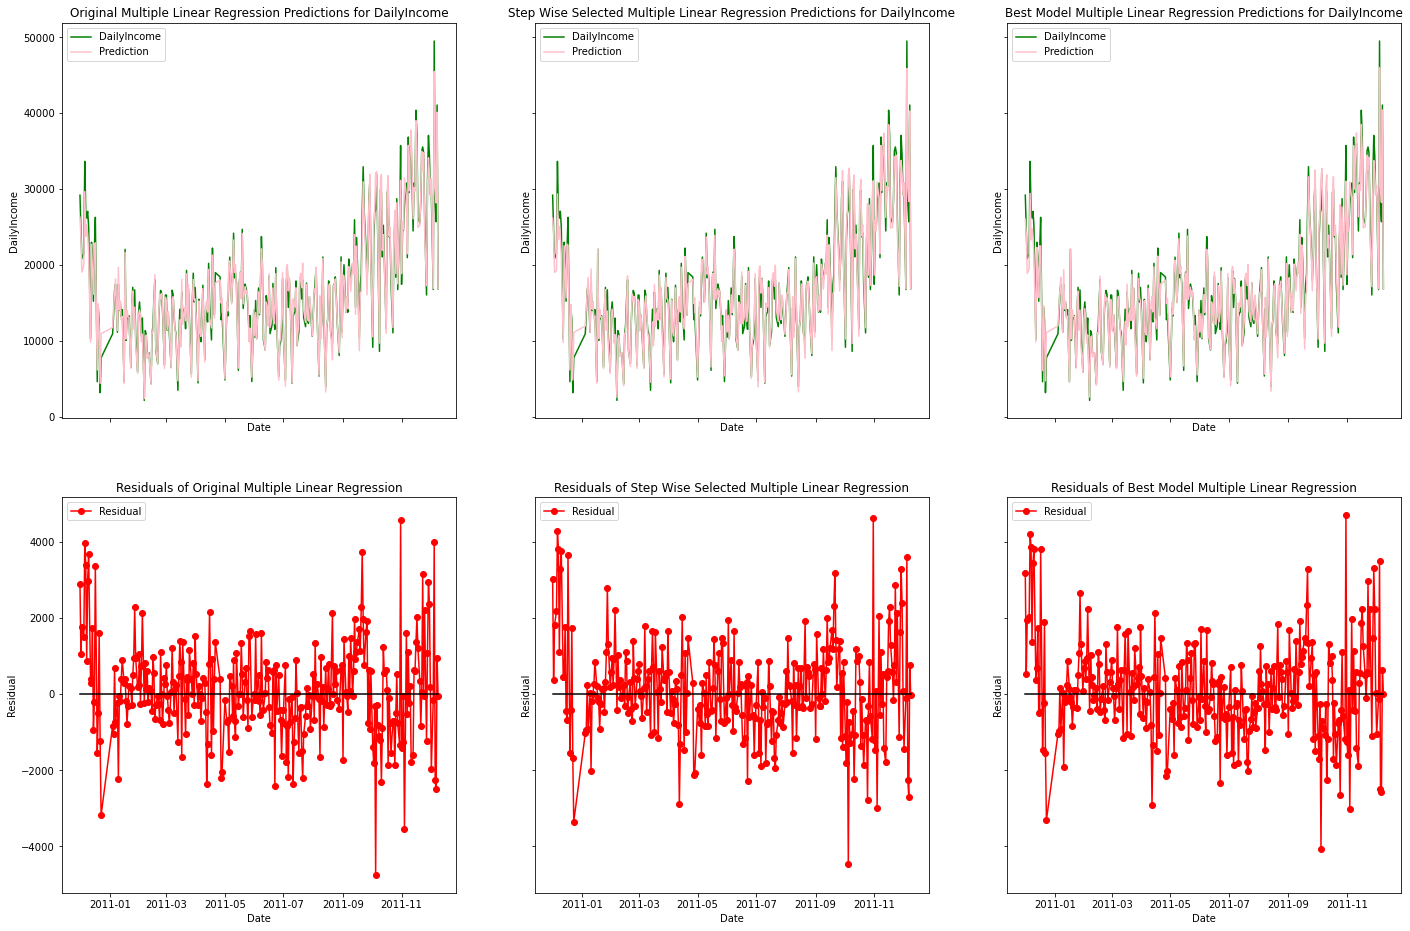

In [121]:
l,r = 0,len(Sale_Aggregated)
fig,ax = plt.subplots(figsize=(24,16),nrows=2,ncols=3,sharey='row',sharex=True)
ax = ax.flatten()
regs = [LinReg,LinReg_stepwise,best_ElasticNet]
preds = [X.columns,best_variables,best_variables]
lbls = ['Original', 'Step Wise Selected','Best Model']

for i in range(3):
    ax[i].plot(Sale_Aggregated.index[l:r],Sale_Aggregated[outcome][l:r],'-g',label='DailyIncome')
    ax[i].plot(Sale_Aggregated.index[l:r],regs[i].predict(X[preds[i]])[l:r],'pink',label='Prediction')
    ax[i].set_title(lbls[i]+' Multiple Linear Regression Predictions for DailyIncome')
    ax[i].set_xlabel('Date')
    ax[i].set_ylabel('DailyIncome')
    ax[i].legend()

    ax[i+3].plot(Sale_Aggregated.index[l:r],Sale_Aggregated[outcome][l:r]-regs[i].predict(X[preds[i]])[l:r],'-or',label='Residual')
    ax[i+3].plot(Sale_Aggregated.index[l:r],np.zeros(r-l),'-k')
    ax[i+3].set_title('Residuals of '+lbls[i]+' Multiple Linear Regression')
    ax[i+3].set_xlabel('Date')
    ax[i+3].set_ylabel('Residual')
    ax[i+3].legend()
plt.show()

It appears that our ElasticNet has done what we've set out for, which is reduce the minimum error, but in doing so has increased our maximum error.

Let us view the metrics to confirm our suspicions:

In [122]:
for lbl,reg,pred in zip(lbls,regs,preds):
    print(lbl)
    y_pred = reg.predict(X_test[pred])
    error = y_test-y_pred
    RMSE = np.sqrt(mean_squared_error(y_test,y_pred))
    r2 = r2_score(y_test,y_pred)
    mae = mean_absolute_error(y_test,y_pred)
    max_error,min_error = error.max(),error.min()
    print('{:<9} : {:<15.3f}'.format('RMSE',RMSE))
    print('{:<9} : {:<15.3f}'.format('MAE',mae))
    print('{:<9} : {:<15.3f}'.format('R^2',r2))
    print('{:<9} : {:<15.3f}'.format('Max Error',max_error))
    print('{:<9} : {:<15.3f}\n'.format('Min Error',min_error))

Original
RMSE      : 1383.311       
MAE       : 1004.912       
R^2       : 0.969          
Max Error : 4593.826       
Min Error : -4747.743      

Step Wise Selected
RMSE      : 1391.674       
MAE       : 1014.425       
R^2       : 0.968          
Max Error : 4639.912       
Min Error : -4456.137      

Best Model
RMSE      : 1383.739       
MAE       : 1005.880       
R^2       : 0.969          
Max Error : 4704.892       
Min Error : -4078.528      



As previoulsy stated, the minimum error was increased as well as the maximum error. To us this is fine, since  overeestimations are considered to be worse than an underestimation from a business standpoint. Our RMSE and MAE has decreased from the stepwise selected model and matches that of our more complex original linear regression model--this of course includes the $R^2$ metric as well.

### Section 6.5: Regression Conclusion<a name="section6.5"></a>
It is odd to think that from our original 541909 entries was trimmed to 488947 to then be reduced to 305 days of sale, but it led to some beautiful looking graphs. Nonetheless, we ran a regression of daily sales on our limited data with good success. The only way to improve on our ElasticNet model is the introduction of new data or the potential of finding more meaningful features. Though this is only 1 year of sales, meaning with an increase of additional years we could use a more powerful model such as a deep learning method. I would hypothesize the use of a Gated Recurent Unit (GRU) or Long Short Term Memory (LSTM) for better predictions.

Another mention is that we only used the quarter of the year in which a sale occured for any mention of time within our model. We imagine using only sales would produce a similar, but weaker model to the one produced.

## Section 7: Notebook Conclusion<a name="section7"></a>
The goal of the project was to see what lay behind the face value of the dataset. From the beginning of *Section 2* we processed the data so that we may remove or recover missing entries from our data set which led the discovery of a lost class known as the 'Guest' CustomerType. We then explored the columns of E-Commerce within *Section 3* to see if there was any unique patterns we may observe. Here we found a distinction between the recovered class 'Guest' and the 'Return' CustomerTypes. We pushed this idea further to a classification problem where we explored the best way to distinct the two using a Machine Learning Classification Algorithm in *Section 4*. Next we noticed the lack of informative information of the items sold, so we took this idea and translated to a clustering problem within *Section 5*. Here we found 15 distinct topics of the items sold. Lastly, we were curious on how to predict income by CustomerType and Topics. This led to the natural regression problem found in *Section 6*, in where we predicted Daily Income by the count of sells for the categories of Topics and CustomerTypes grouped by date.